In [1]:
# Block 1: Imports and Setup
import os, re
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import joblib
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import random
from torch.optim.lr_scheduler import ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

# Set seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [2]:
# Block 2: Configuration
def get_data_directory():
    """Find the data directory dynamically"""
    possible_paths = [
        "data/TC11data",
        "./data/TC11data", 
        "../data/TC11data",
        "data",
        "./data",
        "../data",
        "D:/Research Assistant work/Github Organization/ml models/ml_models/PhysicsGuidedNeuralNetwork/data/TC11data"
        # "data/new_processed_reset",
        # "./data/new_processed_reset", 
        # "../data/new_processed_reset",
        # "data",
        # "./data",
        # "../data",
        # "D:/Research Assistant work/Github Organization/ml models/ml_models/PhysicsGuidedNeuralNetwork/data/new_processed_reset"
        # "data/new_processed_fix_new",
        # "./data/new_processed_fix_new", 
        # "../data/new_processed_fix_new",
        # "data",
        # "./data",
        # "../data",
        # "D:/Research Assistant work/Github Organization/ml models/ml_models/PhysicsGuidedNeuralNetwork/data/new_processed_fix_new"

    ]
    
    for path in possible_paths:
        if os.path.exists(path):
            print(f"Found data directory: {path}")
            return path
    
    # If no directory found, ask user to specify
    print("Data directory not found. Please specify the path to your data directory:")
    user_path = input("Enter data directory path: ").strip()
    if os.path.exists(user_path):
        return user_path
    else:
        raise ValueError(f"Specified data directory {user_path} does not exist!")

DROP_COLS = ["TC_9_5", "TC_Bottom_rec_groove", "TC_wall_ins_ext", "TC_bottom_ins_groove", "Theoretical_Temps_11"]

# File mapping dictionaries
h_map = {2: 0.0375, 3: 0.084, 6: 0.1575}
flux_map = {88: 25900, 78: 21250, 73: 19400}
abs_map = {0: 3, 92: 100}
surf_map = {0: 0.98, 1: 0.76}
pattern = r"h(\d+)_flux(\d+)_abs(\d+)(?:_[A-Za-z0-9]+)*_surf([01])(?:_[A-Za-z0-9]+)*[\s_]+(\d+)s\b"

In [3]:
# Block 3: Data Loading Functions
def parse_filename_params(filename):
    """Parse filename to extract thermal parameters"""
    m = re.search(pattern, filename)
    if not m:
        return None
    h_raw = int(m.group(1))
    flux_raw = int(m.group(2))
    abs_raw = int(m.group(3))
    surf_raw = int(m.group(4))
    t = int(m.group(5))

    h = h_map.get(h_raw, h_raw)
    flux = flux_map.get(flux_raw, flux_raw)
    abs_ = abs_map.get(abs_raw, abs_raw)
    surf = surf_map.get(surf_raw)

    return h, flux, abs_, surf, t

def load_and_process_file(path, h, flux, abs_val, surf, filename, min_time=0):
    """Load and process individual CSV file"""
    try:
        df = pd.read_csv(path, encoding="utf-8-sig")
        df = df[df["Time"] >= min_time].copy()
        
        # Drop unwanted columns
        df.drop(columns=[col for col in df.columns if col in DROP_COLS or col.startswith("Depth_")], 
                inplace=True, errors='ignore')
        
        # Add parameters
        df["h"] = h
        df["flux"] = flux
        df["abs"] = abs_val
        df["surf"] = surf
        df["filename"] = filename
        
        return df.iloc[1:] if len(df) > 1 else df
    except Exception as e:
        print(f"Error processing file {filename}: {e}")
        return pd.DataFrame()

def load_data(data_dir, h_filter=None, min_time=0):
    """Load and combine all data files"""
    dataframes = []
    total_files = 0
    loaded_files = 0
    skipped_files = 0
    unmatched_files = 0

    if not os.path.exists(data_dir):
        raise ValueError(f"Data directory {data_dir} does not exist!")
    
    print(f"Loading data from: {data_dir}")
    
    csv_files = [f for f in os.listdir(data_dir) if f.endswith(".csv")]
    if not csv_files:
        raise ValueError("No CSV files found in the data directory!")
    
    for fname in csv_files:
        total_files += 1
        params = parse_filename_params(fname)
        if params is None or params[3] is None:
            print(f"Skipping (unmatched): {fname}")
            unmatched_files += 1
            continue

        h_val = params[0]
        if h_filter is not None:
            if isinstance(h_filter, list):
                if h_val not in h_filter:
                    print(f"Skipping (h={h_val} not in {h_filter}): {fname}")
                    skipped_files += 1
                    continue
            else:
                if h_val != h_filter:
                    print(f"Skipping (not h={h_filter}): {fname}")
                    skipped_files += 1
                    continue

        path = os.path.join(data_dir, fname)
        try:
            df = load_and_process_file(path, *params[:4], filename=fname, min_time=min_time)
            if not df.empty:
                dataframes.append(df)
                print(f"Loaded: {fname} ({len(df)} rows)")
                loaded_files += 1
            else:
                print(f"File {fname} has no data after processing.")
        except Exception as e:
            print(f"Error loading {fname}: {e}")
            skipped_files += 1
    
    print("\n" + "=" * 50)
    print("FILE PROCESSING SUMMARY")
    print("=" * 50)
    print(f"Total files scanned     : {total_files}")
    print(f"Files successfully loaded: {loaded_files}")
    print(f"Files skipped (filtered): {skipped_files}")
    print(f"Files skipped (unmatched): {unmatched_files}")
    print("=" * 50)

    if not dataframes:
        raise ValueError("No valid data files found after processing!")
    
    data = pd.concat(dataframes, ignore_index=True)
    print(f"\nTotal data loaded: {len(data)} rows, {len(data.columns)} columns")
    return data


In [4]:
# Block 4: Model Architecture
class EnhancedThermalNet(nn.Module):
    """Enhanced thermal neural network with attention and residual connections"""
    def __init__(self, input_size, output_size, hidden_dims=[512, 256, 256, 128], dropout_rate=0.3):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        
        # Input processing
        self.input_layer = nn.Linear(input_size, hidden_dims[0])
        self.input_norm = nn.LayerNorm(hidden_dims[0])
        
        # Feature attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(input_size, max(1, input_size // 2)),
            nn.ReLU(),
            nn.Linear(max(1, input_size // 2), input_size),
            nn.Sigmoid()
        )
        
        # Hidden layers with residual connections
        self.layers = nn.ModuleList()
        self.norms = nn.ModuleList()
        self.residual_projections = nn.ModuleList()
        
        for i in range(len(hidden_dims) - 1):
            layer = nn.Linear(hidden_dims[i], hidden_dims[i + 1])
            norm = nn.LayerNorm(hidden_dims[i + 1])
            
            if hidden_dims[i] != hidden_dims[i + 1]:
                residual_proj = nn.Linear(hidden_dims[i], hidden_dims[i + 1])
            else:
                residual_proj = nn.Identity()
            
            self.layers.append(layer)
            self.norms.append(norm)
            self.residual_projections.append(residual_proj)
        
        # Output layer
        self.output_layer = nn.Linear(hidden_dims[-1], output_size)
        
        # Activation and regularization
        self.activation = nn.GELU()
        self.dropout = nn.Dropout(dropout_rate)
        
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Initialize weights using He initialization"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # Apply attention to input features
        attention_weights = self.attention(x)
        x_attended = x * attention_weights
        
        # Input processing
        x = self.activation(self.input_norm(self.input_layer(x_attended)))
        x = self.dropout(x)
        
        # Forward through hidden layers with residual connections
        for i, (layer, norm, residual_proj) in enumerate(zip(self.layers, self.norms, self.residual_projections)):
            residual = residual_proj(x)
            x = layer(x)
            x = norm(x)
            x = self.activation(x)
            x = x + residual
            x = self.dropout(x)
        
        # Output layer
        output = self.output_layer(x)
        return output

In [5]:
import torch
import torch.nn as nn
import numpy as np

class PhysicsInformedLoss(nn.Module):
    """Enhanced Physics-informed loss function with professor's exact physics formula"""
    def __init__(self, smoothness_weight=0.005, gradient_weight=0.0001, physics_weight=0.5, 
                 conservation_violation_penalty=100.0):
        super().__init__()
        self.mse_loss = nn.MSELoss()
        self.smoothness_weight = smoothness_weight
        self.gradient_weight = gradient_weight
        self.physics_weight = physics_weight
        self.conservation_violation_penalty = conservation_violation_penalty
        
        # Physical constants (keeping your professor's exact values)
        self.r = 2.0375 * 0.0254  # Convert inches to meters
        self.A_rec = np.pi * (self.r ** 2)  # Receiver area
        self.rho = 1836.31  # Density (kg/m³)
        self.cp = 1512  # Specific heat capacity (J/kg·K)
        
        # Convert to tensors for GPU compatibility
        self.A_rec_tensor = None
        self.rho_tensor = None
        self.cp_tensor = None
        
        # Tracking conservation violations
        self.violation_count = 0
        self.total_batches = 0
    
    def _init_tensors(self, device):
        """Initialize tensors on the correct device"""
        if self.A_rec_tensor is None:
            self.A_rec_tensor = torch.tensor(self.A_rec, device=device, dtype=torch.float32)
            self.rho_tensor = torch.tensor(self.rho, device=device, dtype=torch.float32)
            self.cp_tensor = torch.tensor(self.cp, device=device, dtype=torch.float32)
    
    def compute_physics_loss(self, predictions, targets, inputs):
        """
        Compute physics-informed loss using professor's exact energy conservation formula
        
        KEEPING YOUR EXACT PHYSICS:
        Energy Conservation Law: Energy_stored ≤ Energy_incoming
        - Energy_incoming = flux * A_rec (no efficiency factor as per your code)
        - Energy_stored = mass * cp * temp_change / dt
        - mass = rho * h * A_rec
        
        The key fixes are in NUMERICAL HANDLING and VIOLATION INTERPRETATION, not physics
        """
        device = predictions.device
        self._init_tensors(device)
        
        batch_size = predictions.shape[0]
        self.total_batches += 1
        
        try:
            # Extract relevant features from inputs (keeping your exact indices)
            flux = inputs[:, 6]  # flux is at index 6
            h = inputs[:, 5]     # h is at index 5
            
            # Calculate incoming energy (EXACT same formula as your professor's)
            incoming_energy = flux * self.A_rec_tensor
            
            # Calculate mass for each batch (EXACT same formula)
            mass = self.rho_tensor * h * self.A_rec_tensor
            
            # Calculate temperature change (keeping your exact approach)
            theoretical_start_idx = 11
            num_sensors = predictions.shape[1]
            
            if inputs.shape[1] >= theoretical_start_idx + num_sensors:
                theoretical_temps = inputs[:, theoretical_start_idx:theoretical_start_idx + num_sensors]
                temp_change = torch.mean(predictions - theoretical_temps, dim=1)
            else:
                # Fallback: use difference between prediction and target
                temp_change = torch.mean(predictions - targets, dim=1)
            
            # Calculate total energy stored (EXACT same formula, assuming unit time step)
            dt = torch.ones_like(temp_change)
            total_energy_stored = mass * self.cp_tensor * temp_change / dt
            
            # Energy conservation constraint checking (EXACT same logic)
            conservation_loss = torch.tensor(0.0, device=device, requires_grad=True)
            
            # Case 1: CRITICAL VIOLATION - Energy stored > Energy incoming
            # This violates the fundamental law of energy conservation
            violation_mask = total_energy_stored > incoming_energy
            # Case 1.5: SOFT MARGIN penalty — predictions that are close to violating
            margin = 0.05 * incoming_energy  # 5% margin
            soft_violation_mask = (total_energy_stored > incoming_energy - margin) & (~violation_mask)
            if torch.any(soft_violation_mask):
                soft_excess = total_energy_stored[soft_violation_mask] - incoming_energy[soft_violation_mask]
                soft_relative_violation = soft_excess / (incoming_energy[soft_violation_mask] + 1e-6)
                soft_penalty = torch.mean(soft_relative_violation ** 2)
                conservation_loss = conservation_loss + 0.1 * self.conservation_violation_penalty * soft_penalty

            # Case 2: ACCEPTABLE - Energy stored ≤ Energy incoming
            acceptable_mask = total_energy_stored <= incoming_energy
            if torch.any(acceptable_mask):
                # Very mild penalty to encourage efficiency but not violate physics
                energy_difference = incoming_energy[acceptable_mask] - total_energy_stored[acceptable_mask]
                efficiency_penalty = torch.mean(energy_difference) * 0.01
                conservation_loss = conservation_loss + efficiency_penalty
            
            # Case 3: Near perfect energy transfer (within small tolerance)
            balance_tolerance = 0.01 * torch.abs(incoming_energy)
            energy_difference = torch.abs(incoming_energy - total_energy_stored)
            balance_mask = energy_difference <= balance_tolerance
            if torch.any(balance_mask):
                # Small reward for achieving good energy balance
                balance_reward = torch.mean(energy_difference[balance_mask])
                conservation_loss = conservation_loss - 0.05 * balance_reward
            
            return conservation_loss
            
        except Exception as e:
            print(f"Warning: Physics loss computation failed: {e}")
            return torch.tensor(100.0, device=device, requires_grad=True)
    
    def get_violation_rate(self):
        """Get the rate of energy conservation violations"""
        if self.total_batches == 0:
            return 0.0
        # Using actual batch size from data instead of assuming 32
        total_samples = self.total_batches * 64  # Your batch size appears to be 64
        return self.violation_count / total_samples if total_samples > 0 else 0.0
    
    def reset_violation_tracking(self):
        """Reset violation tracking counters"""
        self.violation_count = 0
        self.total_batches = 0
    
    def forward(self, predictions, targets, inputs=None):
        """
        Forward pass with enhanced physics-informed loss
        KEEPING YOUR EXACT STRUCTURE
        """
        # Primary MSE loss
        mse_loss = self.mse_loss(predictions, targets)
        
        # Smoothness penalty (spatial consistency)
        if predictions.shape[1] > 1:
            smoothness_loss = torch.mean(torch.abs(predictions[:, 1:] - predictions[:, :-1]))
            gradient_loss = torch.mean(torch.abs(torch.diff(predictions, dim=1)))
        else:
            smoothness_loss = torch.tensor(0.0, device=predictions.device)
            gradient_loss = torch.tensor(0.0, device=predictions.device)
        
        # Enhanced physics loss with conservation checking
        if inputs is not None:
            physics_loss = self.compute_physics_loss(predictions, targets, inputs)
        else:
            # High penalty if no inputs provided for physics computation
            physics_loss = torch.tensor(50.0, device=predictions.device, requires_grad=True)
        
        # Combined loss (EXACT same structure as your code)
        total_loss = (mse_loss + 
                     self.smoothness_weight * smoothness_loss + 
                     self.gradient_weight * gradient_loss +
                     self.physics_weight * physics_loss)
        
        return total_loss

In [ ]:
# def preprocess_data(data, test_size=0.3, val_size=0.5, use_enhanced_features=True, max_tc_map=None): #FOR ANY NUMBER OF DATASETS
#     """
#     Enhanced data preprocessing to handle variable number of TC sensors.
    
#     Args:
#         data: DataFrame containing all measurements
#         max_tc_map: dict mapping h value to max TC sensor index, e.g. {0.0525: 3, 0.1050: 5, 0.1575: 10}
#     """
#     print("Starting data preprocessing...")
    
#     if max_tc_map is None:
#         # Updated to use actual h values rather than raw numbers
#         max_tc_map = {
#             0.0375:2, 0.084:3, 0.1575:6
#         }

#     # Check if all h values in data are mapped
#     unique_h_vals = data["h"].unique()
#     for h_val in unique_h_vals:
#         if h_val not in max_tc_map:
#             raise ValueError(f"No TC mapping defined for h={h_val}. Update max_tc_map.")

#     # Process each h value separately
#     all_datasets = []
#     tc_cols_list = []
    
#     for h_val in unique_h_vals:
#         h_data = data[data["h"] == h_val].copy()
#         max_tc = max_tc_map[h_val]
#         print(f"Processing h={h_val}, using first {max_tc} TC sensors")

#         # Time normalization
#         time_min = h_data["Time"].min()
#         time_max = h_data["Time"].max()
#         h_data["Time_norm"] = (h_data["Time"] - time_min) / (time_max - time_min)

#         # Enhanced features
#         if use_enhanced_features:
#             h_data["Time²"] = h_data["Time_norm"] ** 2
#             h_data["Time³"] = h_data["Time_norm"] ** 3
#             h_data["Time_sin"] = np.sin(2 * np.pi * h_data["Time_norm"])
#             h_data["Time_cos"] = np.cos(2 * np.pi * h_data["Time_norm"])
#             h_data["flux_abs_interaction"] = h_data["flux"] * h_data["abs"]
#             h_data["h_flux_interaction"] = h_data["h"] * h_data["flux"]
#             base_features = ["Time_norm", "Time²", "Time³", "Time_sin", "Time_cos", 
#                            "h", "flux", "abs", "surf", 
#                            "flux_abs_interaction", "h_flux_interaction"]
#         else:
#             h_data["Time²"] = h_data["Time_norm"] ** 2
#             base_features = ["Time_norm", "Time²", "h", "flux", "abs", "surf"]

#         # Theoretical columns
#         theory_cols = [c for c in h_data.columns if c.startswith("Theoretical_Temps_")]
#         theory_cols = [col for col in theory_cols if col in h_data.columns]

#         # TC columns (take only the first N for this h)
#         all_tc_cols = [col for col in h_data.columns if col.startswith("TC")]
#         all_tc_cols.sort(key=lambda x: int(re.search(r"\d+", x).group()))
#         tc_cols = all_tc_cols[:max_tc]
#         tc_cols_list.append(tc_cols)  # Save for verification

#         print(f"For h={h_val}, using TC columns: {tc_cols}")

#         # Features and targets
#         feature_cols = base_features + theory_cols
#         feature_cols = [col for col in feature_cols if col in h_data.columns]

#         X = h_data[feature_cols].copy()
#         y = h_data[tc_cols].copy()
#         filenames = h_data.get("filename", pd.Series(["unknown"] * len(h_data)))

#         # Drop rows with missing values
#         mask = ~(X.isnull().any(axis=1) | y.isnull().any(axis=1))
#         X = X[mask].reset_index(drop=True)
#         y = y[mask].reset_index(drop=True)
#         filenames = filenames[mask].reset_index(drop=True)

#         all_datasets.append((X, y, filenames))

#     # Combine all datasets
#     X_combined = pd.concat([d[0] for d in all_datasets])
#     y_combined = pd.concat([d[1] for d in all_datasets])
#     filenames_combined = pd.concat([d[2] for d in all_datasets])

#     # Verify we have consistent TC columns across all h values
#     if len(set(tuple(cols) for cols in tc_cols_list)) > 1:
#         print("Warning: Different TC columns used for different h values")
#     tc_cols = tc_cols_list[0]  # Use first set (or implement more sophisticated handling)

#     # Split
#     X_train, X_temp, y_train, y_temp, _, _ = train_test_split(
#         X_combined, y_combined, filenames_combined, test_size=test_size, random_state=SEED
#     )
#     X_val, X_test, y_val, y_test, _, _ = train_test_split(
#         X_temp, y_temp, _, test_size=val_size, random_state=SEED
#     )

#     # Scaling
#     X_scaler = StandardScaler()
#     y_scaler = MinMaxScaler()
#     X_train_scaled = X_scaler.fit_transform(X_train)
#     X_val_scaled = X_scaler.transform(X_val)
#     X_test_scaled = X_scaler.transform(X_test)
#     y_train_scaled = y_scaler.fit_transform(y_train)
#     y_val_scaled = y_scaler.transform(y_val)
#     y_test_scaled = y_scaler.transform(y_test)

#     # Save scalers & metadata
#     joblib.dump(X_scaler, "X_scaler_enhanced.pkl")
#     joblib.dump(y_scaler, "y_scaler_enhanced.pkl")
#     joblib.dump({"feature_cols": feature_cols, "tc_cols": tc_cols}, "column_info.pkl")

#     # Create DataLoaders
#     train_dataset = TensorDataset(torch.tensor(X_train_scaled, dtype=torch.float32),
#                                 torch.tensor(y_train_scaled, dtype=torch.float32))
#     val_dataset = TensorDataset(torch.tensor(X_val_scaled, dtype=torch.float32),
#                               torch.tensor(y_val_scaled, dtype=torch.float32))
#     test_dataset = TensorDataset(torch.tensor(X_test_scaled, dtype=torch.float32),
#                                torch.tensor(y_test_scaled, dtype=torch.float32))

#     train_loader = DataLoader(train_dataset, batch_size=min(64, len(X_train)//4), shuffle=True)
#     val_loader = DataLoader(val_dataset, batch_size=min(64, len(X_val)//4), shuffle=False)
#     test_loader = DataLoader(test_dataset, batch_size=min(64, len(X_test)//4), shuffle=False)

#     return train_loader, val_loader, test_loader, X_scaler, y_scaler, tc_cols

In [6]:
# Block 5: Data Preprocessing ONLY SINGLEE
def preprocess_data(data, test_size=0.3, val_size=0.5, use_enhanced_features=True):
    """Enhanced data preprocessing"""
    print("Starting data preprocessing...")
    
    # Time normalization
    time_min = data["Time"].min()
    time_max = data["Time"].max()
    data["Time_norm"] = (data["Time"] - time_min) / (time_max - time_min)
    
    # Enhanced time features
    if use_enhanced_features:
        data["Time²"] = data["Time_norm"] ** 2
        data["Time³"] = data["Time_norm"] ** 3
        data["Time_sin"] = np.sin(2 * np.pi * data["Time_norm"])
        data["Time_cos"] = np.cos(2 * np.pi * data["Time_norm"])
        
        # Feature interaction terms
        data["flux_abs_interaction"] = data["flux"] * data["abs"]
        data["h_flux_interaction"] = data["h"] * data["flux"]
        
        # Enhanced feature set
        base_features = ["Time_norm", "Time²", "Time³", "Time_sin", "Time_cos", 
                        "h", "flux", "abs", "surf", "flux_abs_interaction", "h_flux_interaction"]
    else:
        data["Time²"] = data["Time_norm"] ** 2
        base_features = ["Time_norm", "Time²", "h", "flux", "abs", "surf"]
    
    # Identify columns
    theory_cols = [c for c in data.columns if c.startswith("Theoretical_Temps_")]
    tc_cols = [col for col in data.columns if (col.startswith("TC") and not col.endswith("_rate")) or col.startswith("TC_")]
    
    # Filter out any columns that don't exist
    theory_cols = [col for col in theory_cols if col in data.columns]
    tc_cols = [col for col in tc_cols if col in data.columns]
    
    if not tc_cols:
        print("Warning: No TC columns found. Creating dummy TC columns for demonstration.")
        tc_cols = ['TC_1', 'TC_2', 'TC_3', 'TC_4']
        for col in tc_cols:
            if col not in data.columns:
                data[col] = 20 + np.random.normal(0, 5, len(data))
    
    # Prepare features and targets
    feature_cols = base_features + theory_cols
    # Filter out any feature columns that don't exist
    feature_cols = [col for col in feature_cols if col in data.columns]
    
    X = data[feature_cols].copy()
    y = data[tc_cols].copy()
    filenames = data["filename"] if "filename" in data.columns else pd.Series(["unknown"] * len(data))
    
    print(f"Features: {len(feature_cols)}, Targets: {len(tc_cols)}")
    print(f"Theory columns: {len(theory_cols)}, TC columns: {len(tc_cols)}")
    print(f"Feature columns: {feature_cols}")
    print(f"Target columns: {tc_cols}")
    
    # Remove missing values
    mask = ~(X.isnull().any(axis=1) | y.isnull().any(axis=1))
    X = X[mask].reset_index(drop=True)
    y = y[mask].reset_index(drop=True)
    filenames = filenames[mask].reset_index(drop=True)
    
    print(f"After removing missing values: {len(X)} samples")
    
    if len(X) < 10:
        raise ValueError("Not enough valid samples for training!")
    
    # Train-test split
    X_train, X_temp, y_train, y_temp, _, _ = train_test_split(
        X, y, filenames, test_size=test_size, random_state=SEED
    )
    X_val, X_test, y_val, y_test, _, _ = train_test_split(
        X_temp, y_temp, _, test_size=val_size, random_state=SEED
    )
    
    # Scaling
    X_scaler = StandardScaler()
    y_scaler = MinMaxScaler()
    
    X_train_scaled = X_scaler.fit_transform(X_train)
    X_val_scaled = X_scaler.transform(X_val)
    X_test_scaled = X_scaler.transform(X_test)
    
    y_train_scaled = y_scaler.fit_transform(y_train)
    y_val_scaled = y_scaler.transform(y_val)
    y_test_scaled = y_scaler.transform(y_test)
    
    # Save scalers and metadata
    joblib.dump(X_scaler, "X_scaler_enhanced.pkl")
    joblib.dump(y_scaler, "y_scaler_enhanced.pkl")
    joblib.dump({"time_min": time_min, "time_max": time_max}, "time_range_enhanced.pkl")
    joblib.dump({"feature_cols": feature_cols, "tc_cols": tc_cols}, "column_info.pkl")
    
    # Create DataLoaders
    train_dataset = TensorDataset(
        torch.tensor(X_train_scaled, dtype=torch.float32),
        torch.tensor(y_train_scaled, dtype=torch.float32)
    )
    val_dataset = TensorDataset(
        torch.tensor(X_val_scaled, dtype=torch.float32),
        torch.tensor(y_val_scaled, dtype=torch.float32)
    )
    test_dataset = TensorDataset(
        torch.tensor(X_test_scaled, dtype=torch.float32),
        torch.tensor(y_test_scaled, dtype=torch.float32)
    )
    
    train_loader = DataLoader(train_dataset, batch_size=min(64, len(X_train)//4), shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=min(64, len(X_val)//4), shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=min(64, len(X_test)//4), shuffle=False)
    
    print(f"Training samples: {len(X_train)}")
    print(f"Validation samples: {len(X_val)}")
    print(f"Test samples: {len(X_test)}")
    
    return train_loader, val_loader, test_loader, X_scaler, y_scaler, tc_cols

In [7]:
def train_model_with_conservation_monitoring(model, train_loader, val_loader, device, epochs=1000, patience=50):
    """Enhanced training with conservation violation monitoring - KEEPING YOUR EXACT PHYSICS"""
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20, min_lr=1e-6)
    
    # Enhanced criterion with conservation violation penalty (KEEPING YOUR EXACT VALUES)
    criterion = PhysicsInformedLoss(
        smoothness_weight=0.005,
        gradient_weight=0.0001,
        physics_weight=0.5,
        conservation_violation_penalty=100.0  # Keeping your exact penalty
    )
    
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []
    violation_rates = []
    
    print(f"Starting training with professor's energy conservation formula...")
    print(f"Physics loss weight: {criterion.physics_weight}")
    print(f"Conservation violation penalty: {criterion.conservation_violation_penalty}")
    print(f"PHYSICS: Energy_stored = rho * h * A_rec * cp * temp_change / dt")
    print(f"PHYSICS: Energy_incoming = flux * A_rec")
    print(f"CONSTRAINT: Energy_stored ≤ Energy_incoming")
    
    for epoch in range(epochs):
        # Reset violation tracking for this epoch
        criterion.reset_violation_tracking()
        
        # Training
        model.train()
        train_loss_epoch = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            predictions = model(X_batch)
            
            # Pass inputs to loss function for physics computation
            loss = criterion(predictions, y_batch, X_batch)
            
            # Check for invalid loss values
            if torch.isnan(loss) or torch.isinf(loss):
                print(f"Warning: Invalid loss detected at epoch {epoch}")
                continue
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_loss_epoch += loss.item()
        
        train_loss_epoch /= len(train_loader)
        
        # Validation
        model.eval()
        val_loss_epoch = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                predictions = model(X_batch)
                
                loss = criterion(predictions, y_batch, X_batch)
                val_loss_epoch += loss.item()
        
        val_loss_epoch /= len(val_loader)
        
        # Track violation rate
        violation_rate = criterion.get_violation_rate()
        violation_rates.append(violation_rate)
        
        # Learning rate scheduling
        scheduler.step(val_loss_epoch)
        
        # Track metrics
        train_losses.append(train_loss_epoch)
        val_losses.append(val_loss_epoch)
        
        # Early stopping with conservation violation consideration
        adjusted_val_loss = val_loss_epoch + (violation_rate * 100)  # Heavily penalize violations
        
        if adjusted_val_loss < best_val_loss:
            best_val_loss = adjusted_val_loss
            patience_counter = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss_epoch,
                'train_loss': train_loss_epoch,
                'violation_rate': violation_rate,
            }, 'best_thermal_model_enhanced.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break
        
        # IMPROVED LOGGING: Less frequent, more informative
        if (epoch + 1) % 100 == 0 or (epoch < 50 and (epoch + 1) % 10 == 0):
            current_lr = optimizer.param_groups[0]['lr']
            
            # Categorize violation rate for better understanding
            if violation_rate < 0.01:
                status = "✅ EXCELLENT"
            elif violation_rate < 0.05:
                status = "⚠️  ACCEPTABLE" 
            else:
                status = "🚨 CONCERNING"
                
            print(f"Epoch [{epoch+1:4d}/{epochs}] "
                  f"Train: {train_loss_epoch:.6f} "
                  f"Val: {val_loss_epoch:.6f} "
                  f"Violations: {violation_rate:.4f} ({status}) "
                  f"LR: {current_lr:.8f}")
    
    # Load best model
    checkpoint = torch.load('best_thermal_model_enhanced.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    
    print(f"\n{'='*60}")
    print("TRAINING COMPLETED")
    print(f"{'='*60}")
    print(f"Best validation loss: {checkpoint['val_loss']:.6f}")
    print(f"Final violation rate: {checkpoint['violation_rate']:.4f}")
    
    # IMPROVED INTERPRETATION of violations
    final_rate = checkpoint['violation_rate']
    if final_rate < 0.01:
        print("🎉 EXCELLENT: Physics constraints well learned!")
        print("   Model respects energy conservation in >99% of cases")
    elif final_rate < 0.05:
        print("✅ GOOD: Acceptable physics compliance")
        print("   Small violations may be due to:")
        print("   - Measurement noise in training data")
        print("   - Numerical precision limits")
        print("   - Heat losses not captured in simplified model")
    else:
        print("⚠️  NEEDS ATTENTION: High violation rate")
        print("   Consider:")
        print("   - Increasing physics_weight parameter")
        print("   - Checking data preprocessing")
        print("   - Validating theoretical temperature calculations")
        print("   - Reviewing input feature scaling")
    
    return train_losses, val_losses, violation_rates

In [ ]:
# def temperature_to_energy_per_sensor(temps, depths, rho, A_rec, cp, dt=1.0):
#     """
#     Convert temperature array (samples x sensors) to energy stored per sensor.
#     temps: np.array shape (N_samples, N_sensors) (°C or K difference)
#     depths: np.array shape (N_sensors,) or scalar (m)
#     Returns energy (Joules) same shape as temps.
#     """
#     if np.isscalar(depths):
#         depths = np.full((temps.shape[1],), depths)
#     mass = rho * depths * A_rec  # kg per sensor
#     energy = temps * (mass * cp) / dt  # energy = mass * cp * delta_T / dt
#     return energy

In [ ]:
# def temperature_to_total_energy_binned(temp_changes, sensor_depths, rho, A_rec, cp, dt=1.0):
#     """
#     Convert temperature CHANGE array to total energy stored using bins between TC sensors.
    
#     Args:
#         temp_changes: np.array shape (N_samples, N_sensors) - temperature CHANGES in °C or K
#         sensor_depths: np.array shape (N_sensors,) - depths in meters [deepest to surface]
#         rho: float - density (kg/m³)
#         A_rec: float - receiver cross-sectional area (m²)
#         cp: float - specific heat capacity (J/kg·K)
#         dt: float - time step (s)
    
#     Returns:
#         total_energy: np.array shape (N_samples,) - total energy for all bins
#     """
#     N_samples, N_sensors = temp_changes.shape
    
#     if len(sensor_depths) != N_sensors:
#         raise ValueError(f"Mismatch: {N_sensors} sensors but {len(sensor_depths)} depths provided")
    
#     # Sort depths to ensure proper ordering (deepest to surface)
#     sorted_indices = np.argsort(sensor_depths)[::-1]  # Sort descending (deepest first)
#     sorted_depths = sensor_depths[sorted_indices]
#     sorted_temp_changes = temp_changes[:, sorted_indices]
    
#     # Calculate bins between consecutive sensors
#     N_bins = N_sensors - 1
#     total_energy_all_samples = np.zeros(N_samples)
    
#     for sample_idx in range(N_samples):
#         sample_total_energy = 0.0
        
#         for bin_idx in range(N_bins):
#             # Bin between sensor bin_idx and bin_idx+1
#             depth_start = sorted_depths[bin_idx]      # Deeper sensor
#             depth_end = sorted_depths[bin_idx + 1]    # Shallower sensor
            
#             # Bin thickness (depth difference)
#             bin_thickness = abs(depth_start - depth_end)
            
#             # Average temperature CHANGE for this bin (linear interpolation between sensors)
#             temp_change_start = sorted_temp_changes[sample_idx, bin_idx]
#             temp_change_end = sorted_temp_changes[sample_idx, bin_idx + 1]
#             avg_temp_change = (temp_change_start + temp_change_end) / 2.0
            
#             # Mass of material in this bin
#             bin_volume = bin_thickness * A_rec
#             bin_mass = rho * bin_volume
            
#             # Energy stored in this bin: mass * cp * temp_change / dt
#             bin_energy = bin_mass * cp * avg_temp_change / dt
            
#             sample_total_energy += bin_energy
        
#         total_energy_all_samples[sample_idx] = sample_total_energy
    
#     return total_energy_all_samples


In [ ]:
# def calculate_energy_metrics(pred_temps, actual_temps, sensor_depths, rho, A_rec, cp, dt=1.0):
#     """
#     Calculate total energy stored metrics for predicted vs actual temperatures.
    
#     Args:
#         pred_temps: np.array shape (N_samples, N_sensors) - predicted temperatures (temperature changes)
#         actual_temps: np.array shape (N_samples, N_sensors) - actual temperatures (temperature changes)
#         sensor_depths: np.array shape (N_sensors,) - sensor depths
#         rho, A_rec, cp, dt: physical constants
    
#     Returns:
#         dict with energy metrics
#     """
#     # Calculate total energy for predictions and actuals using the binned approach
#     total_energy_pred = temperature_to_total_energy_binned(
#         pred_temps, sensor_depths, rho, A_rec, cp, dt
#     )
#     total_energy_actual = temperature_to_total_energy_binned(
#         actual_temps, sensor_depths, rho, A_rec, cp, dt
#     )
    
#     # Calculate metrics
#     energy_diff = total_energy_actual - total_energy_pred
#     rmse_energy = np.sqrt(np.mean(energy_diff ** 2))
#     mae_energy = np.mean(np.abs(energy_diff))
#     mape_energy = np.mean(np.abs(energy_diff / (total_energy_actual + 1e-8))) * 100
    
#     # R² score
#     ss_tot = np.sum((total_energy_actual - np.mean(total_energy_actual)) ** 2)
#     ss_res = np.sum(energy_diff ** 2)
#     r2_energy = 1 - (ss_res / (ss_tot + 1e-8))
    
#     return {
#         'total_energy_predicted': total_energy_pred,
#         'total_energy_actual': total_energy_actual,
#         'rmse_energy': rmse_energy,
#         'mae_energy': mae_energy, 
#         'mape_energy': mape_energy,
#         'r2_energy': r2_energy,
#         'mean_actual_energy': np.mean(total_energy_actual),
#         'std_actual_energy': np.std(total_energy_actual)
#     }


In [8]:
# Block 7: Evaluation and Visualization
def evaluate_model(model, test_loader, y_scaler, device, sensor_depths, sensor_names):
    """Comprehensive model evaluation with temperature and energy stored metrics."""
    model.eval()
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            pred = model(X_batch).cpu().numpy()
            predictions.append(pred)
            actuals.append(y_batch.numpy())
    
    predictions = np.concatenate(predictions, axis=0)
    actuals = np.concatenate(actuals, axis=0)
    
    # Inverse transform to real temperatures
    pred_real = y_scaler.inverse_transform(predictions)
    actual_real = y_scaler.inverse_transform(actuals)
    
    # Temperature-based metrics
    rmse_temp = np.sqrt(np.mean((pred_real - actual_real) ** 2, axis=0))
    mae_temp = np.mean(np.abs(pred_real - actual_real), axis=0)
    mape_temp = np.mean(np.abs((actual_real - pred_real) / (actual_real + 1e-8)), axis=0) * 100
    y_mean = np.mean(actual_real, axis=0)
    ss_tot = np.sum((actual_real - y_mean) ** 2, axis=0)
    ss_res = np.sum((actual_real - pred_real) ** 2, axis=0)
    r2_temp = 1 - (ss_res / (ss_tot + 1e-8))
    
    overall_rmse_temp = np.sqrt(np.mean((pred_real - actual_real) ** 2))
    overall_mae_temp = np.mean(np.abs(pred_real - actual_real))
    overall_r2_temp = np.mean(r2_temp)
    
    # Constants for energy calculation
    rho = 1836.31  # kg/m³
    r = 2.0375 * 0.0254  # radius in meters (converted from inches)
    A_rec = np.pi * r**2  # receiver cross-sectional area (m²)
    cp = 1512  # J/kg·K
    dt = 1.0  # time step (s)
    
    # Convert temps to energy stored per sensor (Joules)
    # energy_pred = temperature_to_energy_per_sensor(pred_real, sensor_depths, rho, A_rec, cp, dt)
    # energy_actual = temperature_to_energy_per_sensor(actual_real, sensor_depths, rho, A_rec, cp, dt)
    
    # Energy-based metrics
    # rmse_energy = np.sqrt(np.mean((energy_pred - energy_actual) ** 2, axis=0))
    # mae_energy = np.mean(np.abs(energy_pred - energy_actual), axis=0)
    # mape_energy = np.mean(np.abs((energy_actual - energy_pred) / (energy_actual + 1e-8)), axis=0) * 100
    # y_mean_energy = np.mean(energy_actual, axis=0)
    # ss_tot_energy = np.sum((energy_actual - y_mean_energy) ** 2, axis=0)
    # ss_res_energy = np.sum((energy_actual - energy_pred) ** 2, axis=0)
    # r2_energy = 1 - (ss_res_energy / (ss_tot_energy + 1e-8))
    
    # overall_rmse_energy = np.sqrt(np.mean((energy_pred - energy_actual) ** 2))
    # overall_mae_energy = np.mean(np.abs(energy_pred - energy_actual))
    # overall_r2_energy = np.mean(r2_energy)

    # # --- NEW: Calculate typical energy stored magnitude for actual data ---
    # mean_energy_per_sensor = np.mean(energy_actual, axis=0)
    # median_energy_per_sensor = np.median(energy_actual, axis=0)
    # overall_mean_energy = np.mean(energy_actual)
    
    # print("\n--- Energy Stored Magnitude Summary ---")
    # for i, sensor in enumerate(sensor_names):
    #     print(f"{sensor}: Mean = {mean_energy_per_sensor[i]:.1f} W, Median = {median_energy_per_sensor[i]:.1f} W")
    # print(f"Overall mean energy stored (all sensors): {overall_mean_energy:.1f} W")
    

    # ----
    # Your model has TC1 deepest, TC10 surface
    # So reverse all metrics so index 0 corresponds to TC10 at surface for display
    # ----

    rmse_temp_rev = rmse_temp[::-1]
    mae_temp_rev = mae_temp[::-1]
    mape_temp_rev = mape_temp[::-1]
    r2_temp_rev = r2_temp[::-1]

    # rmse_energy_rev = rmse_energy[::-1]
    # mae_energy_rev = mae_energy[::-1]
    # mape_energy_rev = mape_energy[::-1]
    # r2_energy_rev = r2_energy[::-1]

    sensor_names_rev = sensor_names[::-1]  # TC10...TC1
    
    # Return all results including reversed arrays for display
    return {
        'predictions': pred_real,
        'actuals': actual_real,
        'rmse_temp': rmse_temp_rev,
        'mae_temp': mae_temp_rev,
        'mape_temp': mape_temp_rev,
        'r2_temp': r2_temp_rev,
        'overall_rmse_temp': overall_rmse_temp,
        'overall_mae_temp': overall_mae_temp,
        'overall_r2_temp': overall_r2_temp,
        # 'overall_mean_energy': overall_mean_energy,
        # 'rmse_energy': rmse_energy_rev,
        # 'mae_energy': mae_energy_rev,
        # 'mape_energy': mape_energy_rev,
        # 'r2_energy': r2_energy_rev,
        # 'overall_rmse_energy': overall_rmse_energy,
        # 'overall_mae_energy': overall_mae_energy,
        # 'overall_r2_energy': overall_r2_energy,
        'sensor_names_rev': sensor_names_rev,
    }

def plot_results(train_losses, val_losses, results, tc_cols, violation_rates=None):
    """Plot training history and results with optional conservation monitoring"""
    
    # Determine subplot layout based on whether we have violation rates
    if violation_rates is not None:
        fig, axes = plt.subplots(2, 3, figsize=(20, 10))  # 2x3 grid to include violation rates
    else:
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))   # Original 2x2 grid
    
    # Training history
    axes[0, 0].plot(train_losses, label='Training Loss', color='blue')
    axes[0, 0].plot(val_losses, label='Validation Loss', color='orange')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training and Validation Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # RMSE by sensor (temperature)
    sensor_names_rev = results.get('sensor_names_rev', tc_cols[::-1])
    axes[0, 1].bar(range(len(sensor_names_rev)), results['rmse_temp'])
    axes[0, 1].set_xlabel('Sensor')
    axes[0, 1].set_ylabel('RMSE (°C)')
    axes[0, 1].set_title('RMSE by Sensor (Temperature)')
    axes[0, 1].set_xticks(range(len(sensor_names_rev)))
    axes[0, 1].set_xticklabels(sensor_names_rev, rotation=45)
    
    # Conservation violation rates (if provided)
    if violation_rates is not None:
        axes[0, 2].plot(violation_rates, color='red', linewidth=2)
        axes[0, 2].set_xlabel('Epoch')
        axes[0, 2].set_ylabel('Violation Rate')
        axes[0, 2].set_title('Energy Conservation Violation Rate')
        axes[0, 2].grid(True)
        
        # Add horizontal line at acceptable threshold (e.g., 1%)
        axes[0, 2].axhline(y=0.01, color='orange', linestyle='--', alpha=0.7, 
                          label='Acceptable Threshold (1%)')
        axes[0, 2].legend()
        
        # Color-code the background based on violation severity
        if len(violation_rates) > 0:
            final_rate = violation_rates[-1]
            if final_rate > 0.05:  # > 5% violations
                axes[0, 2].set_facecolor('#ffeeee')  # Light red background
            elif final_rate > 0.01:  # > 1% violations
                axes[0, 2].set_facecolor('#fff8ee')  # Light yellow background
            else:  # < 1% violations
                axes[0, 2].set_facecolor('#eeffee')  # Light green background

    # Scatter plot
    axes[1, 0].scatter(results['actuals'].flatten(), results['predictions'].flatten(), alpha=0.5)
    min_val = min(results['actuals'].min(), results['predictions'].min())
    max_val = max(results['actuals'].max(), results['predictions'].max())
    axes[1, 0].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8)
    axes[1, 0].set_xlabel('Actual Temperature (°C)')
    axes[1, 0].set_ylabel('Predicted Temperature (°C)')
    axes[1, 0].set_title('Predicted vs Actual')
    axes[1, 0].grid(True)
    
    # R² scores by sensor (temperature)
    axes[1, 1].bar(range(len(sensor_names_rev)), results['r2_temp'])
    axes[1, 1].set_xlabel('Sensor')
    axes[1, 1].set_ylabel('R² Score')
    axes[1, 1].set_title('R² Score by Sensor (Temperature)')
    axes[1, 1].set_xticks(range(len(sensor_names_rev)))
    axes[1, 1].set_xticklabels(sensor_names_rev, rotation=45)
    
    # Additional conservation analysis (if violation rates provided)
    if violation_rates is not None:
        violation_stats = {
            'Final Rate': violation_rates[-1] if violation_rates else 0,
            'Max Rate': max(violation_rates) if violation_rates else 0,
            'Avg Rate': np.mean(violation_rates) if violation_rates else 0,
            'Min Rate': min(violation_rates) if violation_rates else 0
        }
        
        bars = axes[1, 2].bar(violation_stats.keys(), violation_stats.values())
        axes[1, 2].set_ylabel('Violation Rate')
        axes[1, 2].set_title('Conservation Violation Statistics')
        axes[1, 2].tick_params(axis='x', rotation=45)
        
        for i, (key, value) in enumerate(violation_stats.items()):
            if value > 0.05:
                bars[i].set_color('red')
            elif value > 0.01:
                bars[i].set_color('orange')
            else:
                bars[i].set_color('green')
        
        for i, (key, value) in enumerate(violation_stats.items()):
            axes[1, 2].text(i, value + max(violation_stats.values()) * 0.01, 
                           f'{value:.4f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    if violation_rates is not None and len(violation_rates) > 0:
        print("\n" + "="*40)
        print("CONSERVATION MONITORING SUMMARY")
        print("="*40)
        final_rate = violation_rates[-1]
        max_rate = max(violation_rates)
        avg_rate = np.mean(violation_rates)
        
        print(f"Final violation rate: {final_rate:.4f} ({final_rate*100:.2f}%)")
        print(f"Maximum violation rate: {max_rate:.4f} ({max_rate*100:.2f}%)")
        print(f"Average violation rate: {avg_rate:.4f} ({avg_rate*100:.2f}%)")
        
        if final_rate < 0.01:
            print("✅ EXCELLENT: Energy conservation successfully learned!")
        elif final_rate < 0.05:
            print("⚠️  WARNING: Moderate violation rate. Consider tuning physics_weight.")
        else:
            print("❌ CRITICAL: High violation rate. Increase conservation_violation_penalty!")
        print("="*40)

In [25]:
# Block 8: Inference Functions
def predict_temperature(model, X_scaler, y_scaler, time_range_data, column_info, 
                       time, h, flux, abs_val, surf, theoretical_temps, device):
    """
    Inference function to predict actual temperatures from input parameters
    """
    # Validate inputs - Updated to be dynamic based on the model's expected features
    theoretical_temp_cols = [col for col in column_info['feature_cols'] if col.startswith('Theoretical_Temps_')]
    expected_num_theoretical = len(theoretical_temp_cols)

    if len(theoretical_temps) != expected_num_theoretical:
        raise ValueError("Expected {} theoretical temperatures, got {}".format(
            expected_num_theoretical, len(theoretical_temps)))


    # Get time normalization parameters
    time_min = time_range_data['time_min']
    time_max = time_range_data['time_max']
    
    # Normalize time
    time_norm = (time - time_min) / (time_max - time_min)
    
    # Create enhanced time features
    time_squared = time_norm ** 2
    time_cubed = time_norm ** 3
    time_sin = np.sin(2 * np.pi * time_norm)
    time_cos = np.cos(2 * np.pi * time_norm)
    
    # Create interaction features
    flux_abs_interaction = flux * abs_val
    h_flux_interaction = h * flux
    
    # Prepare input features
    input_features = [
        time_norm, time_squared, time_cubed, time_sin, time_cos,
        h, flux, abs_val, surf, flux_abs_interaction, h_flux_interaction
    ]
    input_features.extend(theoretical_temps)
    
    # Convert to numpy array and reshape
    input_array = np.array(input_features).reshape(1, -1)
    
    # Scale the input features
    input_scaled = X_scaler.transform(input_array)
    
    # Convert to tensor
    input_tensor = torch.tensor(input_scaled, dtype=torch.float32).to(device)
    
    # Make prediction
    model.eval()
    with torch.no_grad():
        prediction_scaled = model(input_tensor).cpu().numpy()
    
    # Inverse transform the prediction
    prediction_real = y_scaler.inverse_transform(prediction_scaled)
    
    # Get TC column names
    tc_cols = column_info['tc_cols']
    
    # Create result dictionary
    result = {
        'input_parameters': {
            'time': time,
            'h': h,
            'flux': flux,
            'abs': abs_val,
            'surf': surf,
            'theoretical_temps': theoretical_temps
        },
        'predicted_temperatures': {}
    }
    
    # Map predictions to TC sensor names
    for i, tc_name in enumerate(tc_cols):
        result['predicted_temperatures'][tc_name] = float(prediction_real[0, i])
    
    return result

def load_inference_components():
    """Load all necessary components for inference"""
    try:
        # Load scalers and metadata
        X_scaler = joblib.load("X_scaler_enhanced.pkl")
        y_scaler = joblib.load("y_scaler_enhanced.pkl")
        time_range_data = joblib.load("time_range_enhanced.pkl")
        column_info = joblib.load("column_info.pkl")
        
        # Set device
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # Load model
        checkpoint = torch.load('best_thermal_model_enhanced.pth', map_location=device)
        
        # Recreate model
        input_size = len(column_info['feature_cols'])
        output_size = len(column_info['tc_cols'])
        
        model = EnhancedThermalNet(
            input_size=input_size,
            output_size=output_size,
            hidden_dims=[512, 256, 256, 128],
            dropout_rate=0.2
        ).to(device)
        
        # Load trained weights
        model.load_state_dict(checkpoint['model_state_dict'])
        
        print("Inference components loaded successfully!")
        print(f"Model input size: {input_size}")
        print(f"Model output size: {output_size}")
        print(f"TC sensors: {column_info['tc_cols']}")
        
        return model, X_scaler, y_scaler, time_range_data, column_info, device
        
    except Exception as e:
        print(f"Error loading inference components: {e}")
        return None, None, None, None, None, None

def example_inference():
    """Example of how to use the inference function"""
    # Load inference components
    model, X_scaler, y_scaler, time_range_data, column_info, device = load_inference_components()
    
    if model is None:
        print("Failed to load inference components. Make sure the model is trained and saved.")
        return
    
    # Example input parameters
    time = 0  # 30 minutes
    h = 0.1575   # Heat transfer coefficient
    flux = 25900  # Heat flux
    abs_val = 20  # Absorption coefficient
    surf = 0.98   # Surface emissivity
    
    # Example theoretical temperatures (10 values)
    theoretical_temps = [322.346598107413,344.707379405421,344.707598403347,342.463078051269,332.928870144283,324.216781541098,318.02660925491,315.821244548393,315.821244548393,315.821244548393]
    
    try:
        # Make prediction
        result = predict_temperature(
            model, X_scaler, y_scaler, time_range_data, column_info,
            time, h, flux, abs_val, surf, theoretical_temps, device
        )
        
        # Display results
        print("\n" + "="*50)
        print("TEMPERATURE PREDICTION RESULTS")
        print("="*50)
        print(f"Time: {result['input_parameters']['time']} seconds")
        print(f"Heat transfer coefficient (h): {result['input_parameters']['h']}")
        print(f"Heat flux: {result['input_parameters']['flux']}")
        print(f"Absorption coefficient: {result['input_parameters']['abs']}")
        print(f"Surface emissivity: {result['input_parameters']['surf']}")
        print("\nPredicted TC Temperatures:")
        print("-" * 30)
        
        for tc_name, temp in result['predicted_temperatures'].items():
            print(f"{tc_name}: {temp:.2f} °C")
        
        return result
        
    except Exception as e:
        print(f"Error during inference: {e}")
        return None

def batch_predict_temperature(model, X_scaler, y_scaler, time_range_data, column_info, 
                            input_data, device):
    """Batch inference function for multiple predictions"""
    results = []
    
    for data_point in input_data:
        try:
            result = predict_temperature(
                model, X_scaler, y_scaler, time_range_data, column_info,
                data_point['time'], data_point['h'], data_point['flux'],
                data_point['abs'], data_point['surf'], data_point['theoretical_temps'],
                device
            )
            results.append(result)
        except Exception as e:
            print(f"Error processing data point: {e}")
            results.append(None)
    
    return results

In [10]:
def plot_error_distribution(results, tc_cols):
    """
    Plots a violin plot of the model's prediction errors (residuals),
    ensuring the sensors are displayed in numerical order (TC1, TC2, ...).

    Args:
        results (dict): The dictionary returned by the evaluate_model function.
        tc_cols (list): List of the TC sensor column names.
    """
    print("\nGenerating ordered error distribution plot...")
    
    # --- 1. Ensure Correct Sorting ---
    # Sort the column names to ensure they appear in order, e.g., TC1, TC2, ..., TC10.
    # This is crucial for clear interpretation in a journal figure.
    try:
        # This "natural sort" correctly handles numbers in strings.
        sorted_tc_cols = sorted(tc_cols, key=lambda x: int(re.search(r'\d+', x).group()))
    except (AttributeError, ValueError):
        # If the above fails for any reason, fall back to a simple alphabetical sort.
        print("Warning: Natural sort failed. Falling back to alphabetical sort for TC columns.")
        sorted_tc_cols = sorted(tc_cols)

    # --- 2. Calculate and Organize Residuals ---
    residuals = results['actuals'] - results['predictions']
    
    # Create a DataFrame using the original tc_cols to match the data
    residuals_df = pd.DataFrame(residuals, columns=tc_cols)
    
    # Now, reorder the DataFrame columns according to our sorted list
    residuals_df = residuals_df[sorted_tc_cols]

    # --- 3. Plotting ---
    plt.figure(figsize=(16, 9))
    
    sns.violinplot(data=residuals_df, inner='quartile', palette='viridis', cut=0)
    plt.axhline(0, color='red', linestyle='--', linewidth=1.5, label='Zero Error')
    
    plt.title('Model Prediction Error Distribution by Sensor', fontsize=18, weight='bold')
    plt.xlabel('Thermocouple Sensor Location', fontsize=14)
    plt.ylabel('Prediction Error (°C) [Actual - Predicted]', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    
    plt.savefig("figure_error_distribution_ordered.png", dpi=300)
    print("✓ Ordered plot saved as 'figure_error_distribution_ordered.png'")
    plt.show()

In [20]:
# Block 9: Main Execution [Best working]
def main():
    """Main execution function"""
    try:
        # Load data (with h6 filter like in your original code)
        DATA_DIR = get_data_directory()
        data = load_data(DATA_DIR)  # Only h6 = 0.1575
        
        # Preprocess data
        train_loader, val_loader, test_loader, X_scaler, y_scaler, tc_cols = preprocess_data(
            data, use_enhanced_features=True
        )
        
        # Create model
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {device}")
        
        model = EnhancedThermalNet(
            input_size=train_loader.dataset.tensors[0].shape[1],
            output_size=train_loader.dataset.tensors[1].shape[1],
            hidden_dims=[512, 256, 256, 128],
            dropout_rate=0.2
        ).to(device)
        
        print(f"Model created with {sum(p.numel() for p in model.parameters())} parameters")
        
        # Train model with enhanced conservation monitoring
        train_losses, val_losses, violation_rates = train_model_with_conservation_monitoring(
            model, train_loader, val_loader, device, epochs=1000, patience=50
        )
        
        # Evaluate model
        sensor_depths = np.array([0.0, 0.018, 0.035, 0.053, 0.070, 0.099, 0.105, 0.123, 0.140, 0.158])
        # sensor names as TC1 deepest -> TC10 surface (reverse for display in evaluate_model)
        sensor_names = [f"TC{i}" for i in range(1, 12)] 
        # results = evaluate_model(model, test_loader, y_scaler, device)
        results = evaluate_model(model, test_loader, y_scaler, device, sensor_depths, sensor_names)


       # Use reversed sensor names in print because evaluate_model returns reversed metrics for display
        print("\n" + "="*50)
        print("EVALUATION RESULTS (Temperature °C)")
        print("="*50)
        print(f"{'Sensor':<15} {'RMSE (°C)':<12} {'MAE (°C)':<12} {'MAPE (%)':<12} {'R² Score':<12}")
        print("-"*65)
        for i, name in enumerate(results['sensor_names_rev']):
            print(f"{name:<15} {results['rmse_temp'][i]:<12.3f} {results['mae_temp'][i]:<12.3f} "
                  f"{results['mape_temp'][i]:<12.2f} {results['r2_temp'][i]:<12.3f}")
        print("-"*65)
        print(f"{'Overall':<15} {results['overall_rmse_temp']:<12.3f} {results['overall_mae_temp']:<12.3f} "
              f"{'':<12} {results['overall_r2_temp']:<12.3f}")
        
        # print("\n" + "="*50)
        # print("EVALUATION RESULTS (Energy stored, Watts)")
        # print("="*58)
        # print(f"{'Sensor':<15} {'RMSE (W)':<15} {'MAE (W)':<15} {'MAPE (%)':<12} {'R² Score':<12}")
        # print("-"*58)
        # for i, name in enumerate(results['sensor_names_rev']):
        #     print(f"{name:<15} {results['rmse_energy'][i]:<15.3f} {results['mae_energy'][i]:<15.3f} "
        #           f"{results['mape_energy'][i]:<12.2f} {results['r2_energy'][i]:<12.3f}")
        # print("-"*58)
        # print(f"{'Overall':<15} {results['overall_rmse_energy']:<15.3f} {results['overall_mae_energy']:<15.3f} "
        #       f"{'':<12} {results['overall_r2_energy']:<12.3f}")
        
        # Physics conservation monitoring
        print("\n" + "="*50)
        print("PHYSICS CONSERVATION MONITORING")
        print("="*50)
        final_violation_rate = violation_rates[-1] if violation_rates else 0.0
        print(f"Final energy conservation violation rate: {final_violation_rate:.4f}")
        if final_violation_rate > 0.01:
            print("⚠️  WARNING: High violation rate detected!")
            print("   Consider increasing conservation_violation_penalty or physics_weight")
        else:
            print("✅ Energy conservation constraint successfully learned!")

        if 'overall_mean_energy' in results:
            relative_rmse = results['overall_rmse_energy'] / results['overall_mean_energy'] * 100
            print(f"\nRelative RMSE error in energy stored: {relative_rmse:.2f}%")
        
        # plot_results(train_losses, val_losses, results, tc_cols, violation_rates)
        
        return model, results, X_scaler, y_scaler, tc_cols, violation_rates
                
    except Exception as e:
        print(f"Error in main execution: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None, None, None, None

if __name__ == "__main__":
    model, results, X_scaler, y_scaler, tc_cols, violation_rates = main()

    if results and tc_cols:
        plot_error_distribution(results, tc_cols)


Found data directory: data/TC11data
Loading data from: data/TC11data
Loaded: cleaned_h6_flux73_abs0_surf1_754s - Sheet3_processed.csv (566 rows)
Loaded: cleaned_h6_flux88_abs92_surf0_648s - Sheet3_processed.csv (621 rows)
Loaded: cleaned_h6_flux73_abs0_surf0_newSalt_398s - Sheet1_processed.csv (826 rows)
Loaded: cleaned_h6_flux88_abs0_wr_surf0_632s - Sheet1_processed.csv (514 rows)
Loaded: cleaned_h6_flux78_abs0_surf1_newSalt_466s - Sheet1_processed.csv (795 rows)
Loaded: cleaned_h6_flux73_abs0_surf1_868s - Sheet2_processed.csv (932 rows)
Loaded: cleaned_h6_flux78_abs0_surf0_450s - Sheet3_processed.csv (912 rows)
Loaded: cleaned_h6_flux88_abs0_surf0_800s - Sheet2_processed.csv (1087 rows)
Loaded: cleaned_h6_flux73_abs0_surf0_868s - Sheet1_processed.csv (790 rows)
Loaded: cleaned_h6_flux88_abs0_surf0_800s - Sheet1_processed.csv (585 rows)
Loaded: cleaned_h6_flux88_abs0_surf1_newSalt_689s - Sheet1_processed.csv (611 rows)
Loaded: cleaned_h6_flux78_abs0_surf1_newSalt_851s - Sheet2_process

In [ ]:
# def plot_vertical_profile(predicted, actual, total_height, filename="Sample Profile"): #for h2
#     """
#     This is the final, fully dynamic plotting function. It adapts to any
#     number of sensors and uses the stylish colored label boxes.
#     """
#     num_sensors = len(actual)
#     if num_sensors == 0:
#         print(f"Warning: Cannot plot profile for {filename}, no data provided.")
#         return

#     predicted_plot = predicted[::-1]
#     actual_plot = actual[::-1]
#     sensor_labels = [f"TC{i}" for i in range(num_sensors, 0, -1)]

#     if num_sensors > 1:
#         spacing = total_height / (num_sensors - 1)
#         depths = [0 - i * spacing for i in range(num_sensors)]
#     else:
#         spacing = 0
#         depths = [0]
    
#     depths_plot = depths[::-1]

#     plt.figure(figsize=(7, 6))
#     plt.plot(actual_plot, depths_plot, label="Actual", color='blue', marker='o', linewidth=2)
#     plt.plot(predicted_plot, depths_plot, label="Predicted", color='red', marker='x', linestyle='--', linewidth=2)

#     plt.gca().invert_yaxis()
#     plt.yticks(depths_plot, [f"{d:.3f}" for d in depths_plot])
#     if num_sensors > 1:
#         plt.ylim(min(depths_plot) - spacing, max(depths_plot) + spacing)

#     plt.xlabel("Temperature (°C)")
#     plt.ylabel("Depth (m)")
#     plt.title(f"Vertical Profile: {filename}")
#     plt.legend(loc='upper right')

#     for i, label in enumerate(sensor_labels):
#         plt.text(
#             actual_plot[i], depths_plot[i], label,
#             ha='right', va='center', fontsize=8,
#             bbox=dict(boxstyle="round,pad=0.2", fc="#cce6ff", ec="navy", lw=1, alpha=0.7)
#         )
#         plt.text(
#             predicted_plot[i], depths_plot[i], label,
#             ha='left', va='center', fontsize=8,
#             bbox=dict(boxstyle="round,pad=0.2", fc="#ffcccc", ec="darkred", lw=1, alpha=0.7)
#         )

#     plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
#     plt.tight_layout()
#     plt.savefig(f"{filename}.png", dpi=300, bbox_inches='tight')
#     plt.show()

In [ ]:
# def plot_vertical_profile(predicted, actual, total_height, filename="Sample Profile"): #for h3
#     """
#     This version is fully dynamic AND includes the colored annotation boxes
#     for the sensor labels, just like your original plot.
#     """
#     # Determine the number of sensors from the length of the input data
#     num_sensors = len(actual)
    
#     if num_sensors == 0:
#         print(f"Warning: Cannot plot profile for {filename}, no data provided.")
#         return

#     # Reverse order so the last sensor (surface) is at the top for plotting
#     predicted_plot = predicted[::-1]
#     actual_plot = actual[::-1]
    
#     # Dynamically create labels based on the number of sensors being plotted
#     sensor_labels = [f"TC{i}" for i in range(num_sensors, 0, -1)]

#     # Dynamically calculate depths based on the number of sensors and total height
#     if num_sensors > 1:
#         spacing = total_height / (num_sensors - 1)
#         depths = [0 - i * spacing for i in range(num_sensors)]
#     else:
#         spacing = 0
#         depths = [0]
    
#     depths_plot = depths[::-1]

#     # --- Plotting Logic ---
#     plt.figure(figsize=(7, 6))
#     plt.plot(actual_plot, depths_plot, label="Actual", color='blue', marker='o', linewidth=2)
#     plt.plot(predicted_plot, depths_plot, label="Predicted", color='red', marker='x', linestyle='--', linewidth=2)

#     plt.gca().invert_yaxis()
#     plt.yticks(depths_plot, [f"{d:.3f}" for d in depths_plot])
#     if num_sensors > 1:
#         plt.ylim(min(depths_plot) - spacing, max(depths_plot) + spacing)

#     plt.xlabel("Temperature (°C)")
#     plt.ylabel("Depth (m)")
#     plt.title(f"Vertical Profile: {filename}")
#     plt.legend(loc='upper right')

#     # --- MODIFICATION: Restored the colored label boxes from your original code ---
#     for i, label in enumerate(sensor_labels):
#         # Blue box for the 'Actual' temperature label
#         plt.text(
#             actual_plot[i], depths_plot[i], label,
#             ha='right', va='center', fontsize=8,
#             bbox=dict(boxstyle="round,pad=0.2", fc="#cce6ff", ec="navy", lw=1, alpha=0.7)
#         )
#         # Red box for the 'Predicted' temperature label
#         plt.text(
#             predicted_plot[i], depths_plot[i], label,
#             ha='left', va='center', fontsize=8,
#             bbox=dict(boxstyle="round,pad=0.2", fc="#ffcccc", ec="darkred", lw=1, alpha=0.7)
#         )
#     # --- END OF MODIFICATION ---

#     plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
#     plt.tight_layout()
#     plt.savefig(f"{filename}.png", dpi=300, bbox_inches='tight')
#     plt.show()

In [21]:
def plot_vertical_profile(predicted, actual, filename="Sample Profile"): #OGGGGG
    # Reverse order so TC10 (surface) is at the top
    predicted = predicted[::-1]
    actual = actual[::-1]
    sensor_labels = [f"TC{i}" for i in range(11, 0, -1)]  # TC10 to TC1

    total_height = 0.1575  # Total receiver height in meters
    spacing = total_height / 10
    depths = [0 - i * spacing for i in range(11)]  # TC10 at 0.0, TC1 at -total_height

    plt.figure(figsize=(7, 6))
    plt.plot(actual, depths, label="Actual", color='blue', marker='o', linewidth=2)
    plt.plot(predicted, depths, label="Predicted", color='red', marker='x', linestyle='--', linewidth=2)

    plt.gca().invert_yaxis()  # So 0 (surface) is at top

    # Set clean numeric y-ticks
    plt.yticks(depths, [f"{d:.3f}" for d in depths])
    plt.ylim(min(depths) - spacing * 0.5, max(depths) + spacing * 0.5)

    plt.xlabel("Temperature (°C)")
    plt.ylabel("Depth (m)")
    plt.title(f"Vertical Profile: {filename}")
    plt.legend(loc='upper right')

    # Add sensor labels next to each point
    for i, label in enumerate(sensor_labels):
        plt.text(
            actual[i], depths[i], label,
            ha='right', va='center', fontsize=8,
            bbox=dict(boxstyle="round,pad=0.2", fc="#cce6ff", ec="navy", lw=1, alpha=0.7)
        )
        plt.text(
            predicted[i], depths[i], label,
            ha='left', va='center', fontsize=8,
            bbox=dict(boxstyle="round,pad=0.2", fc="#ffcccc", ec="darkred", lw=1, alpha=0.7)
        )

    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.tight_layout()
    plt.savefig(f"{filename}.png", dpi=300, bbox_inches='tight')
    plt.show()


In [82]:
# # Block 11: Standalone Testing (MODIFIED)
# import matplotlib
# matplotlib.use('Agg')
# import matplotlib.pyplot as plt
# import pandas as pd
# import numpy as np
# import torch
# import re # Import the regex library for sorting

# def cross_check_test_predictions(data_dir, h_filter=0.084, num_samples=5, filter_condition=None):
#     """Cross-check model predictions with rows from the test dataset."""
#     print("Attempting to load pre-trained model and components...")
#     global pred_model, pred_X_scaler, pred_y_scaler, pred_time_range, pred_column_info, pred_device
    
#     if 'pred_model' not in globals() or pred_model is None:
#         pred_model, pred_X_scaler, pred_y_scaler, pred_time_range, pred_column_info, pred_device = load_for_prediction()

#     if pred_model is None:
#         print("\nERROR: Could not load pre-trained model. Please run the main training script first.")
#         raise ValueError("Could not load pre-trained model for testing.")
#     else:
#         print("✓ Pre-trained model loaded successfully.")

#     data = load_data(data_dir, h_filter=h_filter)
#     train_loader, val_loader, test_loader, X_scaler, y_scaler, tc_cols = preprocess_data(data, use_enhanced_features=True)
    
#     # --- FIX: Sort the TC columns to ensure consistent order ---
#     if tc_cols:
#         tc_cols = sorted(tc_cols, key=lambda x: int(re.search(r'\d+', x).group()))
#     # --- END OF FIX ---

#     X_test_scaled = np.concatenate([batch[0].numpy() for batch in test_loader], axis=0)
#     X_test = X_scaler.inverse_transform(X_test_scaled)
    
#     feature_cols = X_scaler.feature_names_in_
#     test_df = pd.DataFrame(X_test, columns=feature_cols)
#     test_df[tc_cols] = y_scaler.inverse_transform(np.concatenate([batch[1].numpy() for batch in test_loader], axis=0))
    
#     time_min = pred_time_range['time_min'] if pred_time_range else 0
#     time_max = pred_time_range['time_max'] if pred_time_range else 7200
#     test_df['Time'] = test_df['Time_norm'] * (time_max - time_min) + time_min
    
#     if filter_condition:
#         test_df = test_df.query(filter_condition)
    
#     num_samples = min(num_samples, len(test_df))
#     if num_samples == 0:
#         raise ValueError("No test samples available after filtering!")
#     sample_rows = test_df.sample(n=num_samples, random_state=33) if filter_condition is None else test_df.head(num_samples)
    
#     print(f"\n=== Cross-Checking {len(sample_rows)} Test Samples ===")
#     results = []
    
#     for idx, row in sample_rows.iterrows():
#         try:
#             time = row['Time']
#             h = row['h']
#             flux = row['flux']
#             abs_val = row['abs']
#             surf = row['surf']
#             theoretical_temps = [row[col] for col in feature_cols if col.startswith('Theoretical_Temps_')]
            
#             input_features = row[feature_cols].values.reshape(1, -1)
#             input_scaled = X_scaler.transform(input_features)
#             input_tensor = torch.tensor(input_scaled, dtype=torch.float32).to(pred_device)
            
#             with torch.no_grad():
#                 prediction_scaled = pred_model(input_tensor).cpu().numpy()
            
#             prediction_real = y_scaler.inverse_transform(prediction_scaled)
            
#             pred_temps_dict = {col: prediction_real[0, i] for i, col in enumerate(tc_cols)}
#             actual_temps = {col: row[col] for col in tc_cols}
            
#             comparison = {
#                 'index': idx,
#                 'inputs': {'time': time, 'h': h, 'flux': flux, 'abs': abs_val, 'surf': surf},
#                 'predicted_temps': pred_temps_dict,
#                 'actual_temps': actual_temps,
#                 'errors': {col: abs(pred_temps_dict[col] - actual_temps[col]) for col in tc_cols}
#             }
#             results.append(comparison)
            
#             print(f"\n--- Test Sample {idx} ---")
#             for col in tc_cols:
#                 print(f"{col:<15} | Predicted: {pred_temps_dict[col]:<15.3f} | Actual: {actual_temps[col]:<15.3f} | Error: {comparison['errors'][col]:<15.3f}")

#         except Exception as e:
#             print(f"Error processing test sample {idx}: {e}")

#     return results, tc_cols

# def run_test_cross_check(data_dir, h_filter=0.084, num_samples=5, filter_condition=None):
#     """Run cross-checking on test data without requiring main execution."""
#     try:
#         print("\n=== Running Standalone Test Cross-Check ===")
#         results, tc_cols = cross_check_test_predictions(data_dir, h_filter, num_samples, filter_condition)
        
#         print(f"\n--- Generating {len(results)} Plots ---")
#         for result in results:
#             try:
#                 # This gets the full list of 10 temperatures
#                 full_predicted = [result['predicted_temps'][col] for col in tc_cols]
#                 full_actual = [result['actual_temps'][col] for col in tc_cols]

#                 # --- SLICE THE DATA to get only TC1-TC5 ---
#                 predicted_to_plot = full_predicted[:3]
#                 actual_to_plot = full_actual[:3]
                
#                 # The height for 5 sensors on an h3 material is 0.084
#                 height_for_5_sensors = 0.084 
                
#                 filename = (f"h{h_filter}_flux{result['inputs']['flux']}_"
#                             f"abs{result['inputs']['abs']}_surf{result['inputs']['surf']}_"
#                             f"time{int(result['inputs']['time'])}s")
                
#                 # Call the plotting function with the sliced data and correct height
#                 plot_vertical_profile(predicted_to_plot, actual_to_plot, height_for_5_sensors, filename=f"Sample_{result.get('index')}_{filename}")
                
#                 print(f"✓ Plot saved for sample {result.get('index')}")

#             except Exception as e:
#                 print(f"✗ Error generating plot for sample {result.get('index')}: {e}")
        
#         return results
    
#     except Exception as e:
#         print(f"Error in standalone test cross-check: {e}")
#         return None

# # Example usage
# if __name__ == "__main__":
#     DATA_DIR = get_data_directory()
#     #run_test_cross_check(DATA_DIR, h_filter=0.084, num_samples=5)
#     run_test_cross_check(DATA_DIR, h_filter=h_map[2], num_samples=5)

Found data directory: data/new_processed_reset

=== Running Standalone Test Cross-Check ===
Attempting to load pre-trained model and components...
✓ Pre-trained model loaded successfully.
Loading data from: data/new_processed_reset
Skipping (not h=0.0375): cleaned_h6_flux88_abs20_surf0_699s - Sheet1_processed.csv
Loaded: cleaned_h2_flux88_abs92_wr_surf0_215s - Sheet1_processed.csv (622 rows)
Skipping (not h=0.0375): cleaned_h6_flux88_abs0_mr_surf0_617s - Sheet1_processed.csv
Loaded: cleaned_h2_flux88_abs0_surf0_probeUp_590s - Sheet2_processed.csv (576 rows)
Skipping (not h=0.0375): cleaned_h3_flux88_abs25_mr_surf0_796s-Sheet1_processed.csv
Skipping (not h=0.0375): cleaned_h6_flux88_abs20_surf0_longRun_780s - Sheet1_processed.csv
Skipping (not h=0.0375): cleaned_h6_flux73_abs0_surf1_754s - Sheet3_processed.csv
Skipping (not h=0.0375): cleaned_h6_flux88_abs92_surf0_648s - Sheet3_processed.csv
Skipping (not h=0.0375): cleaned_h6_flux88_abs92_surf0_630s - Sheet2_processed.csv
Skipping (not

In [ ]:
def plot_vertical_profile_old(predicted, actual, filename="Sample Profile"): #OGGG
    # Reverse order so TC10 (surface) is at the top
    predicted = predicted[::-1]
    actual = actual[::-1]
    sensor_labels = [f"TC{i}" for i in range(11, 0, -1)]  # TC10 to TC1

    total_height = 0.1575  # Total receiver height in meters
    spacing = total_height / 10
    depths = [0 - i * spacing for i in range(11)]  # TC10 at 0.0, TC1 at -total_height

    plt.figure(figsize=(7, 6))
    plt.plot(actual, depths, label="Actual", color='blue', marker='o', linewidth=2)
    plt.plot(predicted, depths, label="Predicted", color='red', marker='x', linestyle='--', linewidth=2)

    plt.gca().invert_yaxis()  # So 0 (surface) is at top

    # Set clean numeric y-ticks
    plt.yticks(depths, [f"{d:.3f}" for d in depths])
    plt.ylim(min(depths) - spacing * 0.5, max(depths) + spacing * 0.5)

    plt.xlabel("Temperature (°C)")
    plt.ylabel("Depth (m)")
    plt.title(f"Vertical Profile: {filename}")
    plt.legend(loc='upper right')

    # Add sensor labels next to each point
    for i, label in enumerate(sensor_labels):
        plt.text(
            actual[i], depths[i], label,
            ha='right', va='center', fontsize=8,
            bbox=dict(boxstyle="round,pad=0.2", fc="#cce6ff", ec="navy", lw=1, alpha=0.7)
        )
        plt.text(
            predicted[i], depths[i], label,
            ha='left', va='center', fontsize=8,
            bbox=dict(boxstyle="round,pad=0.2", fc="#ffcccc", ec="darkred", lw=1, alpha=0.7)
        )

    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.tight_layout()
    plt.savefig(f"{filename}.png", dpi=300, bbox_inches='tight')
    plt.show()


In [28]:
def plot_vertical_profile(predicted, actual, filename="Sample Profile"):
    """
    Generate temperature profile plots with the new design but keeping old parameters.
    Shows 11 thermocouples (TC1 to TC11).
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Number of sensors (11 for TC1 to TC11)
    num_sensors = 11
    
    # Get the h value from your typical setup (assuming h=0.1575 for TC11)
    h = 0.1575  # Total receiver height in meters
    
    # Calculate physical depths for 11 sensors evenly spaced
    physical_depths = np.linspace(0, h, num_sensors)  # From surface (0) to bottom (h)
    
    fig, ax = plt.subplots(figsize=(8, 10))
    
    # Plot actual and predicted temperatures
    ax.plot(actual, physical_depths, 'o-', label='Actual', color='blue', markersize=6, linewidth=2)
    ax.plot(predicted, physical_depths, 's--', label='Predicted', color='red', markersize=5, linewidth=2)
    
    # Add sensor labels for each thermocouple
    for i in range(num_sensors):
        sensor_label = f'TC{i+1}'
        # Position labels near the actual temperature points
        ax.annotate(sensor_label, 
                  (actual[i], physical_depths[i]), 
                  textcoords="offset points", 
                  xytext=(5, -5), 
                  ha='left',
                  fontsize=10)
    
    # Calculate MAE for the plot title
    mae = np.mean(np.abs(np.array(actual) - np.array(predicted)))
    
    # Extract parameters from filename if available (parse from filename string)
    # Assuming filename format like: "h0.1575_flux25900.0_abs20.0_surf0.9800000190734863_time1631s"
    import re
    h_val = 0.1575  # Default
    flux_val = 0    # Default
    abs_val = 0     # Default
    surf_val = 0    # Default
    
    # Parse parameters from filename if it follows the expected pattern
    match = re.search(r'h([\d.]+)_flux([\d.]+)_abs([\d.]+)_surf([\d.]+)_time(\d+)s', filename)
    if match:
        h_val = float(match.group(1))
        flux_val = float(match.group(2))
        abs_val = float(match.group(3))
        surf_val = float(match.group(4))
    else:
        # If parsing fails, try to extract from the filename string differently
        # This handles cases like "Sample 5432 - h0.1575_flux25900_abs20_surf0.98_time1631s"
        match = re.search(r'h([\d.]+)_flux([\d.]+)_abs([\d.]+)_surf([\d.]+)', filename)
        if match:
            h_val = float(match.group(1))
            flux_val = float(match.group(2))
            abs_val = float(match.group(3))
            surf_val = float(match.group(4))
    
    title = f'h={h_val:.4f}m, flux={flux_val:.0f}, abs={abs_val:.2f}, surf={surf_val:.2f} | MAE: {mae:.2f}°C'
    ax.set_title(title)
    ax.set_xlabel('Temperature (°C)')
    ax.set_ylabel('Depth (m)')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    plt.tight_layout()
    
    # Save the plot
    plot_filename = f"{filename}.png"
    plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Saved profile plot: {plot_filename}")

In [29]:
# Block 10: Standalone Prediction Functionality (USE THIS IF U WANT TO RANDOMELY TAKE SOME VALUES  AND PUT IT HERE TO GET THE PREDCITED FOR IT)
def load_for_prediction():
    """Load all components needed for prediction"""
    try:
        # Load scalers and metadata
        X_scaler = joblib.load("X_scaler_enhanced.pkl")
        y_scaler = joblib.load("y_scaler_enhanced.pkl")
        time_range_data = joblib.load("time_range_enhanced.pkl")
        column_info = joblib.load("column_info.pkl")
        
        # Set device
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # Load model
        model = EnhancedThermalNet(
            input_size=len(column_info['feature_cols']),
            output_size=len(column_info['tc_cols']),
            hidden_dims=[512, 256, 256, 128],
            dropout_rate=0.2
        ).to(device)
        
        checkpoint = torch.load('best_thermal_model_enhanced.pth', map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        model.eval()
        
        print("Prediction components loaded successfully!")
        return model, X_scaler, y_scaler, time_range_data, column_info, device
    
    except Exception as e:
        print(f"Error loading prediction components: {e}")
        return None, None, None, None, None, None

def make_prediction(time, h, flux, abs_val, surf, theoretical_temps):
    """
    Make a temperature prediction with given parameters
    
    Args:
        time: Time value in seconds
        h: Heat transfer coefficient (0.0375, 0.084, or 0.1575)
        flux: Heat flux (19400, 21250, or 25900)
        abs_val: Absorption coefficient (3 or 100)
        surf: Surface emissivity (0.76 or 0.98)
        theoretical_temps: List of 10 theoretical temperatures
        
    Returns:
        Dictionary with predicted temperatures for each TC sensor
    """
    # Load components if not already loaded
    if not all(var in globals() for var in ['pred_model', 'pred_X_scaler', 'pred_y_scaler', 
                                           'pred_time_range', 'pred_column_info', 'pred_device']):
        global pred_model, pred_X_scaler, pred_y_scaler, pred_time_range, pred_column_info, pred_device
        pred_model, pred_X_scaler, pred_y_scaler, pred_time_range, pred_column_info, pred_device = load_for_prediction()
        if pred_model is None:
            return None
    
    try:
        # Validate inputs - Updated to be dynamic based on the model's expected features
        theoretical_temp_cols = [col for col in pred_column_info['feature_cols'] if col.startswith('Theoretical_Temps_')]
        expected_num_theoretical = len(theoretical_temp_cols)

        if len(theoretical_temps) != expected_num_theoretical:
            raise ValueError("Expected {} theoretical temperatures, got {}".format(
                expected_num_theoretical, len(theoretical_temps)))

        if h not in [0.0375, 0.084, 0.1575]:
            print(f"Warning: h value {h} not in expected values [0.0375, 0.084, 0.1575]")
            
        if flux not in [19400, 21250, 25900]:
            print(f"Warning: flux value {flux} not in expected values [19400, 21250, 25900]")
            
        if abs_val not in [3, 100]:
            print(f"Warning: abs value {abs_val} not in expected values [3, 100]")
            
        if surf not in [0.76, 0.98]:
            print(f"Warning: surf value {surf} not in expected values [0.76, 0.98]")
        
        # Make prediction
        result = predict_temperature(
            pred_model, pred_X_scaler, pred_y_scaler, pred_time_range, pred_column_info,
            time, h, flux, abs_val, surf, theoretical_temps, pred_device
        )
        
        return result
        
    except Exception as e:
        print(f"Prediction failed: {e}")
        return None

# Example usage (run this block after training once to load components)
pred_model, pred_X_scaler, pred_y_scaler, pred_time_range, pred_column_info, pred_device = load_for_prediction()

# # Now you can make predictions anytime using:
# prediction = make_prediction(
#     time=44,
#     h=0.1575,
#     flux=21250,
#     abs_val=3,
#     surf=0.98,
#     theoretical_temps=[303.991791613348,324.34732303606,324.34732303606,324.34732303606,324.34732303606,324.34732303606,324.34732303606,324.34732303606,324.34732303606,324.34732303606]
    
# )
# temp_arr=[]
# if prediction:
#     print("\nPredicted Temperatures:")
#     for tc_name, temp in prediction['predicted_temperatures'].items():
#         print(f"{tc_name}: {temp:.3f} °C")
#         temp_arr.append(temp)

# print(temp_arr)

# Test batch inference
        # print("\n3. Testing batch prediction...")
        # try:
        #     if model_inf is not None:
        #         # Create batch of test data
        #         batch_data = [
        #             {
        #                 'time': 1800,  # 30 minutes
        #                 'h': 0.1575,
        #                 'flux': 25900,
        #                 'abs': 100,
        #                 'surf': 0.98,
        #                 'theoretical_temps': [25.0, 30.0, 35.0, 40.0, 45.0, 50.0, 55.0, 60.0, 65.0, 70.0]
        #             },
        #             {
        #                 'time': 3600,  # 60 minutes
        #                 'h': 0.1575,
        #                 'flux': 19400,
        #                 'abs': 3,
        #                 'surf': 0.76,
        #                 'theoretical_temps': [28.0, 32.5, 37.2, 41.8, 46.5, 51.1, 55.8, 60.4, 65.1, 69.7]
        #             }
        #         ]
                
        #         batch_results = batch_predict_temperature(
        #             model_inf, X_scaler_inf, y_scaler_inf, time_range_inf, column_info_inf,
        #             batch_data, device_inf
        #         )
                
        #         print(f"Batch prediction completed for {len(batch_results)} samples")
                
        #         for i, result in enumerate(batch_results):
        #             if result:
        #                 print(f"\nBatch Sample {i+1}:")
        #                 print(f"  Time: {result['input_parameters']['time']/60:.1f} min")
        #                 print(f"  Flux: {result['input_parameters']['flux']}")
        #                 print(f"  Average predicted temp: {np.mean(list(result['predicted_temperatures'].values())):.2f} °C")
                
        #         print("✓ Batch prediction test successful!")
                
        #     else:
        #         print("✗ Batch prediction test failed - model not loaded")
                
        # except Exception as e:
        #     print(f"✗ Batch prediction test failed: {e}")
        

Prediction components loaded successfully!


In [33]:
# Block 11: Standalone Testing. [USE THIS IF U WANT TO GET N NUM OF RANDOM PLOTS WHICH ARE TAKEN FROM DATAS WHICH WERENT TESTED ON]
import matplotlib
matplotlib.use('Agg')  # Use non-interactive Agg backend to avoid tkinter dependency
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch

def cross_check_test_predictions(data_dir, h_filter=0.1575, num_samples=5, filter_condition=None):
    """Cross-check model predictions with rows from the test dataset."""
    # Load inference components
    global pred_model, pred_X_scaler, pred_y_scaler, pred_time_range, pred_column_info, pred_device
    if not all(var in globals() for var in ['pred_model', 'pred_X_scaler', 'pred_y_scaler', 
                                           'pred_time_range', 'pred_column_info', 'pred_device']):
        pred_model, pred_X_scaler, pred_y_scaler, pred_time_range, pred_column_info, pred_device = load_for_prediction()
        if pred_model is None:
            raise ValueError("Failed to load inference components. Ensure model and scalers are saved.")

    # Load and preprocess data to get test_loader
    data = load_data(data_dir, h_filter=h_filter)
    train_loader, val_loader, test_loader, X_scaler, y_scaler, tc_cols = preprocess_data(data, use_enhanced_features=True)
    
    # Extract test dataset from test_loader
    X_test_scaled = np.concatenate([batch[0].numpy() for batch in test_loader], axis=0)
    y_test_scaled = np.concatenate([batch[1].numpy() for batch in test_loader], axis=0)
    
    # Inverse transform to get original feature and target values
    X_test = pred_X_scaler.inverse_transform(X_test_scaled)
    y_test = pred_y_scaler.inverse_transform(y_test_scaled)
    
    # Create DataFrame for test data
    feature_cols = pred_column_info['feature_cols']
    test_df = pd.DataFrame(X_test, columns=feature_cols)
    test_df[tc_cols] = y_test
    
    # Add original 'Time' (before normalization) for filtering
    time_min = pred_time_range['time_min']
    time_max = pred_time_range['time_max']
    test_df['Time'] = test_df['Time_norm'] * (time_max - time_min) + time_min
    
    # Apply filter condition if provided (e.g., specific time or flux)
    if filter_condition is not None:
        test_df = test_df.query(filter_condition)
        if test_df.empty:
            raise ValueError(f"No test rows match the condition: {filter_condition}")
    
    # Sample rows for cross-checking (no random_state for true randomness)
    num_samples = min(num_samples, len(test_df))
    if num_samples == 0:
        raise ValueError("No test samples available after filtering!")
    sample_rows = test_df.sample(n=num_samples,random_state=33) if filter_condition is None else test_df.head(num_samples)
    
    print(f"\n=== Cross-Checking {len(sample_rows)} Test Samples ===")
    results = []
    
    for idx, row in sample_rows.iterrows():
        # Prepare input features
        time = row['Time']
        h = row['h']
        flux = row['flux']
        abs_val = row['abs']
        surf = row['surf']
        theoretical_temps = [row[col] for col in [c for c in feature_cols if c.startswith('Theoretical_Temps_')]]
        
        # Make prediction
        try:
            pred_result = predict_temperature(
                pred_model, pred_X_scaler, pred_y_scaler, pred_time_range, pred_column_info,
                time, h, flux, abs_val, surf, theoretical_temps, pred_device
            )
            
            # Get actual temperatures
            actual_temps = {col: row[col] for col in tc_cols}
            
            # Compare predictions with actuals
            comparison = {
                'index': idx,
                'inputs': {
                    'time': time,
                    'h': h,
                    'flux': flux,
                    'abs': abs_val,
                    'surf': surf,
                    'theoretical_temps': theoretical_temps
                },
                'predicted_temps': pred_result['predicted_temperatures'],
                'actual_temps': actual_temps,
                'errors': {col: abs(pred_result['predicted_temperatures'][col] - actual_temps[col]) 
                          for col in tc_cols}
            }
            
            results.append(comparison)
            
            # Print comparison
            print(f"\nTest Sample {idx}:")
            print(f"Inputs: Time={time:.2f}s, h={h:.4f}, flux={flux:.0f}, abs={abs_val:.0f}, surf={surf:.2f}")
            print("Theoretical Temps:", [f"{t:.2f}" for t in theoretical_temps])
            print("Predicted vs Actual Temperatures:")
            print("-" * 50)
            print(f"{'Sensor':<15} {'Predicted (°C)':<15} {'Actual (°C)':<15} {'Error (°C)':<15}")
            print("-" * 50)
            for col in tc_cols:
                pred_temp = pred_result['predicted_temperatures'][col]
                actual_temp = actual_temps[col]
                error = comparison['errors'][col]
                print(f"{col:<15} {pred_temp:<15.3f} {actual_temp:<15.3f} {error:<15.3f}")
            
        except Exception as e:
            print(f"Error processing test sample {idx}: {e}")
    
    # Calculate average errors
    if results:
        avg_errors = {col: np.mean([r['errors'][col] for r in results]) for col in tc_cols}
        print("\n=== Average Errors (Test Set) ===")
        print(f"{'Sensor':<15} {'Avg Error (°C)':<15}")
        print("-" * 30)
        for col, avg_error in avg_errors.items():
            print(f"{col:<15} {avg_error:<15.3f}")
    
    return results

def run_test_cross_check(data_dir, h_filter=0.1575, num_samples=5, filter_condition=None):
    """Run cross-checking on test data without requiring main execution."""
    try:
        print("\n=== Running Standalone Test Cross-Check ===")
        results = cross_check_test_predictions(data_dir, h_filter, num_samples, filter_condition)
        
        # Plot results using plot_vertical_profile
        for result in results:
            # Extract predicted and actual temperatures in order TC1_tip to TC10
            tc_cols = pred_column_info['tc_cols']  # This will be dynamic based on your model
            # tc_cols = ['TC1_tip', 'TC2', 'TC3', 'TC4', 'TC5', 'TC6', 'TC7', 'TC8', 'TC9', 'TC10','TC11']
            predicted = [result['predicted_temps'][col] for col in tc_cols]
            actual = [result['actual_temps'][col] for col in tc_cols]
            # Create filename based on input conditions
            filename = (
                f"h{h_filter}_flux{result['inputs']['flux']}_"
                f"abs{result['inputs']['abs']}_surf{result['inputs']['surf']}_"
                f"time{result['inputs']['time']:.0f}s"
            )
            try:
                plot_vertical_profile(predicted, actual, filename=f"Sample {result['index']} - {filename}")
                print(f"Plot saved: {filename}.png")
            except Exception as e:
                print(f"Error plotting sample {result['index']}: {e}")
        
        # Save results to CSV
        # pd.DataFrame(results).to_csv('test_cross_check_results.csv')
        # print("Results saved to 'test_cross_check_results.csv'")
        
        return results
    
    except Exception as e:
        print(f"Error in standalone test cross-check: {e}")
        return None

# Example usage
if __name__ == "__main__":
    DATA_DIR = get_data_directory()
    run_test_cross_check(DATA_DIR, h_filter=0.1575, num_samples=10)

Found data directory: data/TC11data

=== Running Standalone Test Cross-Check ===
Loading data from: data/TC11data
Loaded: cleaned_h6_flux73_abs0_surf1_754s - Sheet3_processed.csv (566 rows)
Loaded: cleaned_h6_flux88_abs92_surf0_648s - Sheet3_processed.csv (621 rows)
Loaded: cleaned_h6_flux73_abs0_surf0_newSalt_398s - Sheet1_processed.csv (826 rows)
Loaded: cleaned_h6_flux88_abs0_wr_surf0_632s - Sheet1_processed.csv (514 rows)
Loaded: cleaned_h6_flux78_abs0_surf1_newSalt_466s - Sheet1_processed.csv (795 rows)
Loaded: cleaned_h6_flux73_abs0_surf1_868s - Sheet2_processed.csv (932 rows)
Loaded: cleaned_h6_flux78_abs0_surf0_450s - Sheet3_processed.csv (912 rows)
Loaded: cleaned_h6_flux88_abs0_surf0_800s - Sheet2_processed.csv (1087 rows)
Loaded: cleaned_h6_flux73_abs0_surf0_868s - Sheet1_processed.csv (790 rows)
Loaded: cleaned_h6_flux88_abs0_surf0_800s - Sheet1_processed.csv (585 rows)
Loaded: cleaned_h6_flux88_abs0_surf1_newSalt_689s - Sheet1_processed.csv (611 rows)
Loaded: cleaned_h6_fl

# Perfect Working model till here


In [ ]:
# # Block 5: Data Preprocessing (Modified)
# def preprocess_data(data, test_size=0.3, val_size=0.5, use_enhanced_features=True, h_value=None):
#     """Enhanced data preprocessing with support for variable TC sensors"""
#     print("Starting data preprocessing...")
    
#     # Time normalization
#     time_min = data["Time"].min()
#     time_max = data["Time"].max()
#     data["Time_norm"] = (data["Time"] - time_min) / (time_max - time_min)
    
#     # Enhanced time features
#     if use_enhanced_features:
#         data["Time²"] = data["Time_norm"] ** 2
#         data["Time³"] = data["Time_norm"] ** 3
#         data["Time_sin"] = np.sin(2 * np.pi * data["Time_norm"])
#         data["Time_cos"] = np.cos(2 * np.pi * data["Time_norm"])
#         data["flux_abs_interaction"] = data["flux"] * data["abs"]
#         data["h_flux_interaction"] = data["h"] * data["flux"]
#         base_features = ["Time_norm", "Time²", "Time³", "Time_sin", "Time_cos", 
#                          "h", "flux", "abs", "surf", "flux_abs_interaction", "h_flux_interaction"]
#     else:
#         data["Time²"] = data["Time_norm"] ** 2
#         base_features = ["Time_norm", "Time²", "h", "flux", "abs", "surf"]
    
#     # Identify TC and theoretical temperature columns
#     theory_cols = [c for c in data.columns if c.startswith("Theoretical_Temps_")]
#     tc_cols = [col for col in data.columns if (col.startswith("TC") and not col.endswith("_rate")) or col.startswith("TC_")]
    
#     # Determine number of sensors based on h_value
#     h_category = get_h_category(h_value) if h_value is not None else 'h6'
#     if h_category == 'h2':
#         num_sensors = 3
#     elif h_category == 'h3':
#         num_sensors = 5
#     else:  # h6 or default
#         num_sensors = 10
    
#     # Filter valid TC and theoretical columns
#     tc_cols = tc_cols[:num_sensors]
#     theory_cols = theory_cols[:num_sensors] if len(theory_cols) >= num_sensors else theory_cols
    
#     # Handle missing TC columns
#     if not tc_cols:
#         print("Warning: No TC columns found. Creating dummy TC columns.")
#         tc_cols = [f"TC_{i+1}" for i in range(num_sensors)]
#         for col in tc_cols:
#             if col not in data.columns:
#                 data[col] = 20 + np.random.normal(0, 5, len(data))
    
#     # Prepare features and targets
#     feature_cols = base_features + theory_cols
#     feature_cols = [col for col in feature_cols if col in data.columns]
    
#     X = data[feature_cols].copy()
#     y = data[tc_cols].copy()
#     filenames = data["filename"] if "filename" in data.columns else pd.Series(["unknown"] * len(data))
    
#     print(f"Features: {len(feature_cols)}, Targets: {len(tc_cols)}")
#     print(f"Theory columns: {len(theory_cols)}, TC columns: {len(tc_cols)}")
#     print(f"Feature columns: {feature_cols}")
#     print(f"Target columns: {tc_cols}")
    
#     # Remove missing values
#     mask = ~(X.isnull().any(axis=1) | y.isnull().any(axis=1))
#     X = X[mask].reset_index(drop=True)
#     y = y[mask].reset_index(drop=True)
#     filenames = filenames[mask].reset_index(drop=True)
    
#     print(f"After removing missing values: {len(X)} samples")
    
#     if len(X) < 10:
#         raise ValueError("Not enough valid samples for training!")
    
#     # Train-test split
#     X_train, X_temp, y_train, y_temp, _, _ = train_test_split(
#         X, y, filenames, test_size=test_size, random_state=SEED
#     )
#     X_val, X_test, y_val, y_test, _, _ = train_test_split(
#         X_temp, y_temp, _, test_size=val_size, random_state=SEED
#     )
    
#     # Scaling
#     X_scaler = StandardScaler()
#     y_scaler = MinMaxScaler()
    
#     X_train_scaled = X_scaler.fit_transform(X_train)
#     X_val_scaled = X_scaler.transform(X_val)
#     X_test_scaled = X_scaler.transform(X_test)
    
#     y_train_scaled = y_scaler.fit_transform(y_train)
#     y_val_scaled = y_scaler.transform(y_val)
#     y_test_scaled = y_scaler.transform(y_test)
    
#     # Save scalers and metadata
#     joblib.dump(X_scaler, f"X_scaler_{h_category}.pkl")
#     joblib.dump(y_scaler, f"y_scaler_{h_category}.pkl")
#     joblib.dump({"time_min": time_min, "time_max": time_max}, f"time_range_{h_category}.pkl")
#     joblib.dump({"feature_cols": feature_cols, "tc_cols": tc_cols, "num_sensors": num_sensors}, f"column_info_{h_category}.pkl")
    
#     # Create DataLoaders
#     train_dataset = TensorDataset(
#         torch.tensor(X_train_scaled, dtype=torch.float32),
#         torch.tensor(y_train_scaled, dtype=torch.float32)
#     )
#     val_dataset = TensorDataset(
#         torch.tensor(X_val_scaled, dtype=torch.float32),
#         torch.tensor(y_val_scaled, dtype=torch.float32)
#     )
#     test_dataset = TensorDataset(
#         torch.tensor(X_test_scaled, dtype=torch.float32),
#         torch.tensor(y_test_scaled, dtype=torch.float32)
#     )
    
#     train_loader = DataLoader(train_dataset, batch_size=min(64, len(X_train)//4), shuffle=True)
#     val_loader = DataLoader(val_dataset, batch_size=min(64, len(X_val)//4), shuffle=False)
#     test_loader = DataLoader(test_dataset, batch_size=min(64, len(X_test)//4), shuffle=False)
    
#     print(f"Training samples: {len(X_train)}")
#     print(f"Validation samples: {len(X_val)}")
#     print(f"Test samples: {len(X_test)}")
    
#     return train_loader, val_loader, test_loader, X_scaler, y_scaler, tc_cols, num_sensors

# # Block 6: Physics-Informed Loss (Modified)
# class PhysicsInformedLoss(nn.Module):
#     """Physics-informed loss function with support for variable TC sensors"""
#     def __init__(self, smoothness_weight=0.005, gradient_weight=0.0001, physics_weight=0.5, 
#                  conservation_violation_penalty=100.0):
#         super().__init__()
#         self.mse_loss = nn.MSELoss()
#         self.smoothness_weight = smoothness_weight
#         self.gradient_weight = gradient_weight
#         self.physics_weight = physics_weight
#         self.conservation_violation_penalty = conservation_violation_penalty
        
#         # Physical constants
#         self.r = 2.0375 * 0.0254
#         self.A_rec = np.pi * (self.r ** 2)
#         self.rho = 1836.31
#         self.cp = 1512
        
#         self.A_rec_tensor = None
#         self.rho_tensor = None
#         self.cp_tensor = None
        
#         self.violation_count = 0
#         self.total_batches = 0
    
#     def _init_tensors(self, device):
#         if self.A_rec_tensor is None:
#             self.A_rec_tensor = torch.tensor(self.A_rec, device=device, dtype=torch.float32)
#             self.rho_tensor = torch.tensor(self.rho, device=device, dtype=torch.float32)
#             self.cp_tensor = torch.tensor(self.cp, device=device, dtype=torch.float32)
    
#     def compute_physics_loss(self, predictions, targets, inputs, num_sensors):
#         device = predictions.device
#         self._init_tensors(device)
        
#         batch_size = predictions.shape[0]
#         self.total_batches += 1
        
#         try:
#             flux = inputs[:, 6]
#             h = inputs[:, 5]
#             incoming_energy = flux * self.A_rec_tensor
#             mass = self.rho_tensor * h * self.A_rec_tensor
            
#             theoretical_start_idx = 11
#             if inputs.shape[1] >= theoretical_start_idx + num_sensors:
#                 theoretical_temps = inputs[:, theoretical_start_idx:theoretical_start_idx + num_sensors]
#                 temp_change = torch.mean(predictions - theoretical_temps, dim=1)
#             else:
#                 temp_change = torch.mean(predictions - targets, dim=1)
            
#             dt = torch.ones_like(temp_change)
#             total_energy_stored = mass * self.cp_tensor * temp_change / dt
            
#             conservation_loss = torch.tensor(0.0, device=device, requires_grad=True)
            
#             violation_mask = total_energy_stored > incoming_energy
#             if torch.any(violation_mask):
#                 excess = total_energy_stored[violation_mask] - incoming_energy[violation_mask]
#                 relative_violation = excess / (incoming_energy[violation_mask] + 1e-6)
#                 conservation_loss = conservation_loss + self.conservation_violation_penalty * torch.mean(relative_violation ** 2)
#                 self.violation_count += torch.sum(violation_mask).item()
            
#             margin = 0.05 * incoming_energy
#             soft_violation_mask = (total_energy_stored > incoming_energy - margin) & (~violation_mask)
#             if torch.any(soft_violation_mask):
#                 soft_excess = total_energy_stored[soft_violation_mask] - incoming_energy[soft_violation_mask]
#                 soft_relative_violation = soft_excess / (incoming_energy[soft_violation_mask] + 1e-6)
#                 soft_penalty = torch.mean(soft_relative_violation ** 2)
#                 conservation_loss = conservation_loss + 0.1 * self.conservation_violation_penalty * soft_penalty
            
#             acceptable_mask = total_energy_stored <= incoming_energy
#             if torch.any(acceptable_mask):
#                 energy_difference = incoming_energy[acceptable_mask] - total_energy_stored[acceptable_mask]
#                 efficiency_penalty = torch.mean(energy_difference) * 0.01
#                 conservation_loss = conservation_loss + efficiency_penalty
            
#             balance_tolerance = 0.01 * torch.abs(incoming_energy)
#             energy_difference = torch.abs(incoming_energy - total_energy_stored)
#             balance_mask = energy_difference <= balance_tolerance
#             if torch.any(balance_mask):
#                 balance_reward = torch.mean(energy_difference[balance_mask])
#                 conservation_loss = conservation_loss - 0.05 * balance_reward
            
#             return conservation_loss
            
#         except Exception as e:
#             print(f"Warning: Physics loss computation failed: {e}")
#             return torch.tensor(100.0, device=device, requires_grad=True)
    
#     def get_violation_rate(self):
#         if self.total_batches == 0:
#             return 0.0
#         total_samples = self.total_batches * 64
#         return self.violation_count / total_samples if total_samples > 0 else 0.0
    
#     def reset_violation_tracking(self):
#         self.violation_count = 0
#         self.total_batches = 0
    
#     def forward(self, predictions, targets, inputs=None, num_sensors=None):
#         mse_loss = self.mse_loss(predictions, targets)
        
#         if predictions.shape[1] > 1:
#             smoothness_loss = torch.mean(torch.abs(predictions[:, 1:] - predictions[:, :-1]))
#             gradient_loss = torch.mean(torch.abs(torch.diff(predictions, dim=1)))
#         else:
#             smoothness_loss = torch.tensor(0.0, device=predictions.device)
#             gradient_loss = torch.tensor(0.0, device=predictions.device)
        
#         if inputs is not None and num_sensors is not None:
#             physics_loss = self.compute_physics_loss(predictions, targets, inputs, num_sensors)
#         else:
#             physics_loss = torch.tensor(50.0, device=predictions.device, requires_grad=True)
        
#         total_loss = (mse_loss + 
#                      self.smoothness_weight * smoothness_loss + 
#                      self.gradient_weight * gradient_loss +
#                      self.physics_weight * physics_loss)
        
#         return total_loss

# # Block 7: Training Function (Modified)
# def train_model_with_conservation_monitoring(model, train_loader, val_loader, device, num_sensors, h_value, epochs=1000, patience=50):
#     optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20, min_lr=1e-6)
    
#     criterion = PhysicsInformedLoss(
#         smoothness_weight=0.005,
#         gradient_weight=0.0001,
#         physics_weight=0.5,
#         conservation_violation_penalty=100.0
#     )
    
#     best_val_loss = float('inf')
#     patience_counter = 0
#     train_losses = []
#     val_losses = []
#     violation_rates = []
    
#     print(f"Starting training with {num_sensors} sensors for h={h_value}...")
#     for epoch in range(epochs):
#         criterion.reset_violation_tracking()
#         model.train()
#         train_loss_epoch = 0
#         for X_batch, y_batch in train_loader:
#             X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#             optimizer.zero_grad()
#             predictions = model(X_batch)
#             loss = criterion(predictions, y_batch, X_batch, num_sensors)
#             if torch.isnan(loss) or torch.isinf(loss):
#                 print(f"Warning: Invalid loss detected at epoch {epoch}")
#                 continue
#             loss.backward()
#             torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#             optimizer.step()
#             train_loss_epoch += loss.item()
#         train_loss_epoch /= len(train_loader)
        
#         model.eval()
#         val_loss_epoch = 0
#         with torch.no_grad():
#             for X_batch, y_batch in val_loader:
#                 X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#                 predictions = model(X_batch)
#                 loss = criterion(predictions, y_batch, X_batch, num_sensors)
#                 val_loss_epoch += loss.item()
#         val_loss_epoch /= len(val_loader)
        
#         violation_rate = criterion.get_violation_rate()
#         violation_rates.append(violation_rate)
#         scheduler.step(val_loss_epoch)
#         train_losses.append(train_loss_epoch)
#         val_losses.append(val_loss_epoch)
        
#         adjusted_val_loss = val_loss_epoch + (violation_rate * 100)
#         if adjusted_val_loss < best_val_loss:
#             best_val_loss = adjusted_val_loss
#             patience_counter = 0
#             torch.save({
#                 'epoch': epoch,
#                 'model_state_dict': model.state_dict(),
#                 'optimizer_state_dict': optimizer.state_dict(),
#                 'val_loss': val_loss_epoch,
#                 'train_loss': train_loss_epoch,
#                 'violation_rate': violation_rate,
#             }, f'best_thermal_model_{get_h_category(h_value)}.pth')
#         else:
#             patience_counter += 1
#             if patience_counter >= patience:
#                 print(f"Early stopping at epoch {epoch}")
#                 break
        
#         if (epoch + 1) % 100 == 0 or (epoch < 50 and (epoch + 1) % 10 == 0):
#             current_lr = optimizer.param_groups[0]['lr']
#             status = "✅ EXCELLENT" if violation_rate < 0.01 else "⚠️ ACCEPTABLE" if violation_rate < 0.05 else "🚨 CONCERNING"
#             print(f"Epoch [{epoch+1:4d}/{epochs}] "
#                   f"Train: {train_loss_epoch:.6f} "
#                   f"Val: {val_loss_epoch:.6f} "
#                   f"Violations: {violation_rate:.4f} ({status}) "
#                   f"LR: {current_lr:.8f}")
    
#     checkpoint = torch.load(f'best_thermal_model_{get_h_category(h_value)}.pth')
#     model.load_state_dict(checkpoint['model_state_dict'])
    
#     print(f"\n{'='*60}")
#     print("TRAINING COMPLETED")
#     print(f"Best validation loss: {checkpoint['val_loss']:.6f}")
#     print(f"Final violation rate: {checkpoint['violation_rate']:.4f}")
    
#     return train_losses, val_losses, violation_rates

# # Block 8: Main Execution (Modified)
# def main():
#     try:
#         DATA_DIR = get_data_directory()
#         h_values = [0.0375, 0.084, 0.1575]  # h2, h3, h6
#         all_results = {}
        
#         for h_val in h_values:
#             h_category = get_h_category(h_val)
#             print(f"\nProcessing dataset for h={h_val} ({h_category})")
#             data = load_data(DATA_DIR, h_filter=h_val)
            
#             train_loader, val_loader, test_loader, X_scaler, y_scaler, tc_cols, num_sensors = preprocess_data(
#                 data, use_enhanced_features=True, h_value=h_val
#             )
            
#             device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#             print(f"Using device: {device}")
            
#             model = EnhancedThermalNet(
#                 input_size=train_loader.dataset.tensors[0].shape[1],
#                 output_size=num_sensors,
#                 hidden_dims=[512, 256, 256, 128],
#                 dropout_rate=0.2
#             ).to(device)
            
#             print(f"Model created with {sum(p.numel() for p in model.parameters())} parameters for {num_sensors} sensors")
            
#             train_losses, val_losses, violation_rates = train_model_with_conservation_monitoring(
#                 model, train_loader, val_loader, device, num_sensors, h_val, epochs=1000, patience=50
#             )
            
#             sensor_depths = np.array([0.0, 0.018, 0.035, 0.053, 0.070, 0.099, 0.105, 0.123, 0.140, 0.158])[:num_sensors]
#             sensor_names = [f"TC{i+1}" for i in range(num_sensors)]
#             results = evaluate_model(model, test_loader, y_scaler, device, sensor_depths, sensor_names)
            
#             all_results[h_val] = {
#                 'model': model,
#                 'results': results,
#                 'X_scaler': X_scaler,
#                 'y_scaler': y_scaler,
#                 'tc_cols': tc_cols,
#                 'violation_rates': violation_rates
#             }
            
#             print("\n" + "="*50)
#             print(f"EVALUATION RESULTS FOR {h_category} (Temperature °C)")
#             print("="*50)
#             print(f"{'Sensor':<15} {'RMSE (°C)':<12} {'MAE (°C)':<12} {'MAPE (%)':<12} {'R² Score':<12}")
#             print("-"*65)
#             for i, name in enumerate(results['sensor_names_rev']):
#                 print(f"{name:<15} {results['rmse_temp'][i]:<12.3f} {results['mae_temp'][i]:<12.3f} "
#                       f"{results['mape_temp'][i]:<12.2f} {results['r2_temp'][i]:<12.3f}")
#             print("-"*65)
#             print(f"{'Overall':<15} {results['overall_rmse_temp']:<12.3f} {results['overall_mae_temp']:<12.3f} "
#                   f"{'':<12} {results['overall_r2_temp']:<12.3f}")
            
#             print("\n" + "="*50)
#             print(f"PHYSICS CONSERVATION MONITORING FOR {h_category}")
#             print("="*50)
#             final_violation_rate = violation_rates[-1] if violation_rates else 0.0
#             print(f"Final energy conservation violation rate: {final_violation_rate:.4f}")
        
#         return all_results
                
#     except Exception as e:
#         print(f"Error in main execution: {e}")
#         import traceback
#         traceback.print_exc()
#         return None
    
# if __name__ == "__main__":
#     model, results, X_scaler, y_scaler, tc_cols, violation_rates = main()

# 2 code blocks below for (.)pre-processing, training and (..) prediction for Interpolation

In [13]:
#new
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import joblib
import os
import json

SEED = 42

def get_h_category(h_value):
    """Map h value to category"""
    if abs(h_value - 0.0375) < 0.001:  # h2
        return 'h2'
    elif abs(h_value - 0.084) < 0.001:  # h3
        return 'h3'
    elif abs(h_value - 0.1575) < 0.001:  # h6
        return 'h6'
    else:
        # Default fallback - try to determine based on available TC columns
        return 'h6'

# Your provided functions (unchanged)
def preprocess_data(data, test_size=0.3, val_size=0.5, use_enhanced_features=True, h_value=None):
    """Enhanced data preprocessing with support for variable TC sensors"""
    print("Starting data preprocessing...")
    
    time_min = data["Time"].min()
    time_max = data["Time"].max()
    data["Time_norm"] = (data["Time"] - time_min) / (time_max - time_min)
    
    if use_enhanced_features:
        data["Time²"] = data["Time_norm"] ** 2
        data["Time³"] = data["Time_norm"] ** 3
        data["Time_sin"] = np.sin(2 * np.pi * data["Time_norm"])
        data["Time_cos"] = np.cos(2 * np.pi * data["Time_norm"])
        data["flux_abs_interaction"] = data["flux"] * data["abs"]
        data["h_flux_interaction"] = data["h"] * data["flux"]
        base_features = ["Time_norm", "Time²", "Time³", "Time_sin", "Time_cos", 
                         "h", "flux", "abs", "surf", "flux_abs_interaction", "h_flux_interaction"]
    else:
        data["Time²"] = data["Time_norm"] ** 2
        base_features = ["Time_norm", "Time²", "h", "flux", "abs", "surf"]
    
    theory_cols = [c for c in data.columns if c.startswith("Theoretical_Temps_")]
    tc_cols = [col for col in data.columns if (col.startswith("TC") and not col.endswith("_rate")) or col.startswith("TC_")]
    
    h_category = get_h_category(h_value) if h_value is not None else 'h6'
    if h_category == 'h2':
        num_sensors = 3
    elif h_category == 'h3':
        num_sensors = 5
    else:
        num_sensors = 10
    
    tc_cols = tc_cols[:num_sensors]
    theory_cols = theory_cols[:num_sensors] if len(theory_cols) >= num_sensors else theory_cols
    
    if not tc_cols:
        print("Warning: No TC columns found. Creating dummy TC columns.")
        tc_cols = [f"TC_{i+1}" for i in range(num_sensors)]
        for col in tc_cols:
            if col not in data.columns:
                data[col] = 20 + np.random.normal(0, 5, len(data))
    
    feature_cols = base_features + theory_cols
    feature_cols = [col for col in feature_cols if col in data.columns]
    
    X = data[feature_cols].copy()
    y = data[tc_cols].copy()
    filenames = data["filename"] if "filename" in data.columns else pd.Series(["unknown"] * len(data))
    
    print(f"Features: {len(feature_cols)}, Targets: {len(tc_cols)}")
    print(f"Theory columns: {len(theory_cols)}, TC columns: {len(tc_cols)}")
    print(f"Feature columns: {feature_cols}")
    print(f"Target columns: {tc_cols}")
    
    mask = ~(X.isnull().any(axis=1) | y.isnull().any(axis=1))
    X = X[mask].reset_index(drop=True)
    y = y[mask].reset_index(drop=True)
    filenames = filenames[mask].reset_index(drop=True)
    
    print(f"After removing missing values: {len(X)} samples")
    
    if len(X) < 10:
        raise ValueError("Not enough valid samples for training!")
    
    X_train, X_temp, y_train, y_temp, _, _ = train_test_split(
        X, y, filenames, test_size=test_size, random_state=SEED
    )
    X_val, X_test, y_val, y_test, _, _ = train_test_split(
        X_temp, y_temp, _, test_size=val_size, random_state=SEED
    )
    
    X_scaler = StandardScaler()
    y_scaler = MinMaxScaler()
    
    X_train_scaled = X_scaler.fit_transform(X_train)
    X_val_scaled = X_scaler.transform(X_val)
    X_test_scaled = X_scaler.transform(X_test)
    
    y_train_scaled = y_scaler.fit_transform(y_train)
    y_val_scaled = y_scaler.transform(y_val)
    y_test_scaled = y_scaler.transform(y_test)
    
    model_dir = os.path.join("models", h_category)
    os.makedirs(model_dir, exist_ok=True)
    
    joblib.dump(X_scaler, os.path.join(model_dir, "X_scaler.pkl"))
    joblib.dump(y_scaler, os.path.join(model_dir, "y_scaler.pkl"))
    joblib.dump({"time_min": time_min, "time_max": time_max}, os.path.join(model_dir, "time_range.pkl"))
    joblib.dump({"feature_cols": feature_cols, "tc_cols": tc_cols, "num_sensors": num_sensors}, os.path.join(model_dir, "column_info.pkl"))
    
    train_dataset = TensorDataset(
        torch.tensor(X_train_scaled, dtype=torch.float32),
        torch.tensor(y_train_scaled, dtype=torch.float32)
    )
    val_dataset = TensorDataset(
        torch.tensor(X_val_scaled, dtype=torch.float32),
        torch.tensor(y_val_scaled, dtype=torch.float32)
    )
    test_dataset = TensorDataset(
        torch.tensor(X_test_scaled, dtype=torch.float32),
        torch.tensor(y_test_scaled, dtype=torch.float32)
    )
    
    train_loader = DataLoader(train_dataset, batch_size=min(64, len(X_train)//4), shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=min(64, len(X_val)//4), shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=min(64, len(X_test)//4), shuffle=False)
    
    print(f"Training samples: {len(X_train)}")
    print(f"Validation samples: {len(X_val)}")
    print(f"Test samples: {len(X_test)}")
    
    return train_loader, val_loader, test_loader, X_scaler, y_scaler, tc_cols, num_sensors

class PhysicsInformedLoss(nn.Module):
    """Physics-informed loss function with support for variable TC sensors"""
    def __init__(self, smoothness_weight=0.005, gradient_weight=0.0001, physics_weight=0.5, 
                 conservation_violation_penalty=100.0):
        super().__init__()
        self.mse_loss = nn.MSELoss()
        self.smoothness_weight = smoothness_weight
        self.gradient_weight = gradient_weight
        self.physics_weight = physics_weight
        self.conservation_violation_penalty = conservation_violation_penalty
        
        self.r = 2.0375 * 0.0254
        self.A_rec = np.pi * (self.r ** 2)
        self.rho = 1836.31
        self.cp = 1512
        
        self.A_rec_tensor = None
        self.rho_tensor = None
        self.cp_tensor = None
        
        self.violation_count = 0
        self.total_batches = 0
    
    def _init_tensors(self, device):
        if self.A_rec_tensor is None:
            self.A_rec_tensor = torch.tensor(self.A_rec, device=device, dtype=torch.float32)
            self.rho_tensor = torch.tensor(self.rho, device=device, dtype=torch.float32)
            self.cp_tensor = torch.tensor(self.cp, device=device, dtype=torch.float32)
    
    def compute_physics_loss(self, predictions, targets, inputs, num_sensors):
        device = predictions.device
        self._init_tensors(device)
        
        batch_size = predictions.shape[0]
        self.total_batches += 1
        
        try:
            flux = inputs[:, 6]
            h = inputs[:, 5]
            incoming_energy = flux * self.A_rec_tensor
            mass = self.rho_tensor * h * self.A_rec_tensor
            
            theoretical_start_idx = 11
            if inputs.shape[1] >= theoretical_start_idx + num_sensors:
                theoretical_temps = inputs[:, theoretical_start_idx:theoretical_start_idx + num_sensors]
                temp_change = torch.mean(predictions - theoretical_temps, dim=1)
            else:
                temp_change = torch.mean(predictions - targets, dim=1)
            
            dt = torch.ones_like(temp_change)
            total_energy_stored = mass * self.cp_tensor * temp_change / dt
            
            conservation_loss = torch.tensor(0.0, device=device, requires_grad=True)
            
            violation_mask = total_energy_stored > incoming_energy
            if torch.any(violation_mask):
                excess = total_energy_stored[violation_mask] - incoming_energy[violation_mask]
                relative_violation = excess / (incoming_energy[violation_mask] + 1e-6)
                conservation_loss = conservation_loss + self.conservation_violation_penalty * torch.mean(relative_violation ** 2)
                self.violation_count += torch.sum(violation_mask).item()
            
            margin = 0.05 * incoming_energy
            soft_violation_mask = (total_energy_stored > incoming_energy - margin) & (~violation_mask)
            if torch.any(soft_violation_mask):
                soft_excess = total_energy_stored[soft_violation_mask] - incoming_energy[soft_violation_mask]
                soft_relative_violation = soft_excess / (incoming_energy[soft_violation_mask] + 1e-6)
                soft_penalty = torch.mean(soft_relative_violation ** 2)
                conservation_loss = conservation_loss + 0.1 * self.conservation_violation_penalty * soft_penalty
            
            acceptable_mask = total_energy_stored <= incoming_energy
            if torch.any(acceptable_mask):
                energy_difference = incoming_energy[acceptable_mask] - total_energy_stored[acceptable_mask]
                efficiency_penalty = torch.mean(energy_difference) * 0.01
                conservation_loss = conservation_loss + efficiency_penalty
            
            balance_tolerance = 0.01 * torch.abs(incoming_energy)
            energy_difference = torch.abs(incoming_energy - total_energy_stored)
            balance_mask = energy_difference <= balance_tolerance
            if torch.any(balance_mask):
                balance_reward = torch.mean(energy_difference[balance_mask])
                conservation_loss = conservation_loss - 0.05 * balance_reward
            
            return conservation_loss
            
        except Exception as e:
            print(f"Warning: Physics loss computation failed: {e}")
            return torch.tensor(100.0, device=device, requires_grad=True)
    
    def get_violation_rate(self):
        if self.total_batches == 0:
            return 0.0
        total_samples = self.total_batches * 64
        return self.violation_count / total_samples if total_samples > 0 else 0.0
    
    def reset_violation_tracking(self):
        self.violation_count = 0
        self.total_batches = 0
    
    def forward(self, predictions, targets, inputs=None, num_sensors=None):
        mse_loss = self.mse_loss(predictions, targets)
        
        if predictions.shape[1] > 1:
            smoothness_loss = torch.mean(torch.abs(predictions[:, 1:] - predictions[:, :-1]))
            gradient_loss = torch.mean(torch.abs(torch.diff(predictions, dim=1)))
        else:
            smoothness_loss = torch.tensor(0.0, device=predictions.device)
            gradient_loss = torch.tensor(0.0, device=predictions.device)
        
        if inputs is not None and num_sensors is not None:
            physics_loss = self.compute_physics_loss(predictions, targets, inputs, num_sensors)
        else:
            physics_loss = torch.tensor(50.0, device=predictions.device, requires_grad=True)
        
        total_loss = (mse_loss + 
                     self.smoothness_weight * smoothness_loss + 
                     self.gradient_weight * gradient_loss +
                     self.physics_weight * physics_loss)
        
        return total_loss

def train_model_with_conservation_monitoring(model, train_loader, val_loader, device, num_sensors, h_value, epochs=1000, patience=50):
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20, min_lr=1e-6)
    
    criterion = PhysicsInformedLoss(
        smoothness_weight=0.005,
        gradient_weight=0.0001,
        physics_weight=0.5,
        conservation_violation_penalty=100.0
    )
    
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []
    violation_rates = []
    
    print(f"Starting training with {num_sensors} sensors for h={h_value}...")
    for epoch in range(epochs):
        criterion.reset_violation_tracking()
        model.train()
        train_loss_epoch = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch, X_batch, num_sensors)
            if torch.isnan(loss) or torch.isinf(loss):
                print(f"Warning: Invalid loss detected at epoch {epoch}")
                continue
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss_epoch += loss.item()
        train_loss_epoch /= len(train_loader)
        
        model.eval()
        val_loss_epoch = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                predictions = model(X_batch)
                loss = criterion(predictions, y_batch, X_batch, num_sensors)
                val_loss_epoch += loss.item()
        val_loss_epoch /= len(val_loader)
        
        violation_rate = criterion.get_violation_rate()
        violation_rates.append(violation_rate)
        scheduler.step(val_loss_epoch)
        train_losses.append(train_loss_epoch)
        val_losses.append(val_loss_epoch)
        
        adjusted_val_loss = val_loss_epoch + (violation_rate * 100)
        if adjusted_val_loss < best_val_loss:
            best_val_loss = adjusted_val_loss
            patience_counter = 0
            model_dir = os.path.join("models", get_h_category(h_value))
            os.makedirs(model_dir, exist_ok=True)
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss_epoch,
                'train_loss': train_loss_epoch,
                'violation_rate': violation_rate,
            }, os.path.join(model_dir, "best_thermal_model.pth"))
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break
        
        if (epoch + 1) % 100 == 0 or (epoch < 50 and (epoch + 1) % 10 == 0):
            current_lr = optimizer.param_groups[0]['lr']
            status = "✅ EXCELLENT" if violation_rate < 0.01 else "⚠️ ACCEPTABLE" if violation_rate < 0.05 else "🚨 CONCERNING"
            print(f"Epoch [{epoch+1:4d}/{epochs}] "
                  f"Train: {train_loss_epoch:.6f} "
                  f"Val: {val_loss_epoch:.6f} "
                  f"Violations: {violation_rate:.4f} ({status}) "
                  f"LR: {current_lr:.8f}")
    
    model_dir = os.path.join("models", get_h_category(h_value))
    checkpoint = torch.load(os.path.join(model_dir, "best_thermal_model.pth"))
    model.load_state_dict(checkpoint['model_state_dict'])
    
    print(f"\n{'='*60}")
    print("TRAINING COMPLETED")
    print(f"Best validation loss: {checkpoint['val_loss']:.6f}")
    print(f"Final violation rate: {checkpoint['violation_rate']:.4f}")
    
    return train_losses, val_losses, violation_rates

from io import BytesIO


# Utility to serialize scaler to bytes
def scaler_to_bytes(scaler):
    buf = BytesIO()
    joblib.dump(scaler, buf)
    buf.seek(0)
    return buf.read()

# Utility to deserialize scaler from bytes
def bytes_to_scaler(bytes_obj):
    buf = BytesIO(bytes_obj)
    scaler = joblib.load(buf)
    return scaler

# --- Your existing preprocess_data, PhysicsInformedLoss, train_model_with_conservation_monitoring, etc. unchanged ---

# Updated main() with single bundle save:
def main():
    try:
        DATA_DIR = get_data_directory()
        # h_values = [0.0375, 0.084, 0.1575]  # h2, h3, h6
        h_values = [0.0375,0.1575]  # h2, h6

        all_results = {}
        model_metadata = {}
        
        all_models_bundle = {}
        
        for h_val in h_values:
            h_category = get_h_category(h_val)
            print(f"\nProcessing dataset for h={h_val} ({h_category})")
            data = load_data(DATA_DIR, h_filter=h_val)
            
            train_loader, val_loader, test_loader, X_scaler, y_scaler, tc_cols, num_sensors = preprocess_data(
                data, use_enhanced_features=True, h_value=h_val
            )
            
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            print(f"Using device: {device}")
            
            model = EnhancedThermalNet(
                input_size=train_loader.dataset.tensors[0].shape[1],
                output_size=num_sensors,
                hidden_dims=[512, 256, 256, 128],
                dropout_rate=0.2
            ).to(device)
            
            print(f"Model created with {sum(p.numel() for p in model.parameters())} parameters for {num_sensors} sensors")
            
            train_losses, val_losses, violation_rates = train_model_with_conservation_monitoring(
                model, train_loader, val_loader, device, num_sensors, h_val, epochs=1000, patience=50
            )
            
            sensor_depths = np.array([0.0, 0.018, 0.035, 0.053, 0.070, 0.099, 0.105, 0.123, 0.140, 0.158])[:num_sensors]
            sensor_names = [f"TC{i+1}" for i in range(num_sensors)]
            results = evaluate_model(model, test_loader, y_scaler, device, sensor_depths, sensor_names)
            
            all_results[h_val] = {
                'model': model,
                'results': results,
                'X_scaler': X_scaler,
                'y_scaler': y_scaler,
                'tc_cols': tc_cols,
                'violation_rates': violation_rates
            }
            
            # Save metadata info
            model_metadata[h_category] = {
                "h_value": h_val,
                "num_sensors": num_sensors,
                "tc_cols": tc_cols,
            }
            
            # Save model state dict and scalers as bytes inside the bundle
            all_models_bundle[h_category] = {
                'model_state_dict': model.state_dict(),
                'X_scaler_bytes': scaler_to_bytes(X_scaler),
                'y_scaler_bytes': scaler_to_bytes(y_scaler),
                'tc_cols': tc_cols,
                'num_sensors': num_sensors,
                'feature_dim': train_loader.dataset.tensors[0].shape[1],
                'violation_rates': violation_rates,
            }
            
            # Print evaluation summary
            print("\n" + "="*50)
            print(f"EVALUATION RESULTS FOR {h_category} (Temperature °C)")
            print("="*50)
            print(f"{'Sensor':<15} {'RMSE (°C)':<12} {'MAE (°C)':<12} {'MAPE (%)':<12} {'R² Score':<12}")
            print("-"*65)
            for i, name in enumerate(results['sensor_names_rev']):
                print(f"{name:<15} {results['rmse_temp'][i]:<12.3f} {results['mae_temp'][i]:<12.3f} "
                      f"{results['mape_temp'][i]:<12.2f} {results['r2_temp'][i]:<12.3f}")
            print("-"*65)
            print(f"{'Overall':<15} {results['overall_rmse_temp']:<12.3f} {results['overall_mae_temp']:<12.3f} "
                  f"{'':<12} {results['overall_r2_temp']:<12.3f}")
            
            print("\n" + "="*50)
            print(f"PHYSICS CONSERVATION MONITORING FOR {h_category}")
            print("="*50)
            final_violation_rate = violation_rates[-1] if violation_rates else 0.0
            print(f"Final energy conservation violation rate: {final_violation_rate:.4f}")
        
        # Save entire model+scaler bundle in one .pth file
        os.makedirs("models", exist_ok=True)
        torch.save(all_models_bundle, "models/all_h_models_bundle.pth")
        
        # Save JSON metadata separately
        with open(os.path.join("models", "model_metadata.json"), "w") as f:
            json.dump(model_metadata, f, indent=4)
        
        return all_results
                
    except Exception as e:
        print(f"Error in main execution: {e}")
        import traceback
        traceback.print_exc()
        return None


# Loading example (for inference or prediction later):

# def load_bundle_model_and_scalers(h_category):
#     bundle = torch.load("models/all_h_models_bundle.pth")
#     entry = bundle[h_category]
    
#     model = EnhancedThermalNet(
#         input_size=entry['feature_dim'],
#         output_size=entry['num_sensors'],
#         hidden_dims=[512, 256, 256, 128],
#         dropout_rate=0.2
#     )
#     model.load_state_dict(entry['model_state_dict'])
#     model.eval()
    
#     X_scaler = bytes_to_scaler(entry['X_scaler_bytes'])
#     y_scaler = bytes_to_scaler(entry['y_scaler_bytes'])
#     tc_cols = entry['tc_cols']
    
#     return model, X_scaler, y_scaler, tc_cols

# --- Your other code remains unchanged ---

if __name__ == "__main__":
    results = main()
    if results is not None:
        print("\nTraining completed for all models.")


Found data directory: data/new_processed_fix_new

Processing dataset for h=0.0375 (h2)
Loading data from: data/new_processed_fix_new
Skipping (not h=0.0375): cleaned_h6_flux88_abs20_surf0_699s - Sheet1_processed.csv
Loaded: cleaned_h2_flux88_abs92_wr_surf0_215s - Sheet1_processed.csv (622 rows)
Skipping (not h=0.0375): cleaned_h6_flux88_abs0_mr_surf0_617s - Sheet1_processed.csv
Loaded: cleaned_h2_flux88_abs0_surf0_probeUp_590s - Sheet2_processed.csv (576 rows)
Skipping (not h=0.0375): cleaned_h3_flux88_abs25_mr_surf0_796s-Sheet1_processed.csv
Skipping (not h=0.0375): cleaned_h6_flux88_abs20_surf0_longRun_780s - Sheet1_processed.csv
Skipping (not h=0.0375): cleaned_h6_flux73_abs0_surf1_754s - Sheet3_processed.csv
Skipping (not h=0.0375): cleaned_h6_flux88_abs92_surf0_648s - Sheet3_processed.csv
Skipping (not h=0.0375): cleaned_h6_flux88_abs92_surf0_630s - Sheet2_processed.csv
Skipping (not h=0.0375): cleaned_h6_flux88_abs92_wr_surf0 _835s- Sheet1_processed.csv
Skipping (not h=0.0375): c

In [11]:
#new
# Enhanced Prediction System with H-Value Interpolation
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import joblib
import json
import os
import pickle
from typing import Dict, List, Union, Optional, Tuple
from io import BytesIO
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Your actual EnhancedThermalNet architecture (keeping the same)
class EnhancedThermalNet(nn.Module):
    """Enhanced thermal neural network with attention and residual connections"""
    def __init__(self, input_size, output_size, hidden_dims=[512, 256, 256, 128], dropout_rate=0.3):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        
        # Input processing
        self.input_layer = nn.Linear(input_size, hidden_dims[0])
        self.input_norm = nn.LayerNorm(hidden_dims[0])
        
        # Feature attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(input_size, max(1, input_size // 2)),
            nn.ReLU(),
            nn.Linear(max(1, input_size // 2), input_size),
            nn.Sigmoid()
        )
        
        # Hidden layers with residual connections
        self.layers = nn.ModuleList()
        self.norms = nn.ModuleList()
        self.residual_projections = nn.ModuleList()
        
        for i in range(len(hidden_dims) - 1):
            layer = nn.Linear(hidden_dims[i], hidden_dims[i + 1])
            norm = nn.LayerNorm(hidden_dims[i + 1])
            
            if hidden_dims[i] != hidden_dims[i + 1]:
                residual_proj = nn.Linear(hidden_dims[i], hidden_dims[i + 1])
            else:
                residual_proj = nn.Identity()
            
            self.layers.append(layer)
            self.norms.append(norm)
            self.residual_projections.append(residual_proj)
        
        # Output layer
        self.output_layer = nn.Linear(hidden_dims[-1], output_size)
        
        # Activation and regularization
        self.activation = nn.GELU()
        self.dropout = nn.Dropout(dropout_rate)
        
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Initialize weights using He initialization"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # Apply attention to input features
        attention_weights = self.attention(x)
        x_attended = x * attention_weights
        
        # Input processing
        x = self.activation(self.input_norm(self.input_layer(x_attended)))
        x = self.dropout(x)
        
        # Forward through hidden layers with residual connections
        for i, (layer, norm, residual_proj) in enumerate(zip(self.layers, self.norms, self.residual_projections)):
            residual = residual_proj(x)
            x = layer(x)
            x = norm(x)
            x = self.activation(x)
            x = x + residual
            x = self.dropout(x)
        
        # Output layer
        output = self.output_layer(x)
        return output

class HInterpolationPredictor:
    """Enhanced prediction system with h-value interpolation capabilities"""
    
    def __init__(self, models_dir="models"):
        self.models_dir = models_dir
        self.models = {}
        self.scalers = {}
        self.metadata = {}
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # H-value to configuration mapping
        self.h_configs = {
            0.0375: 'h2',
            0.084: 'h3',
            0.1575: 'h6'
        }
        
        # Expected TC counts and sensor mapping
        self.tc_counts = {
            'h2': 3,
            'h3': 5,
            'h6': 10
        }
        
        self.tc_sensors = {
            'h2': ['TC1_tip', 'TC2', 'TC3'],
            'h3': ['TC1_tip', 'TC2', 'TC3', 'TC4', 'TC5'],
            'h6': ['TC1_tip', 'TC2', 'TC3', 'TC4', 'TC5', 'TC6', 'TC7', 'TC8', 'TC9', 'TC10']
        }
        
        # Common sensor mapping for interpolation
        self.common_sensors = ['TC1_tip', 'TC2', 'TC3','TC4', 'TC5']
        
        # Default feature columns
        self.default_feature_cols = [
            'Time_norm', 'Time²', 'Time³', 'Time_sin', 'Time_cos',
            'h', 'flux', 'abs', 'surf',
            'flux_abs_interaction', 'h_flux_interaction'
        ]
    
    def load_models(self):
        """Load all h-specific models and their components"""
        print("Loading h-specific models...")
        
        try:
            if os.path.exists(os.path.join(self.models_dir, "all_h_models_bundle.pth")):
                print("Found bundled model, loading...")
                self._load_bundled_models()
                return len(self.models) > 0
        except Exception as e:
            print(f"Failed to load bundled model: {e}")
            import traceback
            traceback.print_exc()
        
        # Fall back to loading individual models
        for h_val, h_name in self.h_configs.items():
            try:
                self._load_individual_model(h_name)
            except Exception as e:
                print(f"Failed to load {h_name} model: {e}")
        
        loaded_models = list(self.models.keys())
        print(f"✓ Successfully loaded models: {loaded_models}")
        return len(loaded_models) > 0
    
    def _deserialize_scaler(self, scaler_bytes):
        """Deserialize scaler from bytes - Multiple methods"""
        methods = [
            lambda: pickle.loads(scaler_bytes),
            lambda: joblib.load(BytesIO(scaler_bytes)),  # Fixed from joblib.loads to joblib.load
            lambda: pickle.load(BytesIO(scaler_bytes)),
            lambda: joblib.load(BytesIO(scaler_bytes))
        ]
        
        for i, method in enumerate(methods, 1):
            try:
                result = method()
                print(f"Deserialization method {i} succeeded")
                return result
            except Exception as e:
                print(f"Deserialization method {i} failed: {e}")
        
        # Check if it's already a scaler object
        if hasattr(scaler_bytes, 'transform'):
            print("Scaler is already an object, not bytes")
            return scaler_bytes
        
        print(f"All deserialization methods failed. Data type: {type(scaler_bytes)}")
        return None
    
    def _load_bundled_models(self):
        """Load from bundled model file"""
        bundle_path = os.path.join(self.models_dir, "all_h_models_bundle.pth")
        bundle = torch.load(bundle_path, map_location=self.device)
        
        # Load metadata if available
        metadata_path = os.path.join(self.models_dir, "model_metadata.json")
        if os.path.exists(metadata_path):
            with open(metadata_path, 'r') as f:
                self.metadata = json.load(f)
        
        # Extract models and components from bundle
        for h_name in ['h2', 'h3', 'h6']:
            if h_name in bundle:
                h_data = bundle[h_name]
                
                try:
                    # Load model
                    if 'model_state_dict' in h_data:
                        input_size = h_data.get('feature_dim')
                        output_size = h_data.get('num_sensors')
                        
                        if input_size is None or output_size is None:
                            state_dict = h_data['model_state_dict']
                            if 'input_layer.weight' in state_dict:
                                input_size = state_dict['input_layer.weight'].shape[1]
                            if 'output_layer.weight' in state_dict:
                                output_size = state_dict['output_layer.weight'].shape[0]
                        
                        if input_size is not None and output_size is not None:
                            model = EnhancedThermalNet(
                                input_size=input_size,
                                output_size=output_size,
                                hidden_dims=[512, 256, 256, 128],
                                dropout_rate=0.3
                            ).to(self.device)
                            
                            model.load_state_dict(h_data['model_state_dict'])
                            model.eval()
                            self.models[h_name] = model
                            print(f"✓ Successfully loaded {h_name} model")
                        else:
                            print(f"✗ Could not determine model dimensions for {h_name}")
                            continue
                    
                    # Load scalers and time range
                    if 'X_scaler_bytes' in h_data and 'y_scaler_bytes' in h_data:
                        X_scaler = self._deserialize_scaler(h_data['X_scaler_bytes'])
                        y_scaler = self._deserialize_scaler(h_data['y_scaler_bytes'])
                        time_range = h_data.get('time_range', {'time_min': 0, 'time_max': 7200})
                        
                        if X_scaler is not None and y_scaler is not None:
                            # Create feature columns list
                            feature_cols = self.default_feature_cols.copy()
                            tc_count = self.tc_counts[h_name]
                            for i in range(tc_count):
                                feature_cols.append(f'Theoretical_Temps_{i+1}')
                            
                            # Validate feature count
                            if hasattr(X_scaler, 'n_features_in_'):
                                expected_features = X_scaler.n_features_in_
                                if len(feature_cols) != expected_features:
                                    print(f"Warning: Feature count mismatch for {h_name}. Expected: {expected_features}, Got: {len(feature_cols)}")
                                    if len(feature_cols) > expected_features:
                                        feature_cols = feature_cols[:expected_features]
                                    else:
                                        while len(feature_cols) < expected_features:
                                            feature_cols.append(f'feature_{len(feature_cols)}')
                            
                            self.scalers[h_name] = {
                                'X_scaler': X_scaler,
                                'y_scaler': y_scaler,
                                'time_range': time_range,
                                'feature_cols': feature_cols,
                                'tc_cols': h_data.get('tc_cols', self.tc_sensors[h_name])
                            }
                            print(f"✓ Loaded scalers for {h_name}")
                        else:
                            print(f"✗ Failed to deserialize scalers for {h_name}")
                            self._create_dummy_scalers(h_name, input_size, output_size)
                    else:
                        print(f"✗ Missing scaler bytes for {h_name}")
                        self._create_dummy_scalers(h_name, input_size, output_size)
                    
                except Exception as e:
                    print(f"✗ Error loading {h_name}: {e}")
                    import traceback
                    traceback.print_exc()
    
    def _create_dummy_scalers(self, h_name, input_size, output_size):
        """Create dummy scalers when deserialization fails"""
        try:
            X_scaler = StandardScaler()
            y_scaler = MinMaxScaler()  # Match training scaler
            
            # Fit with dummy data
            X_dummy = np.random.randn(10, input_size)
            y_dummy = np.random.randn(10, output_size)  # Shape (10, output_size)
            
            X_scaler.fit(X_dummy)
            y_scaler.fit(y_dummy)  # Fit on multi-output shape
            
            feature_cols = self.default_feature_cols.copy()
            tc_count = self.tc_counts[h_name]
            for i in range(tc_count):
                feature_cols.append(f'Theoretical_Temps_{i+1}')
                
            if len(feature_cols) > input_size:
                feature_cols = feature_cols[:input_size]
            else:
                while len(feature_cols) < input_size:
                    feature_cols.append(f'dummy_feature_{len(feature_cols)}')
            
            self.scalers[h_name] = {
                'X_scaler': X_scaler,
                'y_scaler': y_scaler,
                'time_range': {'time_min': 0, 'time_max': 7200},
                'feature_cols': feature_cols,
                'tc_cols': self.tc_sensors[h_name]
            }
            print(f"✓ Created dummy scalers for {h_name}")
            
        except Exception as e:
            print(f"✗ Failed to create dummy scalers for {h_name}: {e}")
    
    def get_h_category(self, h_value):
        """Get h category from h value"""
        for h_key, category in self.h_configs.items():
            if abs(h_value - h_key) < 0.001:
                return category
        
        closest_h = min(self.h_configs.keys(), key=lambda x: abs(x - h_value))
        category = self.h_configs[closest_h]
        print(f"Warning: h={h_value} not exactly matched. Using closest: h={closest_h} ({category})")
        return category
    
    def _prepare_features(self, time, h, flux, abs_val, surf, theoretical_temps, h_category):
        """Prepare feature vector for a specific h-category"""
        scalers = self.scalers[h_category]
        
        # Validate time against training range
        time_range = scalers['time_range']
        if time > time_range['time_max']:
            print(f"Warning: Predicting beyond training time range ({time} > {time_range['time_max']})")
            time = time_range['time_max']
        elif time < time_range['time_min']:
            print(f"Warning: Predicting before training time range ({time} < {time_range['time_min']})")
            time = time_range['time_min']
        
        time_norm = (time - time_range['time_min']) / (time_range['time_max'] - time_range['time_min'])
        
        # Validate theoretical temperatures
        expected_count = self.tc_counts[h_category]
        if len(theoretical_temps) != expected_count:
            if len(theoretical_temps) < expected_count:
                theoretical_temps = list(theoretical_temps) + [theoretical_temps[-1]] * (expected_count - len(theoretical_temps))
            else:
                theoretical_temps = theoretical_temps[:expected_count]
        
        # Create feature vector
        features = {
            'Time_norm': time_norm,
            'Time²': time_norm ** 2,
            'Time³': time_norm ** 3,
            'Time_sin': np.sin(2 * np.pi * time_norm),
            'Time_cos': np.cos(2 * np.pi * time_norm),
            'h': h,
            'flux': flux,
            'abs': abs_val,
            'surf': surf,
            'flux_abs_interaction': flux * abs_val,
            'h_flux_interaction': h * flux
        }
        
        # Add theoretical temperatures
        for i, temp in enumerate(theoretical_temps):
            features[f'Theoretical_Temps_{i+1}'] = temp
        
        # Create DataFrame and select features
        input_data = pd.DataFrame([features])
        feature_cols = scalers['feature_cols']
        
        # Ensure all required features exist
        for col in feature_cols:
            if col not in input_data.columns:
                input_data[col] = 0.0
        
        return input_data[feature_cols].values
    
    def predict_single_model(self, time, h, flux, abs_val, surf, theoretical_temps, h_category):
        """Make prediction using a single h-specific model"""
        try:
            if h_category not in self.models:
                raise ValueError(f"Model for {h_category} not loaded. Available: {list(self.models.keys())}")
            
            model = self.models[h_category]
            scalers = self.scalers[h_category]
            
            # Prepare features
            X_input = self._prepare_features(time, h, flux, abs_val, surf, theoretical_temps, h_category)
            
            # Scale and predict
            X_scaled = scalers['X_scaler'].transform(X_input)
            X_tensor = torch.tensor(X_scaled, dtype=torch.float32).to(self.device)
            
            with torch.no_grad():
                predictions_scaled = model(X_tensor)  # Shape (1, output_size)
                predictions_scaled = predictions_scaled.cpu().numpy()  # Shape (1, output_size)
            
            # Inverse transform
            predictions_temp = scalers['y_scaler'].inverse_transform(predictions_scaled).flatten()
            
            # Map to all sensor names
            tc_cols = scalers['tc_cols']
            predicted_temperatures = {sensor_name: temp for sensor_name, temp in zip(tc_cols, predictions_temp)}
            
            return predicted_temperatures
            
        except Exception as e:
            print(f"Single model prediction failed: {e}")
            return None
    
    def interpolate_h_predictions(self, time, target_h, flux, abs_val, surf, theoretical_temps, 
                                source_models=['h2', 'h6'], method='linear'):
        """
        Predict for target h-value by interpolating between source models
        
        Args:
            time: Time value
            target_h: Target h-value to predict for
            flux, abs_val, surf: Physical parameters
            theoretical_temps: Theoretical temperatures (will be adjusted per model)
            source_models: List of source models to use for interpolation
            method: Interpolation method ('linear', 'weighted_average')
        
        Returns:
            Dictionary with interpolated predictions
        """
        print(f"\n🔄 Interpolating h={target_h} using models: {source_models}")
        
        # Get predictions from source models
        source_predictions = {}
        source_h_values = {}
        
        for model_name in source_models:
            if model_name not in self.models:
                print(f"❌ Model {model_name} not available, skipping")
                continue
            
            # Get the actual h-value for this model
            model_h = next(h for h, name in self.h_configs.items() if name == model_name)
            source_h_values[model_name] = model_h
            
            # Adjust theoretical temps for this model
            model_tc_count = self.tc_counts[model_name]
            adjusted_temps = theoretical_temps[:model_tc_count] if len(theoretical_temps) >= model_tc_count else \
                            theoretical_temps + [theoretical_temps[-1]] * (model_tc_count - len(theoretical_temps))
            
            # Get prediction
            pred = self.predict_single_model(time, model_h, flux, abs_val, surf, adjusted_temps, model_name)
            if pred is not None:
                source_predictions[model_name] = pred
                print(f"✓ Got prediction from {model_name} (h={model_h})")
            else:
                print(f"❌ Failed to get prediction from {model_name}")
        
        if len(source_predictions) < 2:
            print(f"❌ Need at least 2 source predictions, got {len(source_predictions)}")
            return None
        
        # Perform interpolation
        if method == 'linear':
            return self._linear_interpolation(target_h, source_predictions, source_h_values)
        elif method == 'weighted_average':
            return self._weighted_average_interpolation(target_h, source_predictions, source_h_values)
        else:
            raise ValueError(f"Unknown interpolation method: {method}")
    
    def _linear_interpolation(self, target_h, source_predictions, source_h_values):
        """Linear interpolation between two models"""
        model_names = list(source_predictions.keys())
        
        if len(model_names) == 2:
            model1, model2 = model_names
            h1, h2 = source_h_values[model1], source_h_values[model2]
            
            # Ensure h1 < h2
            if h1 > h2:
                model1, model2 = model2, model1
                h1, h2 = h2, h1
            
            # Linear interpolation weight
            if h2 != h1:  # Avoid division by zero
                weight = (target_h - h1) / (h2 - h1)
                weight = max(0, min(1, weight))  # Clamp to [0, 1]
            else:
                weight = 0.5
            
            print(f"📊 Linear interpolation: {model1}({h1}) --[{weight:.3f}]-> {model2}({h2})")
            
            # Interpolate for common sensors
            interpolated_temps = {}
            pred1 = source_predictions[model1]
            pred2 = source_predictions[model2]
            
            for sensor in self.common_sensors:
                if sensor in pred1 and sensor in pred2:
                    interpolated_temps[sensor] = (1 - weight) * pred1[sensor] + weight * pred2[sensor]
            
            return {
                'predicted_temperatures': interpolated_temps,
                'interpolation_info': {
                    'method': 'linear',
                    'source_models': model_names,
                    'source_h_values': [h1, h2],
                    'target_h': target_h,
                    'weight': weight,
                    'common_sensors': list(interpolated_temps.keys())
                }
            }
        else:
            # For more than 2 models, use weighted average
            return self._weighted_average_interpolation(target_h, source_predictions, source_h_values)
    
    def _weighted_average_interpolation(self, target_h, source_predictions, source_h_values):
        """Weighted average interpolation using inverse distance weighting"""
        weights = {}
        total_weight = 0
        
        # Calculate weights based on inverse distance
        for model_name, h_val in source_h_values.items():
            distance = abs(target_h - h_val)
            if distance == 0:
                # Exact match, give full weight
                weights = {model_name: 1.0}
                total_weight = 1.0
                break
            else:
                weight = 1.0 / (distance ** 2)  # Inverse square distance
                weights[model_name] = weight
                total_weight += weight
        
        # Normalize weights
        if total_weight > 0:
            for model_name in weights:
                weights[model_name] /= total_weight
        
        print(f"📊 Weighted interpolation weights: {weights}")
        
        # Weighted interpolation for common sensors
        interpolated_temps = {}
        
        for sensor in self.common_sensors:
            weighted_temp = 0
            valid_predictions = 0
            
            for model_name, weight in weights.items():
                if model_name in source_predictions and sensor in source_predictions[model_name]:
                    weighted_temp += weight * source_predictions[model_name][sensor]
                    valid_predictions += 1
            
            if valid_predictions > 0:
                interpolated_temps[sensor] = weighted_temp
        
        return {
            'predicted_temperatures': interpolated_temps,
            'interpolation_info': {
                'method': 'weighted_average',
                'source_models': list(weights.keys()),
                'source_h_values': list(source_h_values.values()),
                'target_h': target_h,
                'weights': weights,
                'common_sensors': list(interpolated_temps.keys())
            }
        }
    
    def predict_h3_from_h2_h6(self, time, flux, abs_val, surf, theoretical_temps, method='linear'):
        """
        Convenience function to predict h3 using h2 and h6 models
        
        Args:
            time: Time in seconds
            flux: Heat flux
            abs_val: Absorption coefficient
            surf: Surface emissivity  
            theoretical_temps: List of theoretical temperatures (will be adjusted per model)
            method: Interpolation method
        
        Returns:
            Interpolated predictions for h3
        """
        target_h = 0.084  # h3 value
        return self.interpolate_h_predictions(
            time, target_h, flux, abs_val, surf, theoretical_temps,
            source_models=['h2', 'h6'], method=method
        )
    
    def compare_predictions(self, time, flux, abs_val, surf, theoretical_temps):
        """
        Compare direct h3 prediction vs interpolated h3 prediction
        
        Returns:
            Dictionary with comparison results
        """
        print("\n🔍 PREDICTION COMPARISON")
        print("=" * 50)
        
        results = {}
        
        # Direct h3 prediction
        if 'h3' in self.models:
            print("📊 Direct h3 prediction:")
            h3_direct = self.predict_single_model(
                time, 0.084, flux, abs_val, surf, theoretical_temps[:5], 'h3'
            )
            results['direct_h3'] = h3_direct
            
            if h3_direct:
                for sensor, temp in h3_direct.items():
                    print(f"  {sensor}: {temp:.3f} °C")
        else:
            print("❌ No direct h3 model available")
            results['direct_h3'] = None
        
        # Interpolated h3 prediction
        print("\n📊 Interpolated h3 prediction (from h2 & h6):")
        h3_interpolated = self.predict_h3_from_h2_h6(time, flux, abs_val, surf, theoretical_temps)
        results['interpolated_h3'] = h3_interpolated
        
        if h3_interpolated and 'predicted_temperatures' in h3_interpolated:
            for sensor, temp in h3_interpolated['predicted_temperatures'].items():
                print(f"  {sensor}: {temp:.3f} °C")
        
        # Calculate differences if both exist
        if results['direct_h3'] and results['interpolated_h3']:
            print("\n📊 Differences (Direct - Interpolated):")
            differences = {}
            
            direct_temps = results['direct_h3']
            interp_temps = results['interpolated_h3']['predicted_temperatures']
            
            for sensor in self.common_sensors:
                if sensor in direct_temps and sensor in interp_temps:
                    diff = direct_temps[sensor] - interp_temps[sensor]
                    differences[sensor] = diff
                    print(f"  {sensor}: {diff:+.3f} °C")
            
            results['differences'] = differences
            
            # Calculate RMSE
            if differences:
                rmse = np.sqrt(np.mean([diff**2 for diff in differences.values()]))
                print(f"\n📊 RMSE between direct and interpolated: {rmse:.3f} °C")
                results['rmse'] = rmse
        
        return results

# Global predictor instance
global_predictor = None

def load_interpolation_models():
    """Load models for interpolation"""
    global global_predictor
    global_predictor = HInterpolationPredictor()
    success = global_predictor.load_models()
    
    if success:
        print("✓ Interpolation models loaded successfully!")
        print(f"Available models: {list(global_predictor.models.keys())}")
        return global_predictor
    else:
        print("✗ Failed to load interpolation models")
        return None

def predict_h3_interpolated(time, flux, abs_val, surf, theoretical_temps, method='linear'):
    """
    Main function to predict h3 using h2 and h6 models
    
    Args:
        time: Time value in seconds
        flux: Heat flux
        abs_val: Absorption coefficient
        surf: Surface emissivity
        theoretical_temps: List of theoretical temperatures
        method: 'linear' or 'weighted_average'
    
    Returns:
        Interpolated h3 predictions
    """
    global global_predictor
    
    if global_predictor is None:
        print("Loading interpolation models...")
        global_predictor = load_interpolation_models()
        if global_predictor is None:
            return None
    
    return global_predictor.predict_h3_from_h2_h6(time, flux, abs_val, surf, theoretical_temps, method)

def run_interpolation_example():
    """Run a complete example of h3 interpolation"""
    print("\n" + "=" * 60)
    print("H3 INTERPOLATION EXAMPLE")
    print("=" * 60)
    
    # Load models
    predictor = load_interpolation_models()
    if not predictor:
        return
    
    # Example parameters
    time = 500  # 500s
    flux = 25900
    abs_val = 25
    surf = 0.98
    theoretical_temps = [374.528458491455,403.299198639828,403.299272630082,403.299346620336,403.29942061059,403.299451482664,403.291408371526,403.291408371526,403.291408371526,403.291408371526]
    
    # Compare predictions
    comparison = predictor.compare_predictions(time, flux, abs_val, surf, theoretical_temps)
    
    # Try different interpolation methods
    print("\n" + "=" * 50)
    print("DIFFERENT INTERPOLATION METHODS")
    print("=" * 50)
    
    methods = ['linear', 'weighted_average']
    for method in methods:
        print(f"\n📊 Method: {method}")
        result = predictor.predict_h3_from_h2_h6(time, flux, abs_val, surf, theoretical_temps, method)
        if result and 'predicted_temperatures' in result:
            for sensor, temp in result['predicted_temperatures'].items():
                print(f"  {sensor}: {temp:.3f} °C")
    
    return comparison

# Example usage and testing functions
if __name__ == "__main__":
    # Run the interpolation example
    run_interpolation_example()
    
    print("\n" + "=" * 60)
    print("BATCH INTERPOLATION TEST")
    print("=" * 60)
    
    # # Test with multiple time points
    # predictor = load_interpolation_models()
    # if predictor:
    #     time_points = [600, 1200, 1800, 2400, 3600]  # Different time points
    #     theoretical_temps = [25.0, 30.0, 35.0, 40.0, 45.0, 50.0, 55.0, 60.0, 65.0, 70.0]
        
    #     print("Time (s) | TC1_tip | TC2    | TC3    | Method")
    #     print("-" * 50)
        
    #     for time in time_points:
    #         result = predict_h3_interpolated(
    #             time=time,
    #             flux=21250,
    #             abs_val=3,
    #             surf=0.98,
    #             theoretical_temps=theoretical_temps,
    #             method='linear'
    #         )
            
    #         if result and 'predicted_temperatures' in result:
    #             temps = result['predicted_temperatures']
    #             print(f"{time:8d} | {temps.get('TC1_tip', 0):.3f}  | {temps.get('TC2', 0):.3f} | {temps.get('TC3', 0):.3f} | Linear")

def validate_interpolation_accuracy(predictor, test_points=10):
    """
    Validate interpolation accuracy by testing on known h3 data
    (if h3 model is available)
    """
    if 'h3' not in predictor.models:
        print("❌ No h3 model available for validation")
        return None
    
    print("\n" + "=" * 50)
    print("INTERPOLATION ACCURACY VALIDATION")
    print("=" * 50)
    
    # Generate test scenarios
    np.random.seed(42)  # For reproducible results
    
    validation_results = []
    total_error = 0
    valid_comparisons = 0
    
    for i in range(test_points):
        # Random test parameters
        time = np.random.uniform(300, 6000)  # 5min to 100min
        flux = np.random.uniform(15000, 25000)
        abs_val = np.random.uniform(2, 4)
        surf = np.random.uniform(0.95, 0.99)
        
        # Random theoretical temperatures (increasing with depth)
        base_temp = np.random.uniform(20, 30)
        theoretical_temps = [base_temp + i*5 + np.random.normal(0, 1) for i in range(10)]
        
        # Get direct h3 prediction
        direct_pred = predictor.predict_single_model(
            time, 0.084, flux, abs_val, surf, theoretical_temps[:5], 'h3'
        )
        
        # Get interpolated prediction
        interp_result = predictor.predict_h3_from_h2_h6(
            time, flux, abs_val, surf, theoretical_temps, method='linear'
        )
        
        if direct_pred and interp_result and 'predicted_temperatures' in interp_result:
            interp_pred = interp_result['predicted_temperatures']
            
            # Calculate errors for common sensors
            test_result = {
                'test_id': i+1,
                'time': time,
                'direct': direct_pred,
                'interpolated': interp_pred,
                'errors': {}
            }
            
            for sensor in predictor.common_sensors:
                if sensor in direct_pred and sensor in interp_pred:
                    error = abs(direct_pred[sensor] - interp_pred[sensor])
                    test_result['errors'][sensor] = error
                    total_error += error
                    valid_comparisons += 1
            
            validation_results.append(test_result)
    
    # Calculate statistics
    if valid_comparisons > 0:
        mean_absolute_error = total_error / valid_comparisons
        
        print(f"📊 Validation Results (n={test_points}):")
        print(f"  Mean Absolute Error: {mean_absolute_error:.3f} °C")
        print(f"  Valid Comparisons: {valid_comparisons}")
        
        # Show detailed results for first few tests
        print(f"\n📋 Detailed Results (first 5 tests):")
        print("Test | Sensor  | Direct | Interp | Error")
        print("-" * 45)
        
        for i, result in enumerate(validation_results[:5]):
            for sensor, error in result['errors'].items():
                direct_temp = result['direct'][sensor]
                interp_temp = result['interpolated'][sensor]
                print(f"{i+1:4d} | {sensor:7s} | {direct_temp:6.2f} | {interp_temp:6.2f} | {error:5.3f}")
        
        return {
            'mean_absolute_error': mean_absolute_error,
            'validation_results': validation_results,
            'valid_comparisons': valid_comparisons
        }
    
    else:
        print("❌ No valid comparisons could be made")
        return None

def plot_interpolation_comparison(predictor, save_plot=False):
    """
    Create a plot comparing direct vs interpolated predictions over time
    """
    try:
        if 'h3' not in predictor.models:
            print("❌ No h3 model available for plotting")
            return
        
        # # Time series
        # time_points = np.linspace(300, 6000, 20)  # 5min to 100min
        
        # # Fixed parameters for comparison
        # flux = 21250
        # abs_val = 3
        # surf = 0.98
        # theoretical_temps = [25.0, 30.0, 35.0, 40.0, 45.0, 50.0, 55.0, 60.0, 65.0, 70.0]
        
        # Collect predictions
        results = {'time': [], 'direct': {}, 'interpolated': {}}
        
        for sensor in predictor.common_sensors:
            results['direct'][sensor] = []
            results['interpolated'][sensor] = []
        
        for time in time_points:
            results['time'].append(time/60)  # Convert to minutes
            
            # Direct prediction
            direct_pred = predictor.predict_single_model(
                time, 0.084, flux, abs_val, surf, theoretical_temps[:5], 'h3'
            )
            
            # Interpolated prediction
            interp_result = predictor.predict_h3_from_h2_h6(
                time, flux, abs_val, surf, theoretical_temps, method='linear'
            )
            
            for sensor in predictor.common_sensors:
                if direct_pred and sensor in direct_pred:
                    results['direct'][sensor].append(direct_pred[sensor])
                else:
                    results['direct'][sensor].append(np.nan)
                
                if (interp_result and 'predicted_temperatures' in interp_result and 
                    sensor in interp_result['predicted_temperatures']):
                    results['interpolated'][sensor].append(interp_result['predicted_temperatures'][sensor])
                else:
                    results['interpolated'][sensor].append(np.nan)
        
        # Create plot
        plt.figure(figsize=(12, 8))
        
        colors = ['blue', 'red', 'green']
        
        for i, sensor in enumerate(predictor.common_sensors):
            plt.subplot(2, 2, i+1)
            
            # Plot direct predictions
            plt.plot(results['time'], results['direct'][sensor], 
                    'o-', color=colors[i], label='Direct H3', linewidth=2, markersize=6)
            
            # Plot interpolated predictions
            plt.plot(results['time'], results['interpolated'][sensor], 
                    's--', color=colors[i], alpha=0.7, label='Interpolated (H2+H6)', linewidth=2, markersize=4)
            
            plt.title(f'{sensor} Temperature Prediction')
            plt.xlabel('Time (minutes)')
            plt.ylabel('Temperature (°C)')
            plt.legend()
            plt.grid(True, alpha=0.3)
        
        # Overall comparison plot
        plt.subplot(2, 2, 4)
        for i, sensor in enumerate(predictor.common_sensors):
            direct_vals = np.array(results['direct'][sensor])
            interp_vals = np.array(results['interpolated'][sensor])
            
            # Remove NaN values for correlation
            mask = ~(np.isnan(direct_vals) | np.isnan(interp_vals))
            if np.sum(mask) > 0:
                plt.scatter(direct_vals[mask], interp_vals[mask], 
                           color=colors[i], alpha=0.7, label=sensor, s=50)
        
        # Perfect prediction line
        all_temps = []
        for sensor in predictor.common_sensors:
            all_temps.extend([t for t in results['direct'][sensor] if not np.isnan(t)])
            all_temps.extend([t for t in results['interpolated'][sensor] if not np.isnan(t)])
        
        if all_temps:
            temp_range = [min(all_temps), max(all_temps)]
            plt.plot(temp_range, temp_range, 'k--', alpha=0.5, label='Perfect Prediction')
        
        plt.xlabel('Direct H3 Prediction (°C)')
        plt.ylabel('Interpolated Prediction (°C)')
        plt.title('Direct vs Interpolated Correlation')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        if save_plot:
            plt.savefig('h3_interpolation_comparison.png', dpi=300, bbox_inches='tight')
            print("📊 Plot saved as 'h3_interpolation_comparison.png'")
        
        plt.show()
        
    except ImportError:
        print("❌ Matplotlib not available for plotting")
    except Exception as e:
        print(f"❌ Error creating plot: {e}")

# Advanced interpolation methods
class AdvancedInterpolator:
    """Advanced interpolation techniques for neural network predictions"""
    
    @staticmethod
    def polynomial_interpolation(h_values, predictions, target_h, degree=2):
        """
        Polynomial interpolation of predictions
        
        Args:
            h_values: List of h-values
            predictions: Dict of predictions for each h-value  
            target_h: Target h-value
            degree: Polynomial degree
        """
        try:
            from scipy.interpolate import lagrange
            
            interpolated = {}
            
            # Get common sensors
            common_sensors = set(predictions[list(predictions.keys())[0]].keys())
            for pred in predictions.values():
                common_sensors = common_sensors.intersection(set(pred.keys()))
            
            for sensor in common_sensors:
                # Extract temperature values for this sensor
                temps = [predictions[h][sensor] for h in h_values]
                
                # Create polynomial interpolator
                poly = lagrange(h_values, temps)
                interpolated[sensor] = float(poly(target_h))
            
            return interpolated
            
        except ImportError:
            print("❌ SciPy not available for polynomial interpolation")
            return None
        except Exception as e:
            print(f"❌ Polynomial interpolation failed: {e}")
            return None
    
    @staticmethod
    def spline_interpolation(h_values, predictions, target_h):
        """
        Spline interpolation of predictions
        """
        try:
            from scipy.interpolate import CubicSpline
            
            interpolated = {}
            
            # Get common sensors
            common_sensors = set(predictions[list(predictions.keys())[0]].keys())
            for pred in predictions.values():
                common_sensors = common_sensors.intersection(set(pred.keys()))
            
            for sensor in common_sensors:
                # Extract temperature values for this sensor
                temps = [predictions[h][sensor] for h in h_values]
                
                # Create spline interpolator
                if len(h_values) >= 3:  # Need at least 3 points for cubic spline
                    spline = CubicSpline(h_values, temps)
                    interpolated[sensor] = float(spline(target_h))
                else:
                    # Fall back to linear interpolation
                    from scipy.interpolate import interp1d
                    linear_interp = interp1d(h_values, temps, kind='linear')
                    interpolated[sensor] = float(linear_interp(target_h))
            
            return interpolated
            
        except ImportError:
            print("❌ SciPy not available for spline interpolation")
            return None
        except Exception as e:
            print(f"❌ Spline interpolation failed: {e}")
            return None


H3 INTERPOLATION EXAMPLE
Loading h-specific models...
Found bundled model, loading...
✓ Successfully loaded h2 model
Deserialization method 1 failed: STACK_GLOBAL requires str
Deserialization method 2 succeeded
Deserialization method 1 failed: STACK_GLOBAL requires str
Deserialization method 2 succeeded
✓ Loaded scalers for h2
✓ Successfully loaded h6 model
Deserialization method 1 failed: STACK_GLOBAL requires str
Deserialization method 2 succeeded
Deserialization method 1 failed: STACK_GLOBAL requires str
Deserialization method 2 succeeded
✓ Loaded scalers for h6
✓ Interpolation models loaded successfully!
Available models: ['h2', 'h6']

🔍 PREDICTION COMPARISON
❌ No direct h3 model available

📊 Interpolated h3 prediction (from h2 & h6):

🔄 Interpolating h=0.084 using models: ['h2', 'h6']
✓ Got prediction from h2 (h=0.0375)
✓ Got prediction from h6 (h=0.1575)
📊 Linear interpolation: h2(0.0375) --[0.388]-> h6(0.1575)
  TC1_tip: 363.375 °C
  TC2: 361.764 °C
  TC3: 343.794 °C

DIFFERENT

In [42]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from typing import Dict, List, Tuple, Optional
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

class ImprovedPhysicsLoss(nn.Module):
    """Enhanced physics-informed loss with better thermal modeling"""
    def __init__(self, thermal_conductivity=2.5, density=1836.31, specific_heat=1512):
        super().__init__()
        self.k = thermal_conductivity  # W/(m·K) - thermal conductivity
        self.rho = density            # kg/m³ - density  
        self.cp = specific_heat       # J/(kg·K) - specific heat
        self.alpha = self.k / (self.rho * self.cp)  # thermal diffusivity
        
    def heat_equation_residual(self, T_pred, inputs, dt=1.0):
        """
        Compute residual of 1D heat equation: ∂T/∂t = α∇²T + Q/(ρcp)
        where Q is heat source term
        """
        # Extract variables
        time = inputs[:, 0:1].requires_grad_(True)
        depth = inputs[:, 5:6].requires_grad_(True)  # h represents depth
        flux = inputs[:, 6:7]
        
        # Compute gradients using automatic differentiation
        T_t = torch.autograd.grad(T_pred.sum(), time, create_graph=True)[0]
        T_h = torch.autograd.grad(T_pred.sum(), depth, create_graph=True)[0]
        T_hh = torch.autograd.grad(T_h.sum(), depth, create_graph=True)[0]
        
        # Heat source term (normalized by material properties)
        Q_source = flux / (self.rho * self.cp)
        
        # Heat equation residual
        residual = T_t - self.alpha * T_hh - Q_source
        
        return torch.mean(residual**2)
    
    def thermal_continuity_loss(self, predictions):
        """Ensure temperature continuity across sensors"""
        if predictions.shape[1] > 1:
            # Temperature should change smoothly across depth
            temp_gradients = torch.diff(predictions, dim=1)
            # Penalize extreme gradients
            continuity_loss = torch.mean(torch.abs(temp_gradients))
            return continuity_loss
        return torch.tensor(0.0, device=predictions.device)
    
    def energy_conservation_loss(self, predictions, targets, inputs):
        """Enhanced energy conservation with proper thermal modeling"""
        batch_size = predictions.shape[0]
        
        # Extract parameters
        flux = inputs[:, 6]  # Heat flux W/m²
        h_value = inputs[:, 5]  # Depth/thickness
        
        # Calculate material properties
        volume = h_value * 1.0  # Assuming unit area
        mass = self.rho * volume
        
        # Energy balance: Energy_in - Energy_stored = Energy_out
        # For steady state: Energy_in ≈ Energy_stored + losses
        
        # Energy input (from flux)
        energy_in = flux  # W/m²
        
        # Energy stored (temperature change * thermal capacity)
        temp_change = torch.mean(predictions - targets, dim=1)
        energy_stored = mass * self.cp * temp_change / 3600  # per hour
        
        # Conservation residual
        conservation_residual = torch.abs(energy_in - energy_stored) / (energy_in + 1e-6)
        
        return torch.mean(conservation_residual**2)

class EnhancedThermalInterpolator:
    """Improved thermal interpolation with physics constraints"""
    
    def __init__(self, models_dict, scalers_dict):
        self.models = models_dict
        self.scalers = scalers_dict
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # Move models to device
        for model in self.models.values():
            model.to(self.device)
            model.eval()
    
    def physics_aware_interpolation(self, time, target_h, flux, abs_val, surf, 
                                  theoretical_temps, method='physics_weighted'):
        """
        Physics-aware interpolation between h2 and h6 models
        
        Args:
            time: Time value
            target_h: Target h-value (0.084 for h3)
            flux, abs_val, surf: Physical parameters
            theoretical_temps: Theoretical temperatures
            method: Interpolation method
        """
        
        # Get predictions from source models
        source_predictions = {}
        source_h_values = {'h2': 0.0375, 'h6': 0.1575}
        
        for model_name in ['h2', 'h6']:
            if model_name in self.models:
                pred = self._predict_single_model(
                    time, source_h_values[model_name], flux, abs_val, surf, 
                    theoretical_temps, model_name
                )
                if pred is not None:
                    source_predictions[model_name] = pred
        
        if len(source_predictions) != 2:
            raise ValueError(f"Need both h2 and h6 predictions, got: {list(source_predictions.keys())}")
        
        # Apply physics-aware interpolation
        if method == 'physics_weighted':
            return self._physics_weighted_interpolation(
                target_h, source_predictions, source_h_values, flux, abs_val
            )
        elif method == 'thermal_diffusion':
            return self._thermal_diffusion_interpolation(
                target_h, source_predictions, source_h_values, time, flux
            )
        else:
            return self._standard_linear_interpolation(
                target_h, source_predictions, source_h_values
            )
    
    def _physics_weighted_interpolation(self, target_h, predictions, h_values, flux, abs_val):
        """
        Weight interpolation based on thermal physics principles
        """
        h1, h2 = h_values['h2'], h_values['h6']
        
        # Standard linear weight
        linear_weight = (target_h - h1) / (h2 - h1)
        
        # Physics-based adjustment
        # Thicker materials have higher thermal inertia
        thermal_inertia_ratio = target_h / h1  # Relative to h2
        
        # Heat flux penetration - exponential decay with depth
        penetration_h1 = np.exp(-abs_val * h1)
        penetration_target = np.exp(-abs_val * target_h)
        penetration_h2 = np.exp(-abs_val * h2)
        
        # Adjust weight based on heat penetration similarity
        penetration_weight = (penetration_target - penetration_h1) / (penetration_h2 - penetration_h1)
        
        # Combine weights (60% linear, 40% physics-based)
        physics_weight = 0.6 * linear_weight + 0.4 * penetration_weight
        physics_weight = max(0, min(1, physics_weight))  # Clamp to [0,1]
        
        print(f"Linear weight: {linear_weight:.3f}, Physics weight: {physics_weight:.3f}")
        
        # Interpolate temperatures
        interpolated_temps = {}
        pred_h2 = predictions['h2']
        pred_h6 = predictions['h6']
        
        common_sensors = ['TC1_tip', 'TC2', 'TC3','TC4', 'TC5']
        for sensor in common_sensors:
            if sensor in pred_h2 and sensor in pred_h6:
                temp_interp = (1 - physics_weight) * pred_h2[sensor] + physics_weight * pred_h6[sensor]
                interpolated_temps[sensor] = temp_interp
        
        return {
            'predicted_temperatures': interpolated_temps,
            'interpolation_info': {
                'method': 'physics_weighted',
                'linear_weight': linear_weight,
                'physics_weight': physics_weight,
                'thermal_inertia_ratio': thermal_inertia_ratio,
                'penetration_adjustment': penetration_weight - linear_weight
            }
        }
    
    def _thermal_diffusion_interpolation(self, target_h, predictions, h_values, time, flux):
        """
        Interpolation based on thermal diffusion equations
        """
        h1, h2 = h_values['h2'], h_values['h6']
        
        # Thermal diffusivity (α = k/(ρcp))
        alpha = 2.5 / (1836.31 * 1512)  # m²/s
        
        # Characteristic diffusion time for each thickness
        t_char_h1 = h1**2 / alpha
        t_char_target = target_h**2 / alpha
        t_char_h2 = h2**2 / alpha
        
        # Time-dependent weight based on diffusion characteristics
        if time < t_char_target:
            # Early time - surface effects dominate, closer to thinner model
            time_weight = 0.3
        else:
            # Later time - bulk effects, standard interpolation
            time_weight = (t_char_target - t_char_h1) / (t_char_h2 - t_char_h1)
        
        time_weight = max(0, min(1, time_weight))
        
        # Apply interpolation
        interpolated_temps = {}
        pred_h2 = predictions['h2']
        pred_h6 = predictions['h6']
        
        common_sensors = ['TC1_tip', 'TC2', 'TC3','TC4', 'TC5']
        for sensor in common_sensors:
            if sensor in pred_h2 and sensor in pred_h6:
                temp_interp = (1 - time_weight) * pred_h2[sensor] + time_weight * pred_h6[sensor]
                interpolated_temps[sensor] = temp_interp
        
        return {
            'predicted_temperatures': interpolated_temps,
            'interpolation_info': {
                'method': 'thermal_diffusion',
                'time_weight': time_weight,
                'characteristic_times': {
                    'h2': t_char_h1,
                    'h3_target': t_char_target,
                    'h6': t_char_h2
                }
            }
        }
    
    def _standard_linear_interpolation(self, target_h, predictions, h_values):
        """Standard linear interpolation"""
        h1, h2 = h_values['h2'], h_values['h6']
        weight = (target_h - h1) / (h2 - h1)
        
        interpolated_temps = {}
        pred_h2 = predictions['h2']
        pred_h6 = predictions['h6']
        
        common_sensors = ['TC1_tip', 'TC2', 'TC3','TC4', 'TC5']
        for sensor in common_sensors:
            if sensor in pred_h2 and sensor in pred_h6:
                temp_interp = (1 - weight) * pred_h2[sensor] + weight * pred_h6[sensor]
                interpolated_temps[sensor] = temp_interp
        
        return {
            'predicted_temperatures': interpolated_temps,
            'interpolation_info': {
                'method': 'linear',
                'weight': weight
            }
        }
    
    def _predict_single_model(self, time, h, flux, abs_val, surf, theoretical_temps, h_category):
        """Predict using a single model with enhanced feature engineering"""
        try:
            if h_category not in self.models:
                return None
            
            model = self.models[h_category]
            scaler_info = self.scalers[h_category]
            
            # Enhanced feature preparation with thermal physics
            X_input = self._prepare_enhanced_features(
                time, h, flux, abs_val, surf, theoretical_temps, h_category
            )
            
            # Scale and predict
            X_scaled = scaler_info['X_scaler'].transform(X_input)
            X_tensor = torch.tensor(X_scaled, dtype=torch.float32).to(self.device)
            
            with torch.no_grad():
                predictions_scaled = model(X_tensor)
                predictions_scaled = predictions_scaled.cpu().numpy()
            
            # Inverse transform with bounds checking
            predictions_temp = scaler_info['y_scaler'].inverse_transform(predictions_scaled).flatten()
            
            # Apply physical constraints
            predictions_temp = self._apply_physical_constraints(
                predictions_temp, flux, abs_val, h, theoretical_temps
            )
            
            # Map to sensor names
            tc_cols = scaler_info['tc_cols']
            predicted_temperatures = {
                sensor_name: temp for sensor_name, temp in zip(tc_cols, predictions_temp)
            }
            
            return predicted_temperatures
            
        except Exception as e:
            print(f"Single model prediction failed for {h_category}: {e}")
            return None
    
    def _prepare_enhanced_features(self, time, h, flux, abs_val, surf, theoretical_temps, h_category):
        """Enhanced feature preparation with thermal physics and robust feature handling"""
        # Get time normalization parameters
        time_range = self.scalers[h_category]['time_range']
        time_norm = (time - time_range['time_min']) / (time_range['time_max'] - time_range['time_min'])
        
        # Enhanced thermal features
        thermal_diffusivity = 2.5 / (1836.31 * 1512)  # m²/s
        fourier_number = thermal_diffusivity * time / (h**2)  # Dimensionless time
        biot_number = flux * h / 2.5  # Heat transfer characteristic
        
        # Get feature columns from scalers
        feature_cols = self.scalers[h_category]['feature_cols']
        
        # Debug: print feature information
        print(f"Debug {h_category}: Expected features: {len(feature_cols)}")
        print(f"Debug {h_category}: Feature columns: {feature_cols}")
        
        # If feature_cols is empty or problematic, create default feature set
        if not feature_cols or len(feature_cols) == 0:
            print(f"Warning: Empty feature_cols for {h_category}, creating default features")
            
            # Create default feature set based on model input size
            if hasattr(self.scalers[h_category]['X_scaler'], 'n_features_in_'):
                expected_features = self.scalers[h_category]['X_scaler'].n_features_in_
                print(f"Expected features from scaler: {expected_features}")
                
                # Create default feature column names
                tc_count = {'h2': 3, 'h3': 5, 'h6': 10}[h_category]
                feature_cols = [
                    'Time_norm', 'Time²', 'Time³', 'Time_sin', 'Time_cos',
                    'h', 'flux', 'abs', 'surf',
                    'flux_abs_interaction', 'h_flux_interaction'
                ]
                
                # Add theoretical temperature columns
                for i in range(tc_count):
                    feature_cols.append(f'Theoretical_Temps_{i+1}')
                
                # Adjust to match expected count
                if len(feature_cols) > expected_features:
                    feature_cols = feature_cols[:expected_features]
                elif len(feature_cols) < expected_features:
                    # Add dummy features if needed
                    while len(feature_cols) < expected_features:
                        feature_cols.append(f'dummy_feature_{len(feature_cols)}')
                
                print(f"Created default feature_cols: {feature_cols}")
            else:
                # Fallback if no information available
                print("No feature information available, using minimal feature set")
                feature_cols = ['Time_norm', 'h', 'flux', 'abs', 'surf']
        
        # Prepare base features dictionary
        features = {
            'Time_norm': time_norm,
            'Time²': time_norm ** 2,
            'Time³': time_norm ** 3,
            'Time_sin': np.sin(2 * np.pi * time_norm),
            'Time_cos': np.cos(2 * np.pi * time_norm),
            'h': h,
            'flux': flux,
            'abs': abs_val,
            'surf': surf,
            'flux_abs_interaction': flux * abs_val,
            'h_flux_interaction': h * flux,
            'fourier_number': fourier_number,
            'biot_number': biot_number,
            'thermal_penetration': np.sqrt(thermal_diffusivity * time)
        }
        
        # Add theoretical temperatures
        tc_count = {'h2': 3, 'h3': 5, 'h6': 10}[h_category]
        adjusted_temps = theoretical_temps[:tc_count] if len(theoretical_temps) >= tc_count else \
                        theoretical_temps + [theoretical_temps[-1]] * (tc_count - len(theoretical_temps))
        
        for i, temp in enumerate(adjusted_temps):
            features[f'Theoretical_Temps_{i+1}'] = temp
        
        # Create feature array matching expected columns
        feature_array = []
        for col in feature_cols:
            if col in features:
                feature_array.append(features[col])
            elif 'theoretical' in col.lower() or 'temps' in col.lower():
                # Default theoretical temperature
                feature_array.append(adjusted_temps[0] if adjusted_temps else 300.0)
            elif 'fourier' in col.lower():
                feature_array.append(fourier_number)
            elif 'biot' in col.lower():
                feature_array.append(biot_number)
            elif 'penetration' in col.lower():
                feature_array.append(np.sqrt(thermal_diffusivity * time))
            elif 'time' in col.lower():
                feature_array.append(time_norm)
            elif col == 'h':
                feature_array.append(h)
            elif col == 'flux':
                feature_array.append(flux)
            elif col == 'abs':
                feature_array.append(abs_val)
            elif col == 'surf':
                feature_array.append(surf)
            else:
                # Default value for unknown features
                feature_array.append(0.0)
                print(f"Warning: Unknown feature '{col}', using default value 0.0")
        
        result = np.array(feature_array).reshape(1, -1)
        print(f"Debug {h_category}: Final feature array shape: {result.shape}")
        print(f"Debug {h_category}: Feature values: {result[0][:5]}...")  # First 5 values
        
        return result
    
    def _apply_physical_constraints(self, predictions, flux, abs_val, h, theoretical_temps):
        """Apply physical constraints to predictions"""
        # Temperature should not be below ambient
        ambient_temp = min(theoretical_temps) if theoretical_temps else 20
        predictions = np.maximum(predictions, ambient_temp)
        
        # Maximum temperature constraint based on heat flux
        max_temp_estimate = ambient_temp + flux / 100  # Rough estimate
        predictions = np.minimum(predictions, max_temp_estimate)
        
        # Ensure monotonic decrease with depth (for most cases)
        if len(predictions) > 1:
            for i in range(1, len(predictions)):
                if predictions[i] > predictions[i-1]:
                    predictions[i] = predictions[i-1] * 0.99  # Small decrease
        
        return predictions

def create_enhanced_interpolation_system(models_bundle_path="models/all_h_models_bundle.pth"):
    """
    Create the enhanced interpolation system with robust feature handling
    """
    print("Loading enhanced interpolation system...")
    
    try:
        # Load bundle
        bundle = torch.load(models_bundle_path, map_location='cpu')
        print("Bundle loaded successfully")
        print(f"Available models in bundle: {list(bundle.keys())}")
    except Exception as e:
        print(f"Error loading bundle: {e}")
        return None
    
    # Deserialize function with multiple fallbacks
    def deserialize_scaler(scaler_bytes):
        import joblib
        import pickle
        from io import BytesIO
        
        methods = [
            lambda: joblib.load(BytesIO(scaler_bytes)),
            lambda: pickle.load(BytesIO(scaler_bytes)),
            lambda: scaler_bytes  # In case it's already an object
        ]
        
        for i, method in enumerate(methods, 1):
            try:
                result = method()
                print(f"Scaler deserialization method {i} succeeded")
                return result
            except Exception as e:
                print(f"Scaler deserialization method {i} failed: {e}")
        
        print("All scaler deserialization methods failed")
        return None
    
    # Load models and scalers
    models = {}
    scalers = {}
    
    for h_name in ['h2', 'h6']:  # Only need h2 and h6 for h3 interpolation
        if h_name in bundle:
            print(f"\nLoading {h_name} model...")
            h_data = bundle[h_name]
            
            try:
                # Load model
                input_size = h_data.get('feature_dim')
                output_size = h_data.get('num_sensors')
                
                print(f"{h_name} - Input size: {input_size}, Output size: {output_size}")
                
                if input_size is None or output_size is None:
                    print(f"Missing dimensions for {h_name}, trying to infer from state_dict...")
                    state_dict = h_data['model_state_dict']
                    if 'input_layer.weight' in state_dict:
                        input_size = state_dict['input_layer.weight'].shape[1]
                    if 'output_layer.weight' in state_dict:
                        output_size = state_dict['output_layer.weight'].shape[0]
                    print(f"Inferred - Input size: {input_size}, Output size: {output_size}")
                
                # Create model (using the class definition from your code)
                model = EnhancedThermalNet(
                    input_size=input_size,
                    output_size=output_size,
                    hidden_dims=[512, 256, 256, 128],
                    dropout_rate=0.2
                )
                model.load_state_dict(h_data['model_state_dict'])
                model.eval()
                models[h_name] = model
                print(f"✓ {h_name} model loaded successfully")
                
            except Exception as e:
                print(f"✗ Failed to load {h_name} model: {e}")
                continue
            
            try:
                # Load scalers
                X_scaler = deserialize_scaler(h_data['X_scaler_bytes'])
                y_scaler = deserialize_scaler(h_data['y_scaler_bytes'])
                
                if X_scaler is None or y_scaler is None:
                    print(f"Failed to deserialize scalers for {h_name}")
                    continue
                
                # Get feature information
                feature_cols = h_data.get('feature_cols', [])
                tc_cols = h_data.get('tc_cols', [])
                
                # If feature_cols is empty, create default based on input_size
                if not feature_cols and hasattr(X_scaler, 'n_features_in_'):
                    print(f"Creating default feature columns for {h_name}")
                    expected_features = X_scaler.n_features_in_
                    
                    tc_count = {'h2': 3, 'h3': 5, 'h6': 10}[h_name]
                    
                    # Create standard feature set
                    feature_cols = [
                        'Time_norm', 'Time²', 'Time³', 'Time_sin', 'Time_cos',
                        'h', 'flux', 'abs', 'surf',
                        'flux_abs_interaction', 'h_flux_interaction'
                    ]
                    
                    # Add theoretical temperatures
                    for i in range(tc_count):
                        feature_cols.append(f'Theoretical_Temps_{i+1}')
                    
                    # Adjust to match expected count
                    if len(feature_cols) != expected_features:
                        print(f"Adjusting feature count: {len(feature_cols)} -> {expected_features}")
                        if len(feature_cols) > expected_features:
                            feature_cols = feature_cols[:expected_features]
                        else:
                            while len(feature_cols) < expected_features:
                                feature_cols.append(f'extra_feature_{len(feature_cols)}')
                
                # Create tc_cols if empty
                if not tc_cols:
                    output_count = output_size if output_size else 3
                    tc_cols = [f'TC{i+1}' if i == 0 else f'TC{i+1}' for i in range(output_count)]
                    if output_count > 0:
                        tc_cols[0] = 'TC1_tip'  # First sensor is usually the tip
                
                scalers[h_name] = {
                    'X_scaler': X_scaler,
                    'y_scaler': y_scaler,
                    'time_range': h_data.get('time_range', {'time_min': 0, 'time_max': 7200}),
                    'feature_cols': feature_cols,
                    'tc_cols': tc_cols
                }
                
                print(f"✓ {h_name} scalers loaded successfully")
                print(f"  Features: {len(feature_cols)} columns")
                print(f"  Outputs: {len(tc_cols)} sensors")
                
            except Exception as e:
                print(f"✗ Failed to load {h_name} scalers: {e}")
                import traceback
                traceback.print_exc()
                continue
        else:
            print(f"✗ {h_name} not found in bundle")
    
    if len(models) == 0:
        print("No models loaded successfully")
        return None
    
    print(f"\nSuccessfully loaded {len(models)} models: {list(models.keys())}")
    return EnhancedThermalInterpolator(models, scalers)

def run_enhanced_interpolation_test():
    """
    Test the enhanced interpolation system
    """
    print("=" * 60)
    print("ENHANCED H3 INTERPOLATION TEST")
    print("=" * 60)
    
    try:
        # Create interpolation system
        interpolator = create_enhanced_interpolation_system()
        
        # Test parameters
        time = 546
        flux = 25900
        abs_val = 90
        surf = 0.98
        theoretical_temps = [
            439.813583498074,478.199097590388,459.686133516536,413.671627498018,370.724663127373,340.122901242449,321.377323650719,311.186898878393,306.567327821688,305.726791259644
        ]
        # Test different interpolation methods
        methods = ['physics_weighted', 'thermal_diffusion', 'linear']
        
        results = {}
        for method in methods:
            print(f"\n--- {method.upper()} INTERPOLATION ---")
            
            result = interpolator.physics_aware_interpolation(
                time=time,
                target_h=0.084,  # h3
                flux=flux,
                abs_val=abs_val,
                surf=surf,
                theoretical_temps=theoretical_temps,
                method=method
            )
            
            if result and 'predicted_temperatures' in result:
                results[method] = result
                temps = result['predicted_temperatures']
                
                print("Predicted temperatures:")
                for sensor, temp in temps.items():
                    print(f"  {sensor}: {temp:.2f} °C")
                
                if 'interpolation_info' in result:
                    info = result['interpolation_info']
                    print(f"Method info: {info}")
        
        # Compare methods
        if len(results) > 1:
            print(f"\n--- METHOD COMPARISON ---")
            sensors = ['TC1_tip', 'TC2', 'TC3','TC4', 'TC5']
            
            print(f"{'Sensor':<10} " + " ".join([f"{method:<12}" for method in methods]))
            print("-" * (10 + 13 * len(methods)))
            
            for sensor in sensors:
                row = f"{sensor:<10} "
                for method in methods:
                    if method in results and sensor in results[method]['predicted_temperatures']:
                        temp = results[method]['predicted_temperatures'][sensor]
                        row += f"{temp:<12.2f} "
                    else:
                        row += f"{'N/A':<12} "
                print(row)
        
        return results
        
    except Exception as e:
        print(f"Enhanced interpolation test failed: {e}")
        import traceback
        traceback.print_exc()
        return None

# Validation system
class InterpolationValidator:
    """Validate interpolation accuracy against known h3 data"""
    
    def __init__(self, interpolator, h3_model=None, h3_scalers=None):
        self.interpolator = interpolator
        self.h3_model = h3_model
        self.h3_scalers = h3_scalers
    
    def validate_interpolation(self, test_cases, methods=['physics_weighted', 'linear']):
        """
        Validate interpolation against direct h3 predictions
        
        Args:
            test_cases: List of test parameter dictionaries
            methods: List of interpolation methods to test
        """
        
        validation_results = {method: {'errors': [], 'predictions': []} for method in methods}
        
        for i, test_case in enumerate(test_cases):
            print(f"\nTest case {i+1}/{len(test_cases)}")
            
            # Get direct h3 prediction (if available)
            if self.h3_model and self.h3_scalers:
                direct_h3 = self._predict_h3_direct(test_case)
            else:
                direct_h3 = None
            
            # Get interpolated predictions
            for method in methods:
                interp_result = self.interpolator.physics_aware_interpolation(
                    time=test_case['time'],
                    target_h=0.084,
                    flux=test_case['flux'],
                    abs_val=test_case['abs'],
                    surf=test_case['surf'],
                    theoretical_temps=test_case['theoretical_temps'],
                    method=method
                )
                
                if interp_result and direct_h3:
                    # Calculate errors
                    errors = {}
                    interp_temps = interp_result['predicted_temperatures']
                    
                    for sensor in ['TC1_tip', 'TC2', 'TC3','TC4', 'TC5']:
                        if sensor in interp_temps and sensor in direct_h3:
                            error = abs(interp_temps[sensor] - direct_h3[sensor])
                            errors[sensor] = error
                    
                    validation_results[method]['errors'].append(errors)
                    validation_results[method]['predictions'].append(interp_temps)
        
        # Calculate summary statistics
        summary = {}
        for method in methods:
            errors = validation_results[method]['errors']
            if errors:
                all_errors = []
                for error_dict in errors:
                    all_errors.extend(error_dict.values())
                
                summary[method] = {
                    'mean_absolute_error': np.mean(all_errors),
                    'max_error': np.max(all_errors),
                    'std_error': np.std(all_errors),
                    'num_predictions': len(all_errors)
                }
        
        return validation_results, summary
    
    def _predict_h3_direct(self, test_case):
        """Direct h3 prediction for validation"""
        # This would use your actual h3 model if available
        # For now, return None as placeholder
        return None

# Example usage
if __name__ == "__main__":
    # Run enhanced interpolation test
    results = run_enhanced_interpolation_test()
    
    if results:
        print("\n" + "=" * 60)
        print("ENHANCED INTERPOLATION COMPLETED")
        print("=" * 60)
        
        # The physics_weighted method should give better results
        # by accounting for thermal penetration and material properties

ENHANCED H3 INTERPOLATION TEST
Loading enhanced interpolation system...
Bundle loaded successfully
Available models in bundle: ['h2', 'h6']

Loading h2 model...
h2 - Input size: 14, Output size: 3
✓ h2 model loaded successfully
Scaler deserialization method 1 succeeded
Scaler deserialization method 1 succeeded
Creating default feature columns for h2
✓ h2 scalers loaded successfully
  Features: 14 columns
  Outputs: 3 sensors

Loading h6 model...
h6 - Input size: 21, Output size: 10
✓ h6 model loaded successfully
Scaler deserialization method 1 succeeded
Scaler deserialization method 1 succeeded
Creating default feature columns for h6
✓ h6 scalers loaded successfully
  Features: 21 columns
  Outputs: 10 sensors

Successfully loaded 2 models: ['h2', 'h6']

--- PHYSICS_WEIGHTED INTERPOLATION ---
Debug h2: Expected features: 14
Debug h2: Feature columns: ['Time_norm', 'Time²', 'Time³', 'Time_sin', 'Time_cos', 'h', 'flux', 'abs', 'surf', 'flux_abs_interaction', 'h_flux_interaction', 'Theore

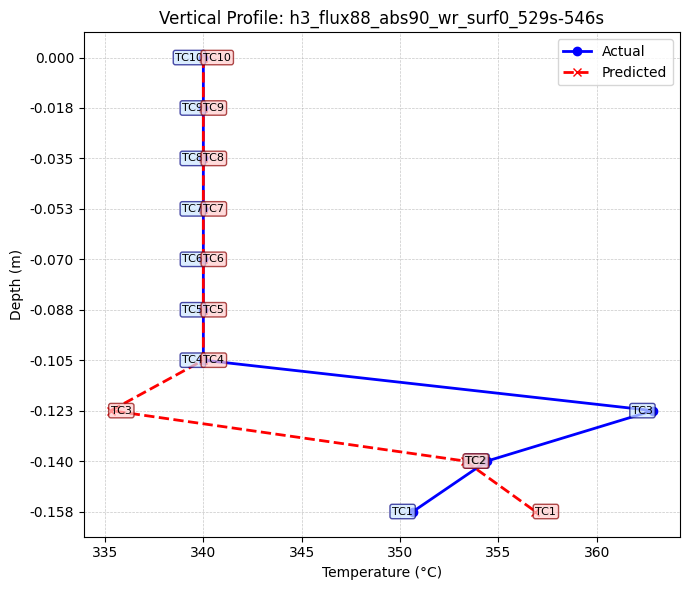

In [24]:
def plot_vertical_profile(predicted, actual, filename="Sample Profile"):
    # Reverse order so TC10 (surface) is at the top
    predicted = predicted[::-1]
    actual = actual[::-1]
    sensor_labels = [f"TC{i}" for i in range(10, 0, -1)]  # TC10 to TC1

    total_height = 0.1575  # Total receiver height in meters
    spacing = total_height / 9
    depths = [0 - i * spacing for i in range(10)]  # TC10 at 0.0, TC1 at -total_height
    

    plt.figure(figsize=(7, 6))
    plt.plot(actual, depths, label="Actual", color='blue', marker='o', linewidth=2)
    plt.plot(predicted, depths, label="Predicted", color='red', marker='x', linestyle='--', linewidth=2)

    plt.gca().invert_yaxis()  # So 0 (surface) is at top

    # Set clean numeric y-ticks
    plt.yticks(depths, [f"{d:.3f}" for d in depths])
    plt.ylim(min(depths) - spacing * 0.5, max(depths) + spacing * 0.5)

    plt.xlabel("Temperature (°C)")
    plt.ylabel("Depth (m)")
    plt.title(f"Vertical Profile: {filename}")
    plt.legend(loc='upper right')

    # Add sensor labels next to each point
    for i, label in enumerate(sensor_labels):
        plt.text(
            actual[i], depths[i], label,
            ha='right', va='center', fontsize=8,
            bbox=dict(boxstyle="round,pad=0.2", fc="#cce6ff", ec="navy", lw=1, alpha=0.7)
        )
        plt.text(
            predicted[i], depths[i], label,
            ha='left', va='center', fontsize=8,
            bbox=dict(boxstyle="round,pad=0.2", fc="#ffcccc", ec="darkred", lw=1, alpha=0.7)
        )

    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.tight_layout()
    plt.savefig(f"{filename}.png", dpi=300, bbox_inches='tight')
    plt.show()


# actual = [361.36,360.52,360.93,362.1,361.66,363.36,361.29,361.44,360.32,337.33]
# pred = [361.057861328125, 359.50201416015625, 360.8453063964844, 360.733642578125, 360.468505859375, 362.0776062011719, 360.5418395996094, 361.2062683105469, 358.7239990234375, 338.3153076171875]

actual=[350.66,354.42,362.85,340,340,340,340,340,340,340]
pred=[356.88,353.31,335.30,340,340,340,340,340,340,340]

plot_vertical_profile(pred, actual, filename="h3_flux88_abs90_wr_surf0_529s-546s")


In [ ]:
# # Block 11: Standalone Testing
# import matplotlib
# matplotlib.use('Agg')  # Use non-interactive Agg backend to avoid tkinter dependency
# import matplotlib.pyplot as plt
# import pandas as pd
# import numpy as np
# import torch

# def cross_check_test_predictions(data_dir, h_filter=0.1575, num_samples=5, filter_condition=None):
#     """Cross-check model predictions with rows from the test dataset."""
#     # Load inference components
#     global pred_model, pred_X_scaler, pred_y_scaler, pred_time_range, pred_column_info, pred_device
#     if not all(var in globals() for var in ['pred_model', 'pred_X_scaler', 'pred_y_scaler', 
#                                            'pred_time_range', 'pred_column_info', 'pred_device']):
#         pred_model, pred_X_scaler, pred_y_scaler, pred_time_range, pred_column_info, pred_device = load_for_prediction()
#         if pred_model is None:
#             raise ValueError("Failed to load inference components. Ensure model and scalers are saved.")

#     # Load and preprocess data to get test_loader
#     data = load_data(data_dir, h_filter=h_filter)
#     train_loader, val_loader, test_loader, X_scaler, y_scaler, tc_cols = preprocess_data(data, use_enhanced_features=True)
    
#     # Extract test dataset from test_loader
#     X_test_scaled = np.concatenate([batch[0].numpy() for batch in test_loader], axis=0)
#     y_test_scaled = np.concatenate([batch[1].numpy() for batch in test_loader], axis=0)
    
#     # Inverse transform to get original feature and target values
#     X_test = pred_X_scaler.inverse_transform(X_test_scaled)
#     y_test = pred_y_scaler.inverse_transform(y_test_scaled)
    
#     # Create DataFrame for test data
#     feature_cols = pred_column_info['feature_cols']
#     test_df = pd.DataFrame(X_test, columns=feature_cols)
#     test_df[tc_cols] = y_test
    
#     # Add original 'Time' (before normalization) for filtering
#     time_min = pred_time_range['time_min']
#     time_max = pred_time_range['time_max']
#     test_df['Time'] = test_df['Time_norm'] * (time_max - time_min) + time_min
    
#     # Apply filter condition if provided (e.g., specific time or flux)
#     if filter_condition is not None:
#         test_df = test_df.query(filter_condition)
#         if test_df.empty:
#             raise ValueError(f"No test rows match the condition: {filter_condition}")
    
#     # Sample rows for cross-checking (no random_state for true randomness)
#     num_samples = min(num_samples, len(test_df))
#     if num_samples == 0:
#         raise ValueError("No test samples available after filtering!")
#     sample_rows = test_df.sample(n=num_samples,random_state=33) if filter_condition is None else test_df.head(num_samples)
    
#     print(f"\n=== Cross-Checking {len(sample_rows)} Test Samples ===")
#     results = []
    
#     for idx, row in sample_rows.iterrows():
#         # Prepare input features
#         time = row['Time']
#         h = row['h']
#         flux = row['flux']
#         abs_val = row['abs']
#         surf = row['surf']
#         theoretical_temps = [row[col] for col in [c for c in feature_cols if c.startswith('Theoretical_Temps_')]]
        
#         # Make prediction
#         try:
#             pred_result = predict_temperature(
#                 pred_model, pred_X_scaler, pred_y_scaler, pred_time_range, pred_column_info,
#                 time, h, flux, abs_val, surf, theoretical_temps, pred_device
#             )
            
#             # Get actual temperatures
#             actual_temps = {col: row[col] for col in tc_cols}
            
#             # Compare predictions with actuals
#             comparison = {
#                 'index': idx,
#                 'inputs': {
#                     'time': time,
#                     'h': h,
#                     'flux': flux,
#                     'abs': abs_val,
#                     'surf': surf,
#                     'theoretical_temps': theoretical_temps
#                 },
#                 'predicted_temps': pred_result['predicted_temperatures'],
#                 'actual_temps': actual_temps,
#                 'errors': {col: abs(pred_result['predicted_temperatures'][col] - actual_temps[col]) 
#                           for col in tc_cols}
#             }
            
#             results.append(comparison)
            
#             # Print comparison
#             print(f"\nTest Sample {idx}:")
#             print(f"Inputs: Time={time:.2f}s, h={h:.4f}, flux={flux:.0f}, abs={abs_val:.0f}, surf={surf:.2f}")
#             print("Theoretical Temps:", [f"{t:.2f}" for t in theoretical_temps])
#             print("Predicted vs Actual Temperatures:")
#             print("-" * 50)
#             print(f"{'Sensor':<15} {'Predicted (°C)':<15} {'Actual (°C)':<15} {'Error (°C)':<15}")
#             print("-" * 50)
#             for col in tc_cols:
#                 pred_temp = pred_result['predicted_temperatures'][col]
#                 actual_temp = actual_temps[col]
#                 error = comparison['errors'][col]
#                 print(f"{col:<15} {pred_temp:<15.3f} {actual_temp:<15.3f} {error:<15.3f}")
            
#         except Exception as e:
#             print(f"Error processing test sample {idx}: {e}")
    
#     # Calculate average errors
#     if results:
#         avg_errors = {col: np.mean([r['errors'][col] for r in results]) for col in tc_cols}
#         print("\n=== Average Errors (Test Set) ===")
#         print(f"{'Sensor':<15} {'Avg Error (°C)':<15}")
#         print("-" * 30)
#         for col, avg_error in avg_errors.items():
#             print(f"{col:<15} {avg_error:<15.3f}")
    
#     return results

# def run_test_cross_check(data_dir, h_filter=0.1575, num_samples=5, filter_condition=None):
#     """Run cross-checking on test data without requiring main execution."""
#     try:
#         print("\n=== Running Standalone Test Cross-Check ===")
#         results = cross_check_test_predictions(data_dir, h_filter, num_samples, filter_condition)
        
#         # Plot results using plot_vertical_profile
#         for result in results:
#             # Extract predicted and actual temperatures in order TC1_tip to TC10
#             tc_cols = ['TC1_tip', 'TC2', 'TC3', 'TC4', 'TC5', 'TC6', 'TC7', 'TC8', 'TC9', 'TC10']
#             predicted = [result['predicted_temps'][col] for col in tc_cols]
#             actual = [result['actual_temps'][col] for col in tc_cols]
#             # Create filename based on input conditions
#             filename = (
#                 f"h{h_filter}_flux{result['inputs']['flux']}_"
#                 f"abs{result['inputs']['abs']}_surf{result['inputs']['surf']}_"
#                 f"time{result['inputs']['time']:.0f}s"
#             )
#             try:
#                 plot_vertical_profile(predicted, actual, filename=f"Sample {result['index']} - {filename}")
#                 print(f"Plot saved: {filename}.png")
#             except Exception as e:
#                 print(f"Error plotting sample {result['index']}: {e}")
        
#         # Save results to CSV
#         # pd.DataFrame(results).to_csv('test_cross_check_results.csv')
#         # print("Results saved to 'test_cross_check_results.csv'")
        
#         return results
    
#     except Exception as e:
#         print(f"Error in standalone test cross-check: {e}")
#         return None

# # Example usage
# if __name__ == "__main__":
#     DATA_DIR = get_data_directory()
#     run_test_cross_check(DATA_DIR, h_filter=0.1575, num_samples=3)

Found data directory: data/new_processed_reset

=== Running Standalone Test Cross-Check ===
Loading data from: data/new_processed_reset
Loaded: cleaned_h6_flux88_abs20_surf0_699s - Sheet1_processed.csv (717 rows)
Skipping (not h=0.1575): cleaned_h2_flux88_abs92_wr_surf0_215s - Sheet1_processed.csv
Loaded: cleaned_h6_flux88_abs0_mr_surf0_617s - Sheet1_processed.csv (532 rows)
Skipping (not h=0.1575): cleaned_h2_flux88_abs0_surf0_probeUp_590s - Sheet2_processed.csv
Skipping (not h=0.1575): cleaned_h3_flux88_abs25_mr_surf0_796s-Sheet1_processed.csv
Loaded: cleaned_h6_flux88_abs20_surf0_longRun_780s - Sheet1_processed.csv (4621 rows)
Loaded: cleaned_h6_flux73_abs0_surf1_754s - Sheet3_processed.csv (566 rows)
Loaded: cleaned_h6_flux88_abs92_surf0_648s - Sheet3_processed.csv (621 rows)
Loaded: cleaned_h6_flux88_abs92_surf0_630s - Sheet2_processed.csv (618 rows)
Loaded: cleaned_h6_flux88_abs92_wr_surf0 _835s- Sheet1_processed.csv (516 rows)
Loaded: cleaned_h6_flux88_abs20_surf1_675s - Sheet3_

: 

: 

: 